# Exploratory Data Analysis for Housing Price Competition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
color = sns.color_palette()
import warnings
from scipy import stats
from scipy.stats import norm, skew #for some statistics


def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

%matplotlib inline
%load_ext autoreload

In [2]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [3]:
train_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv'
)

train_data.shape

(1460, 81)

In [4]:
test_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\test.csv'
)

test_data_origin = test_data.copy()

test_data.shape

(1459, 80)

### 1. Target ('SalePrice')

In [5]:
train_data['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

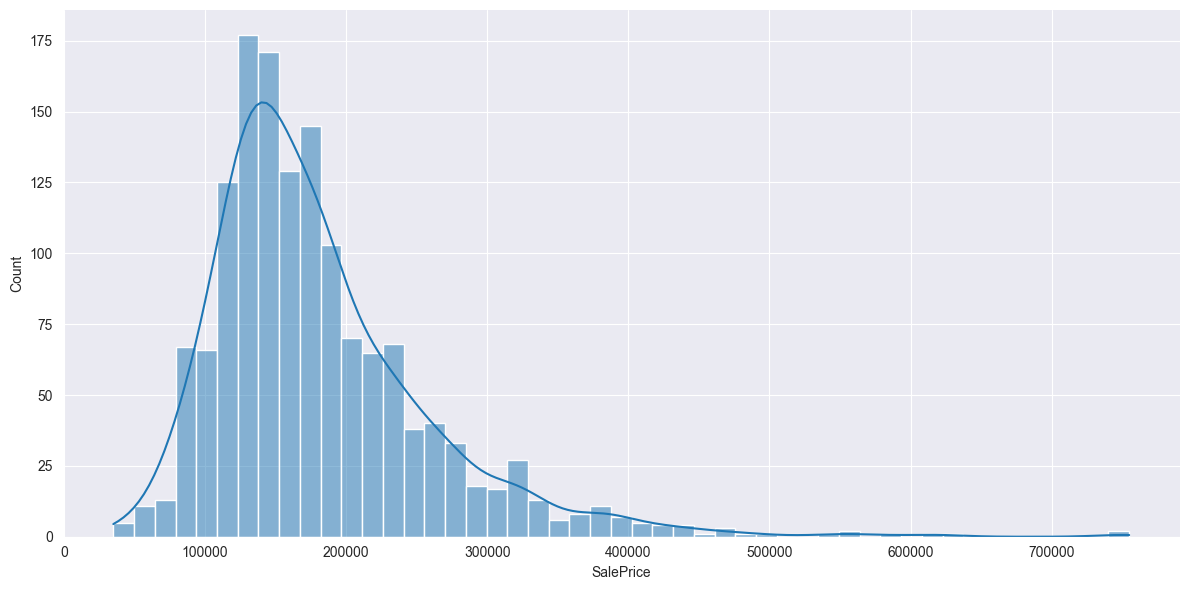

Skewness: 1.882876
Kurtosis: 6.536282


In [6]:
sns.set_style('darkgrid')

sns.displot(train_data['SalePrice'], kind='hist', height=6, aspect=2, kde=True)
plt.show()

print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

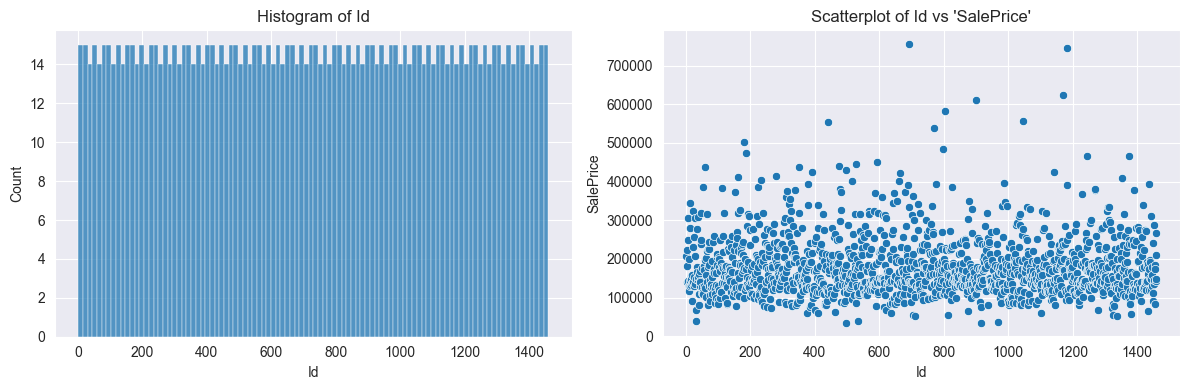

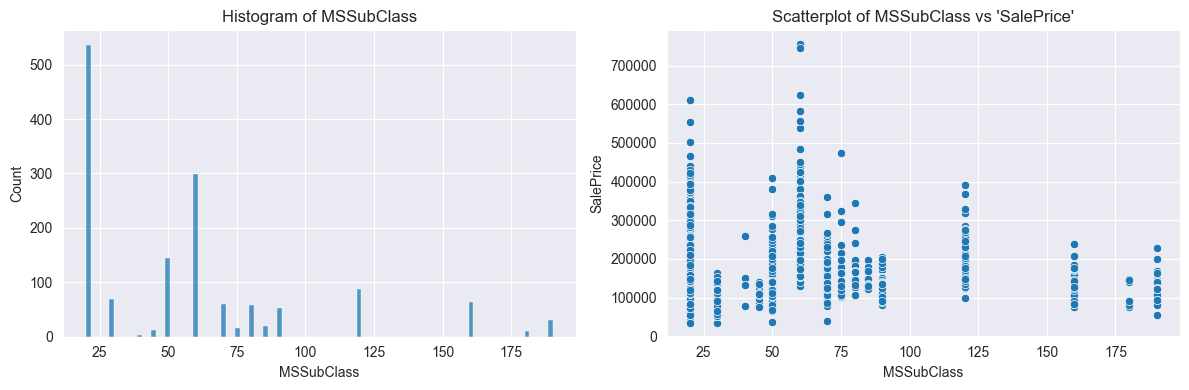

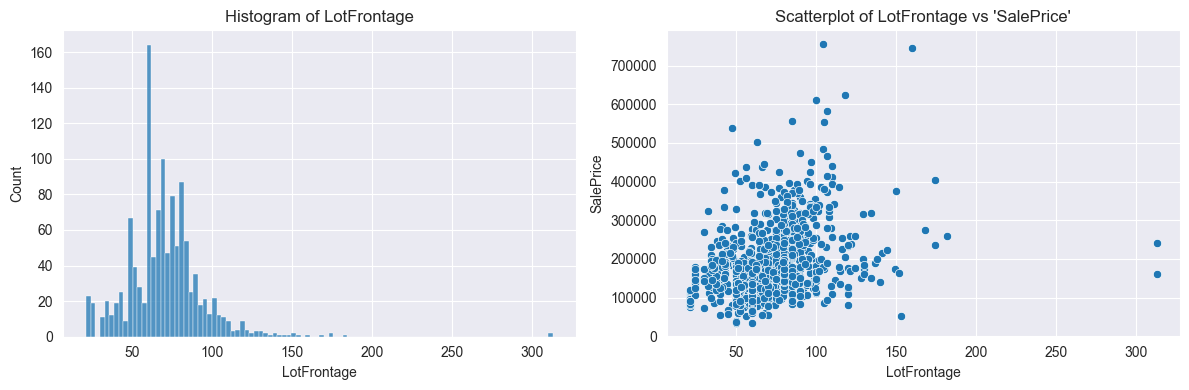

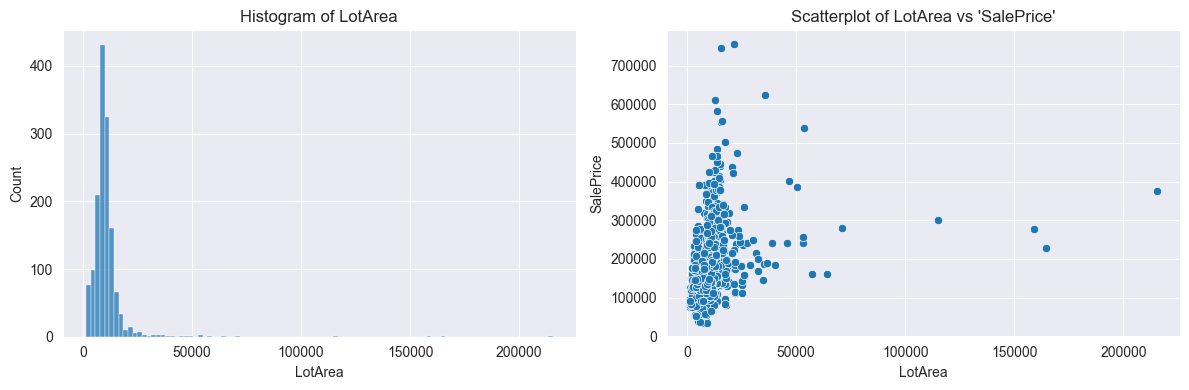

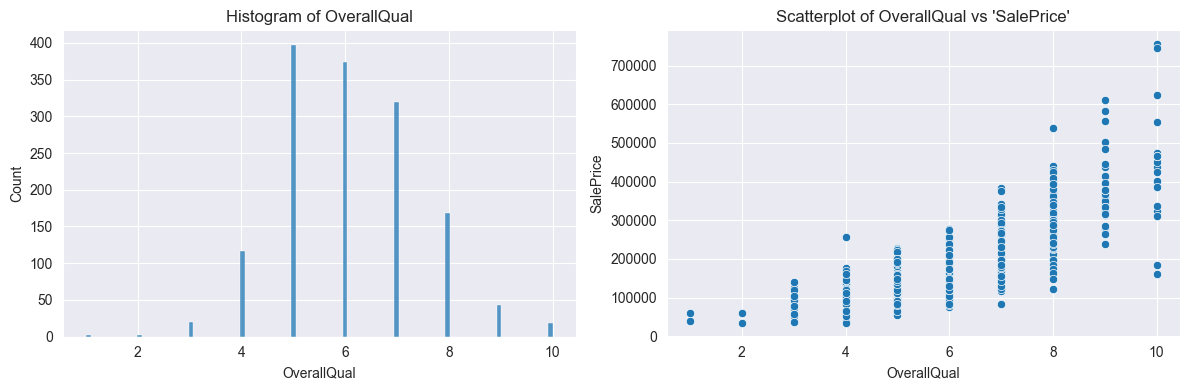

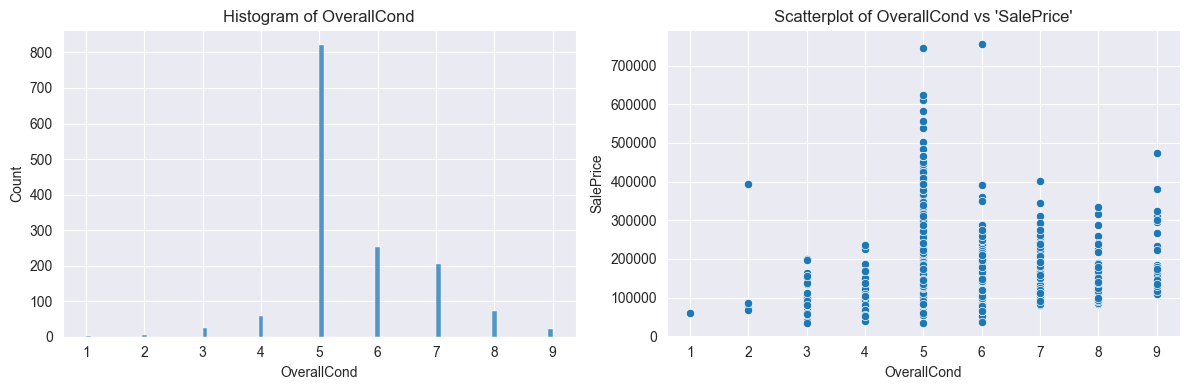

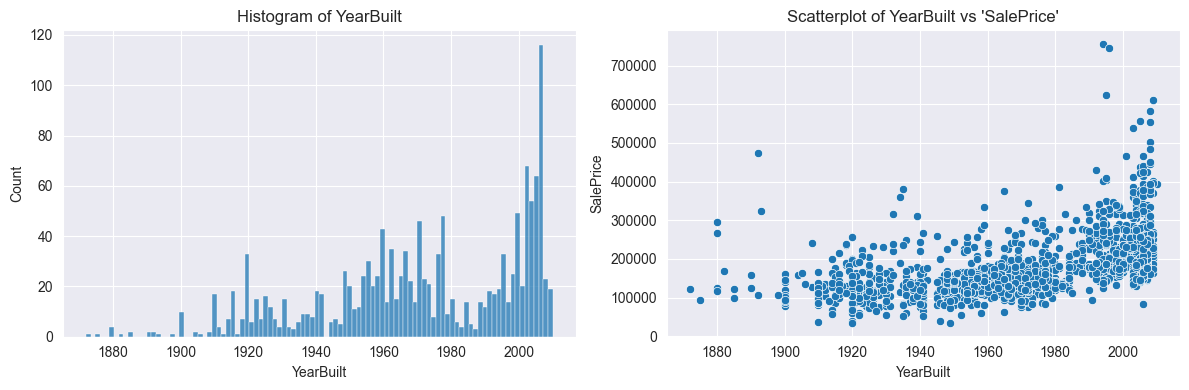

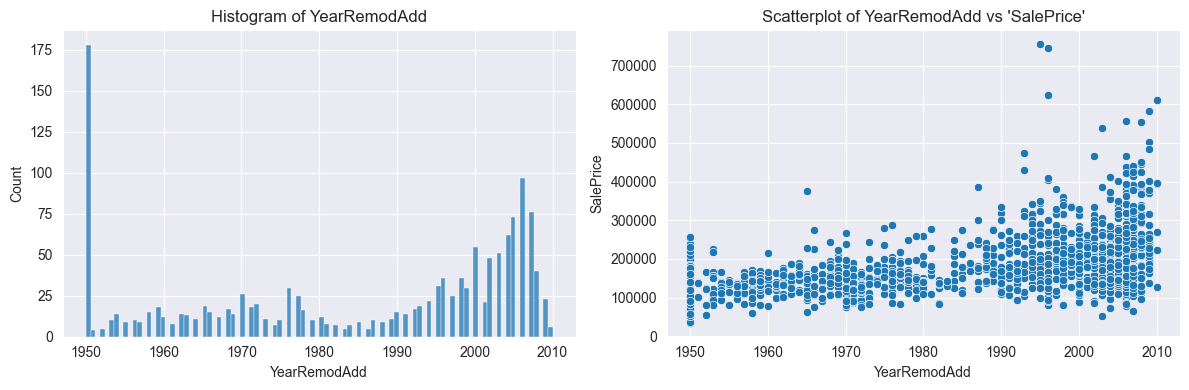

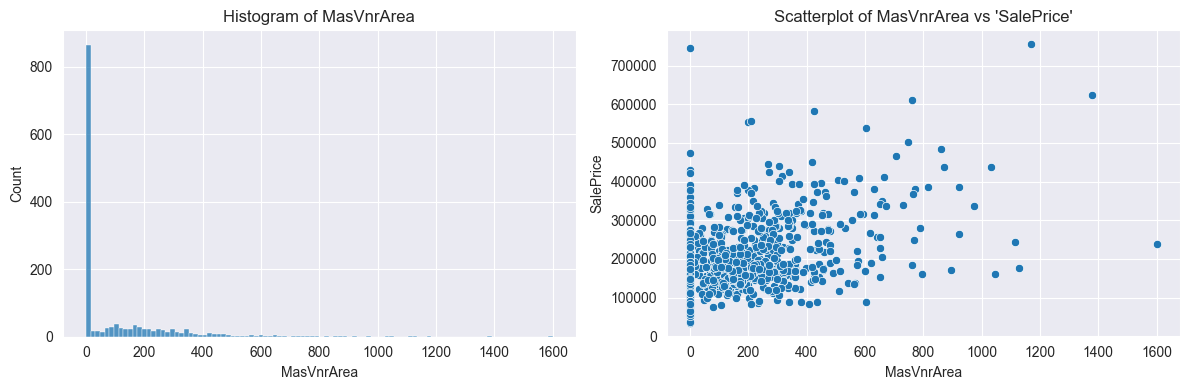

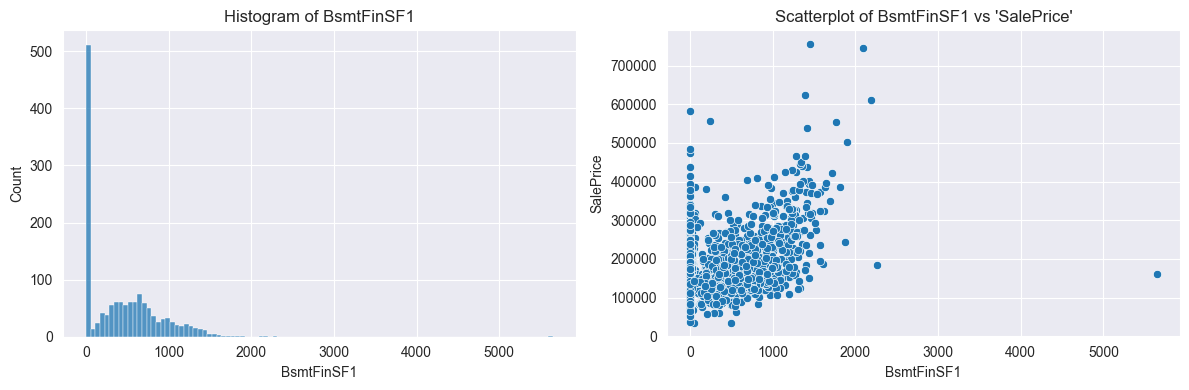

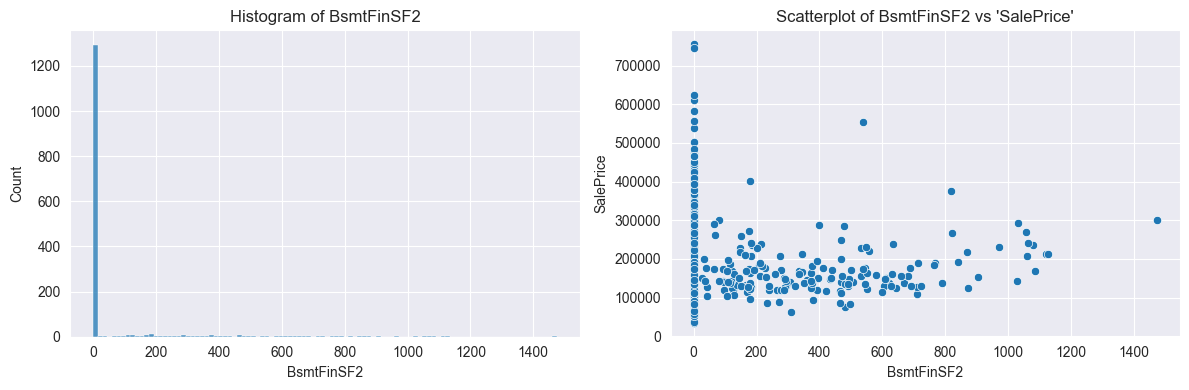

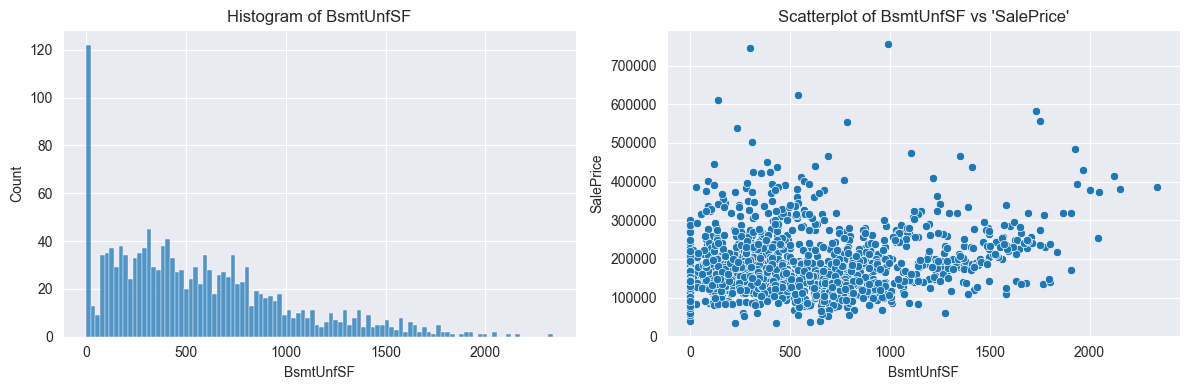

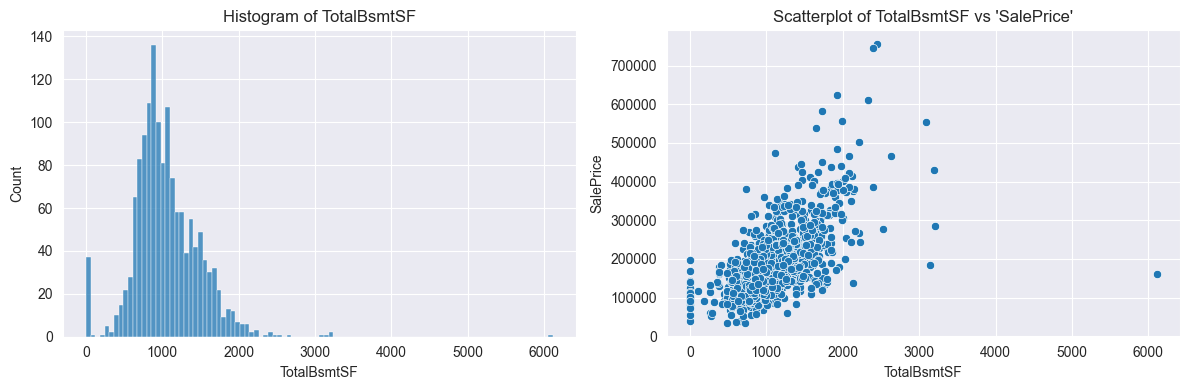

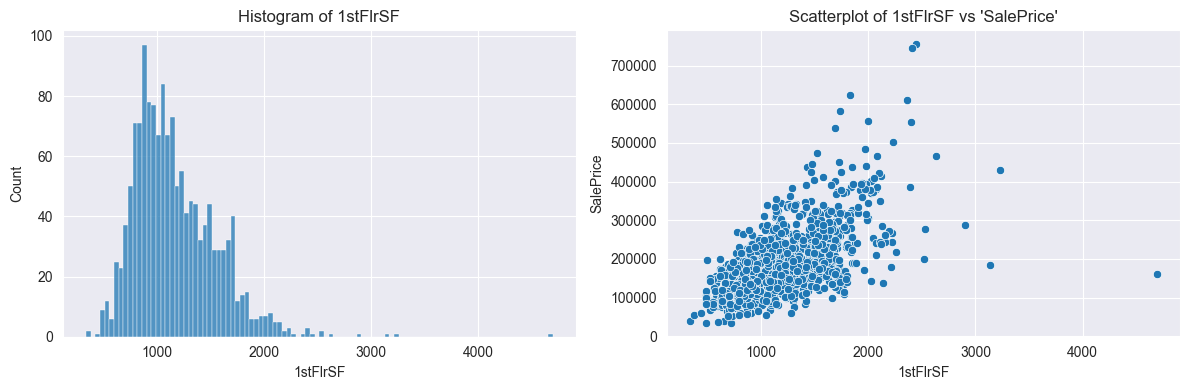

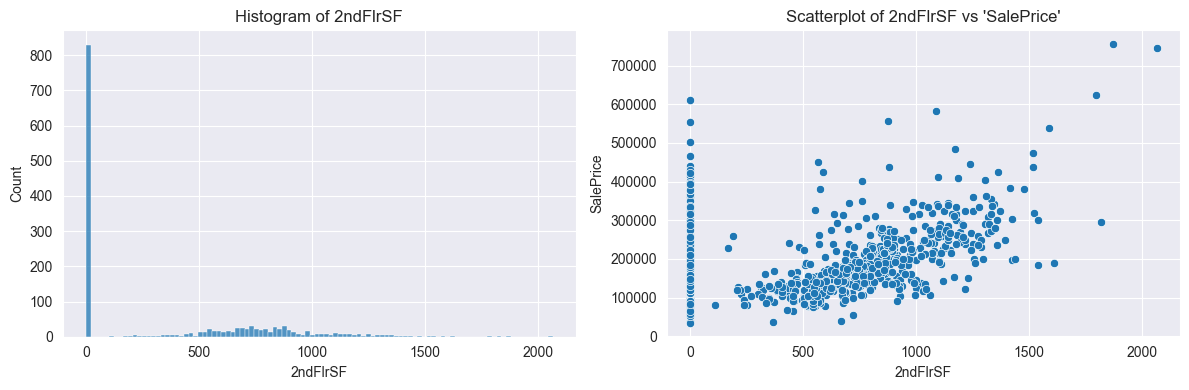

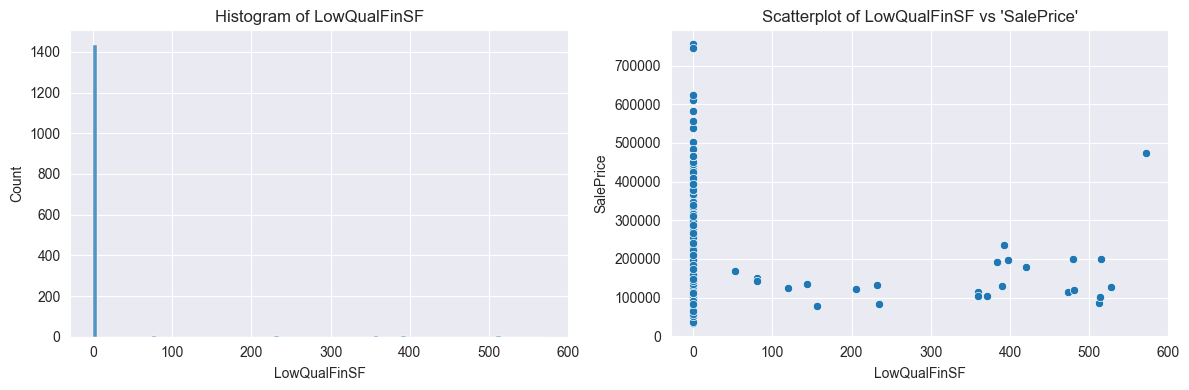

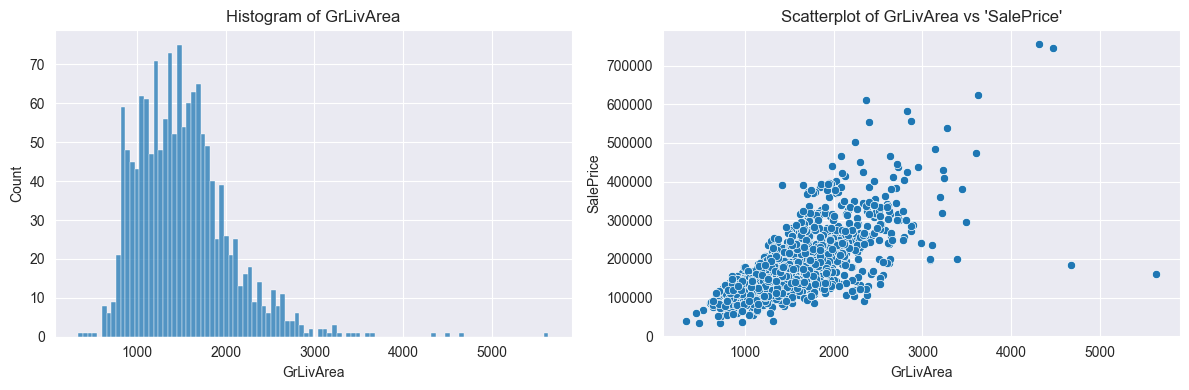

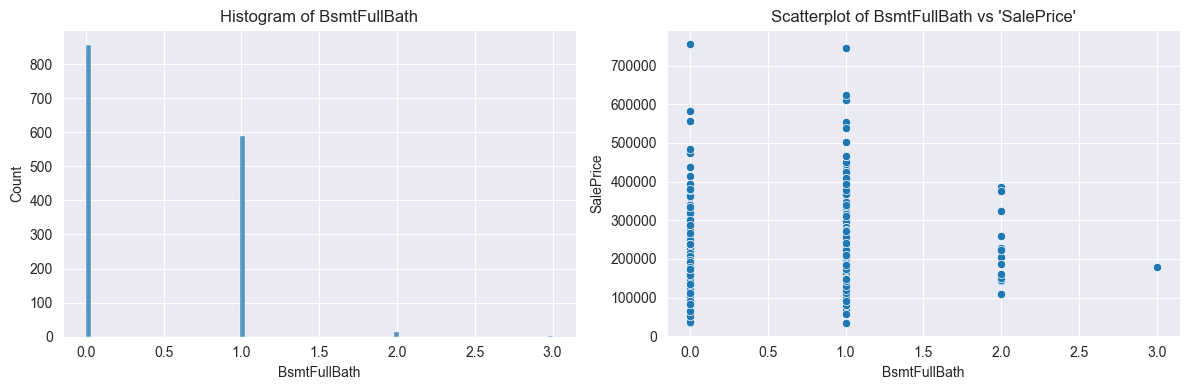

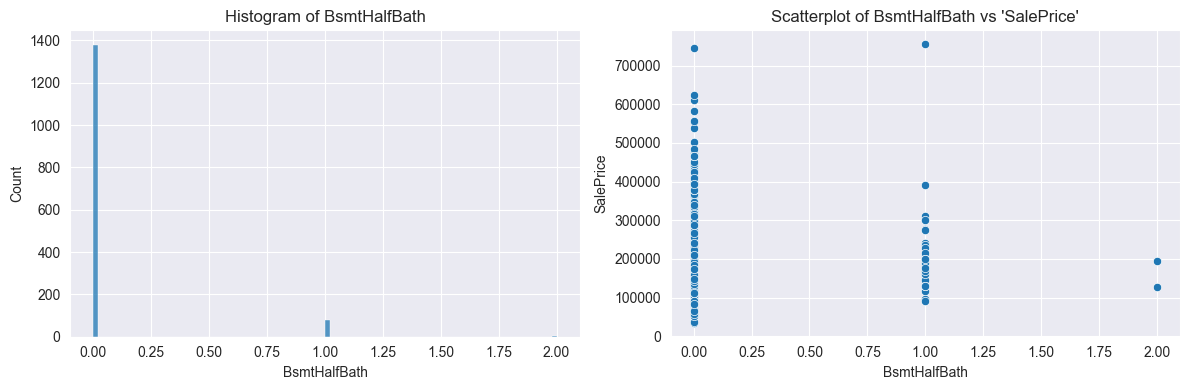

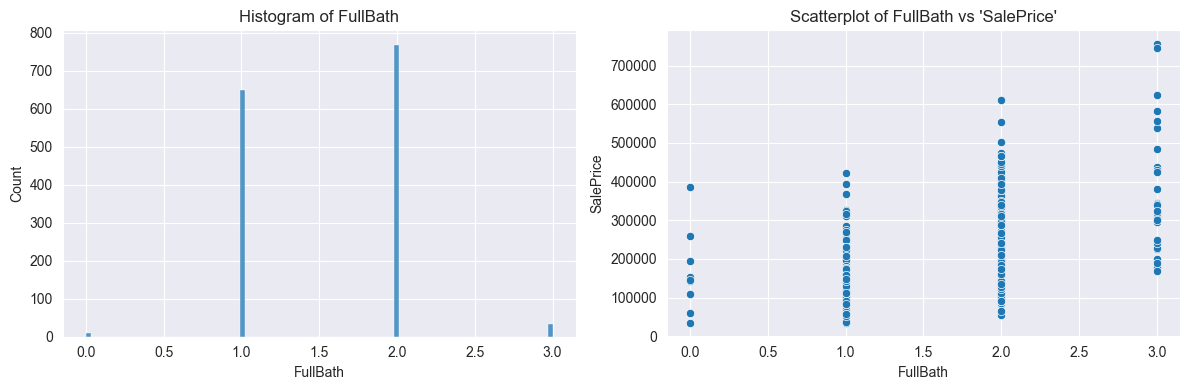

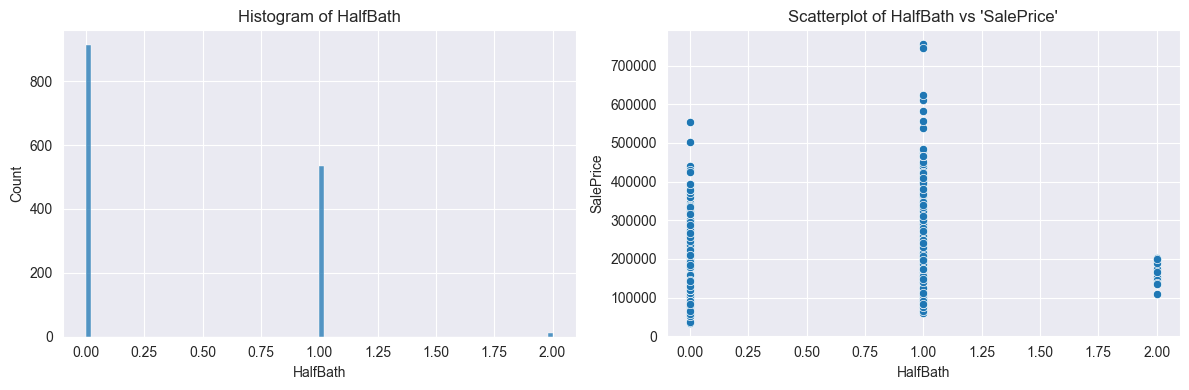

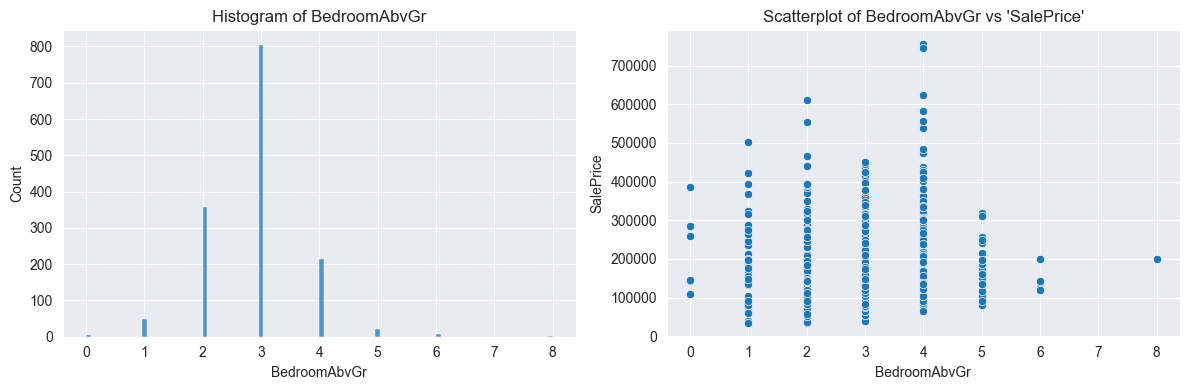

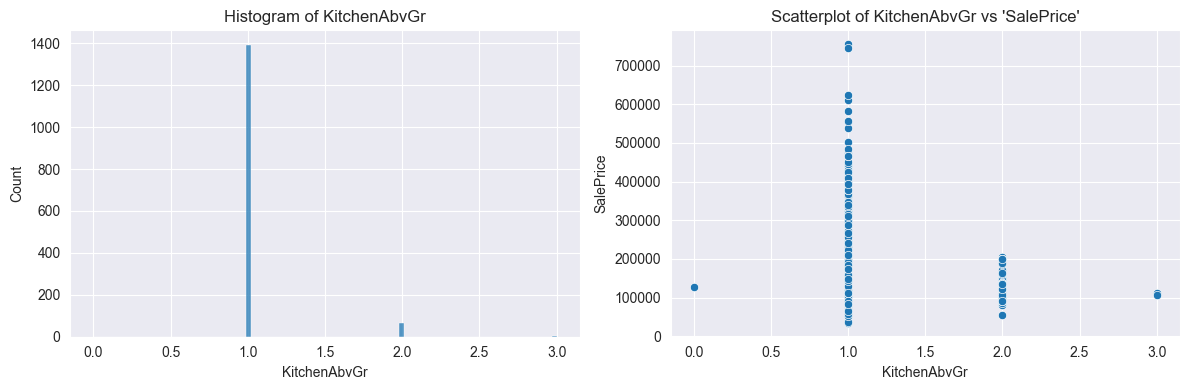

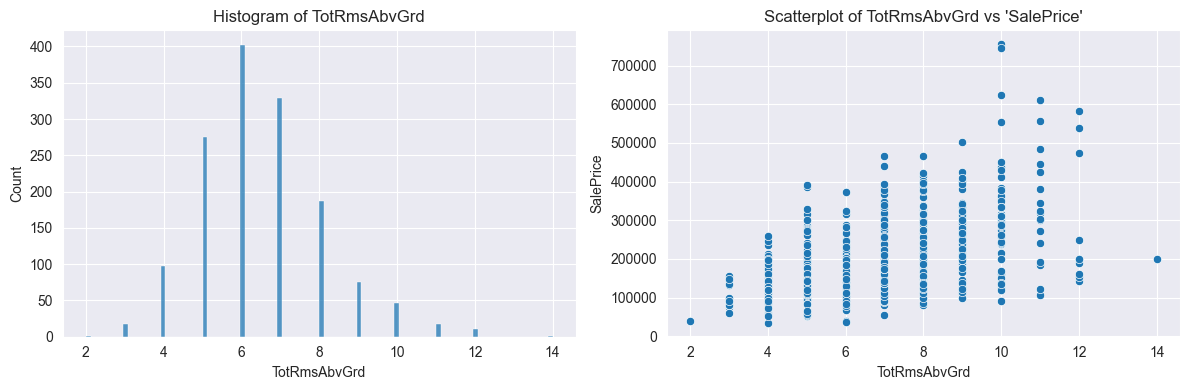

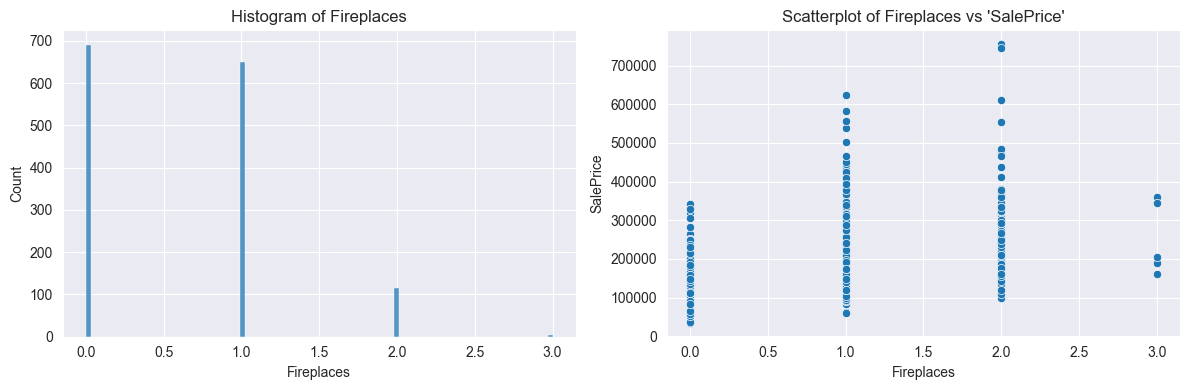

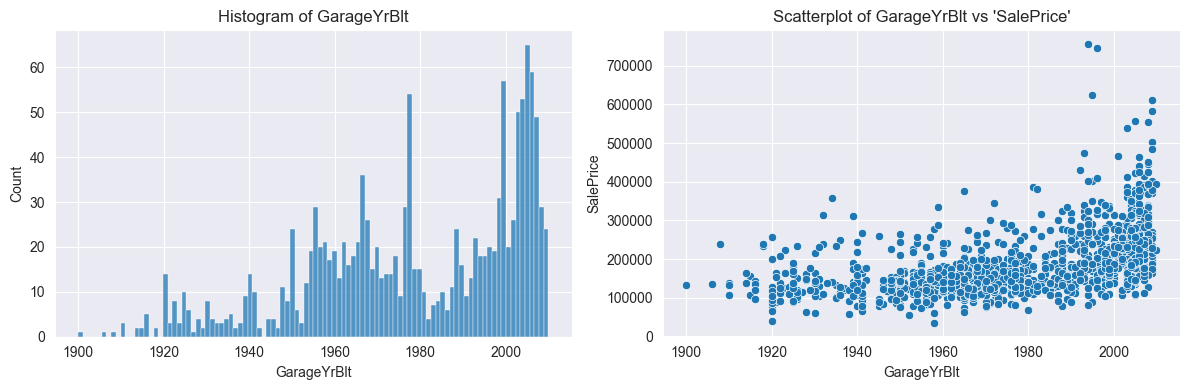

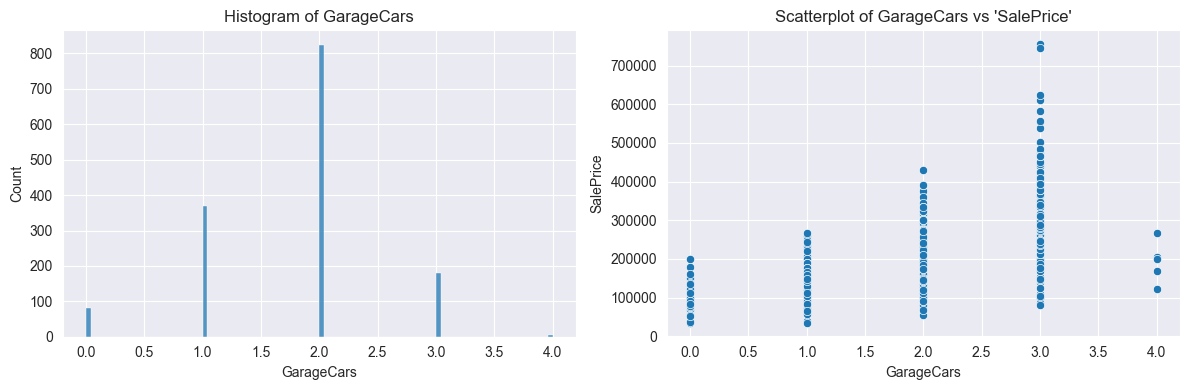

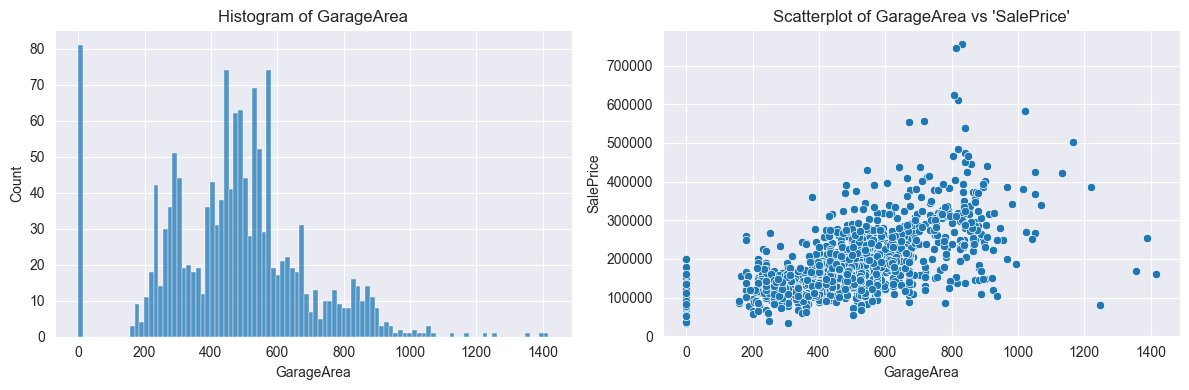

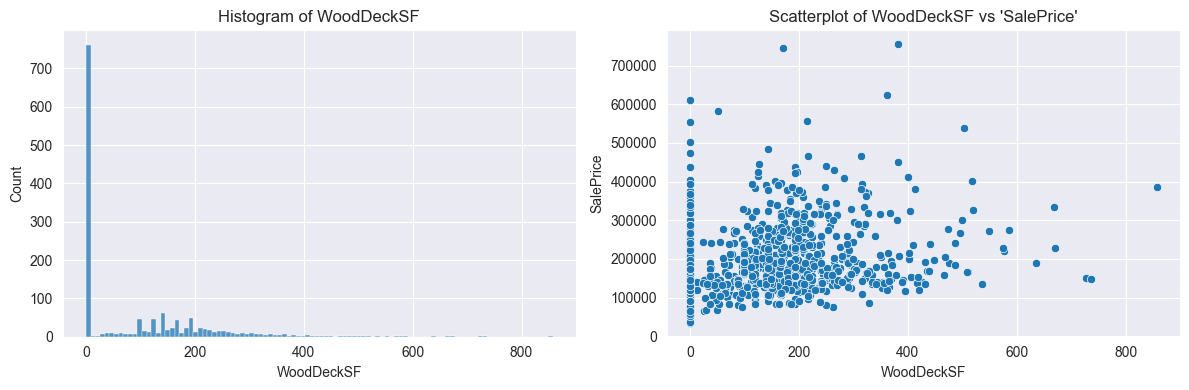

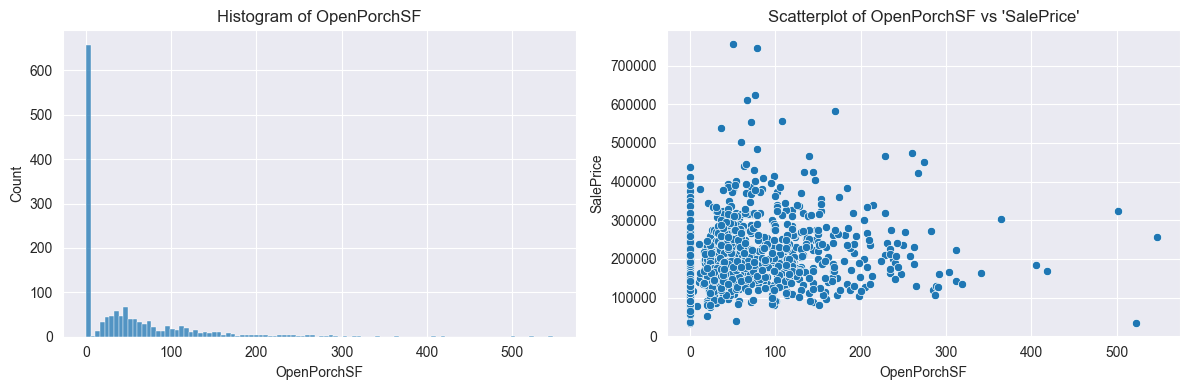

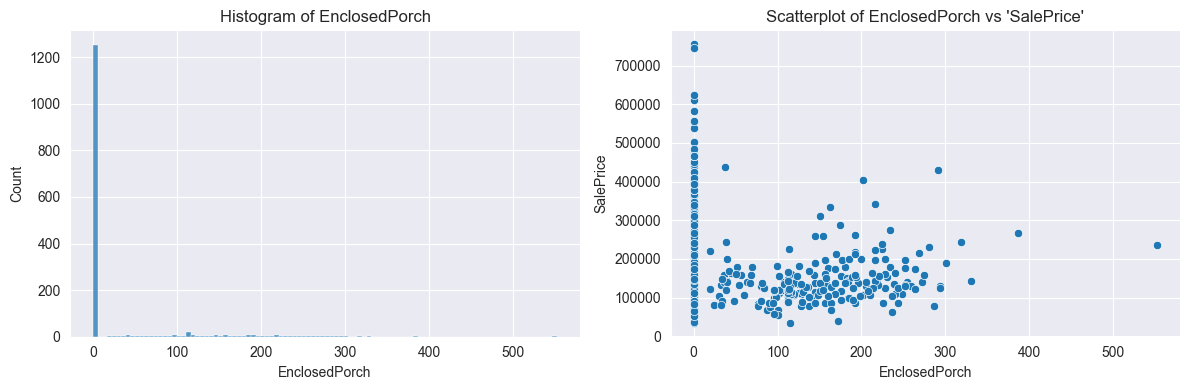

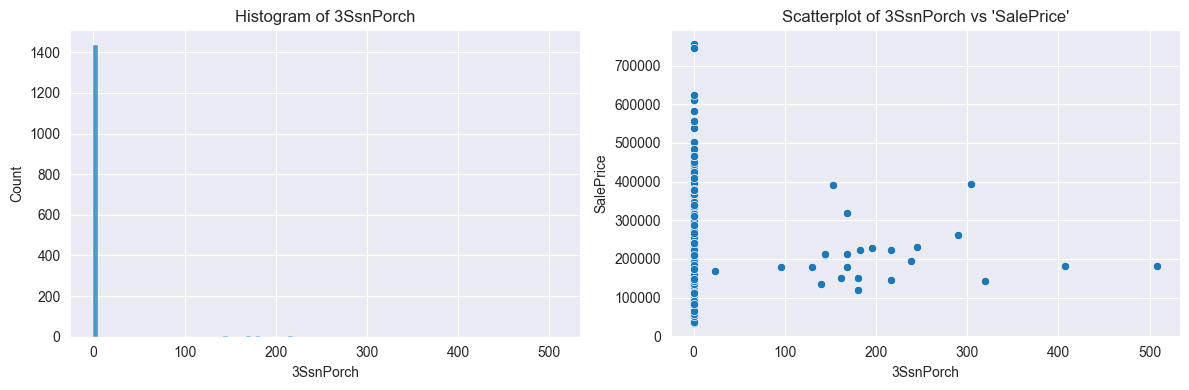

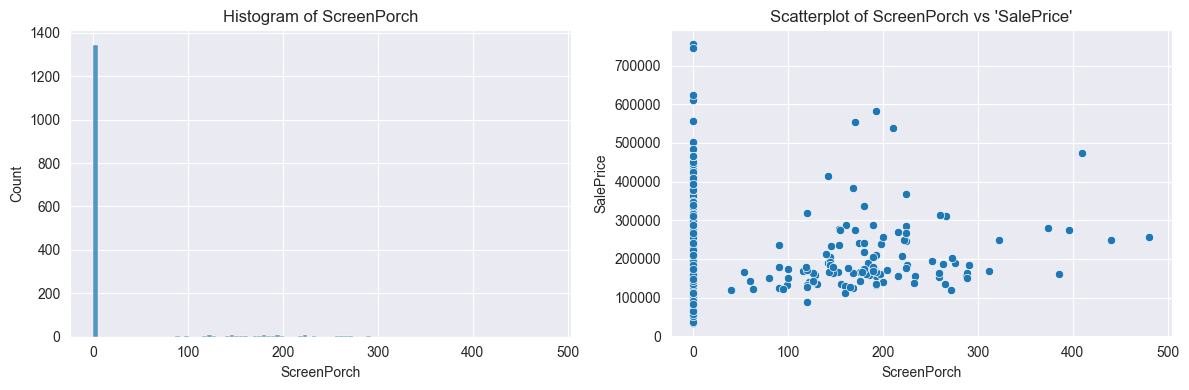

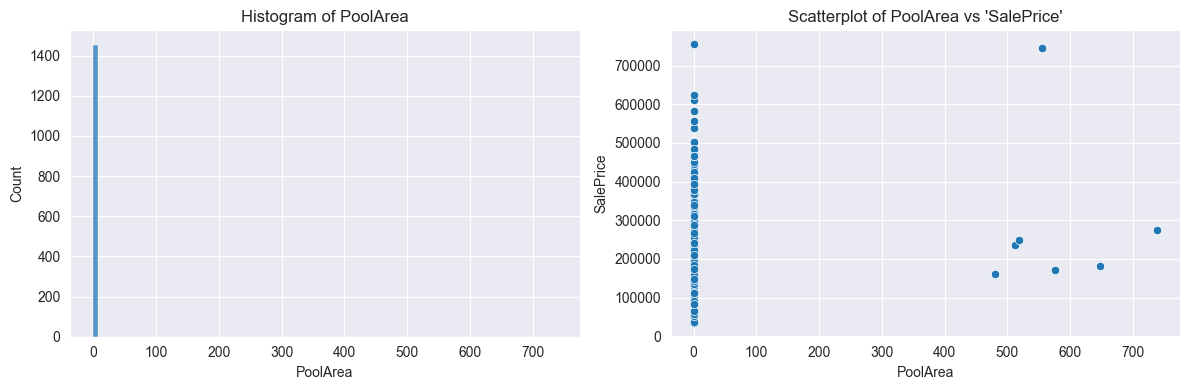

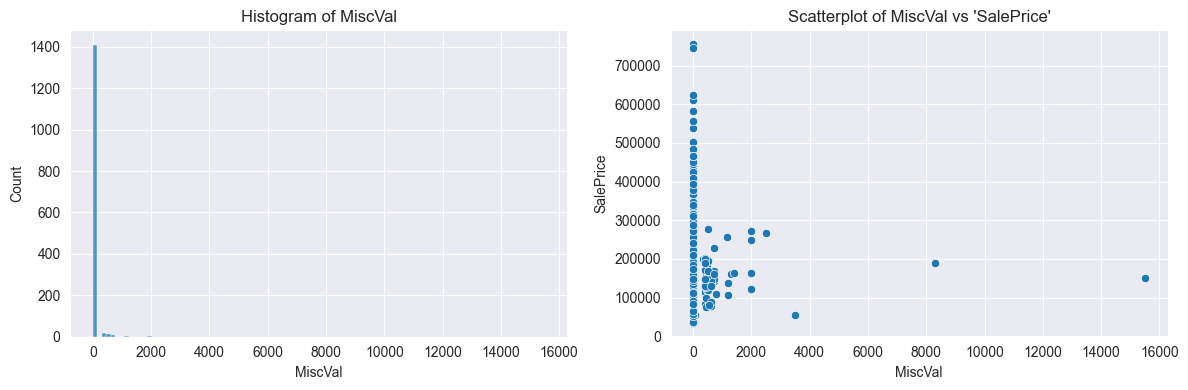

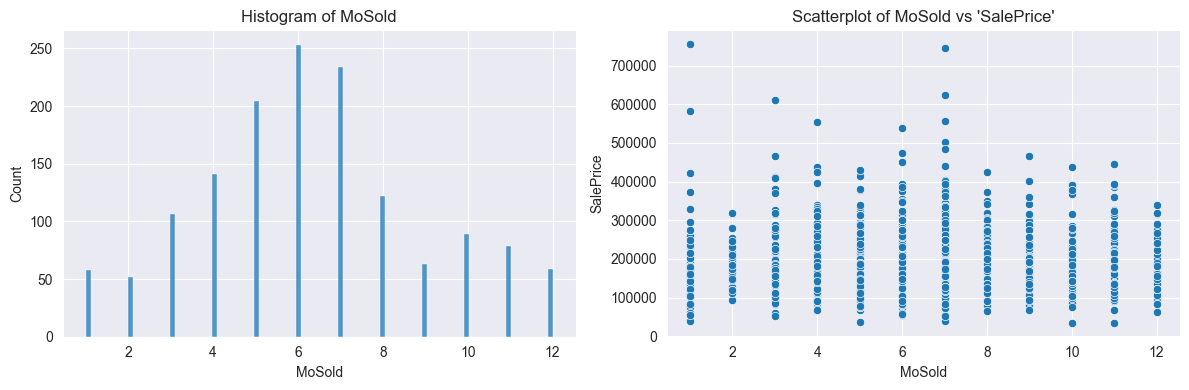

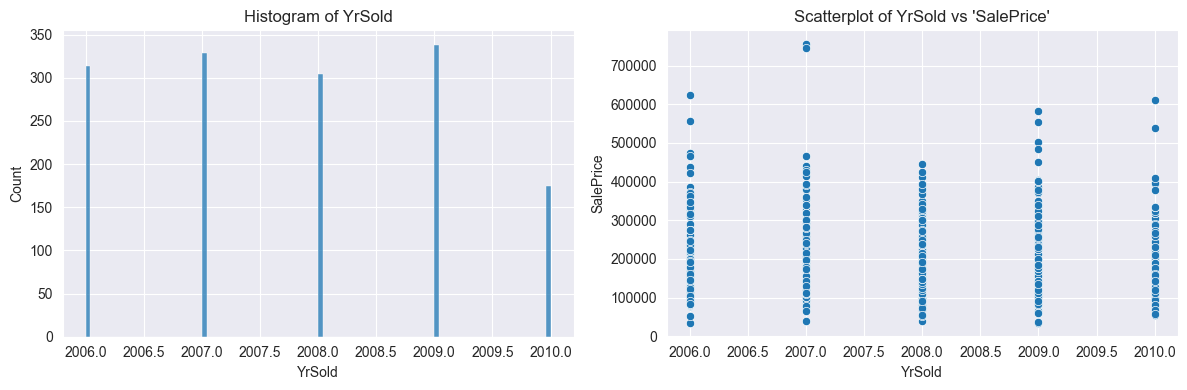

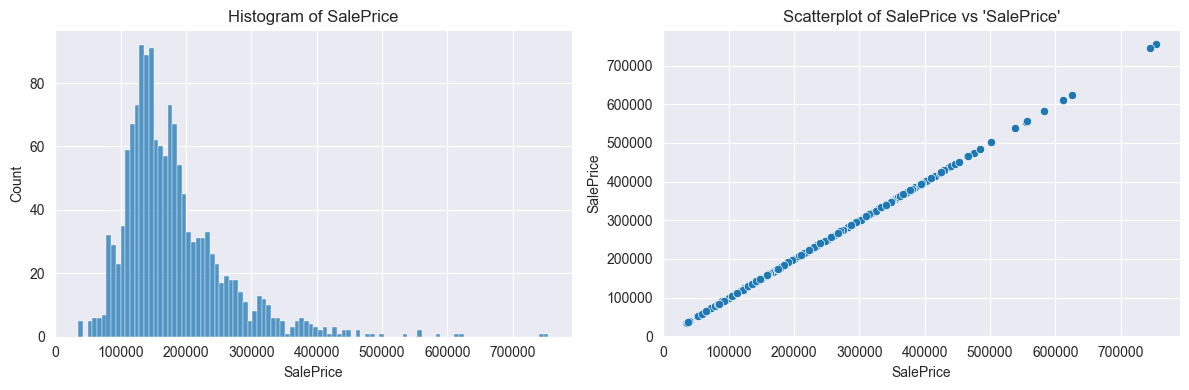

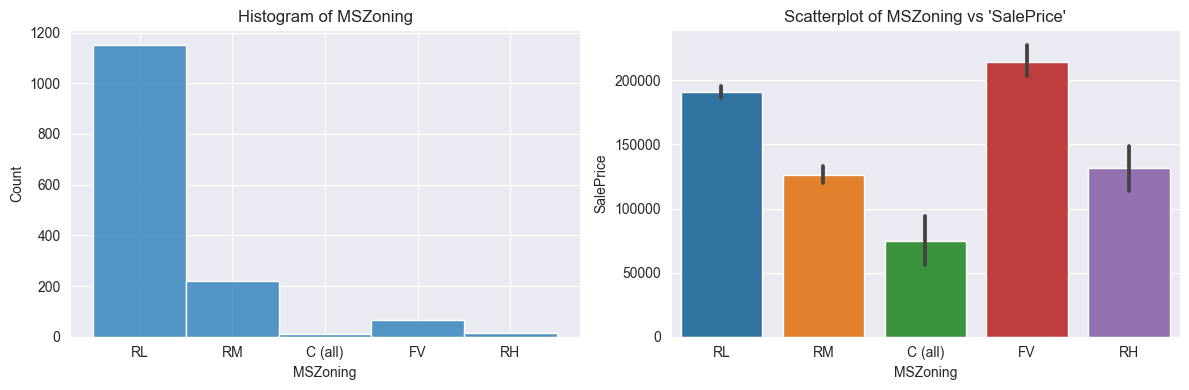

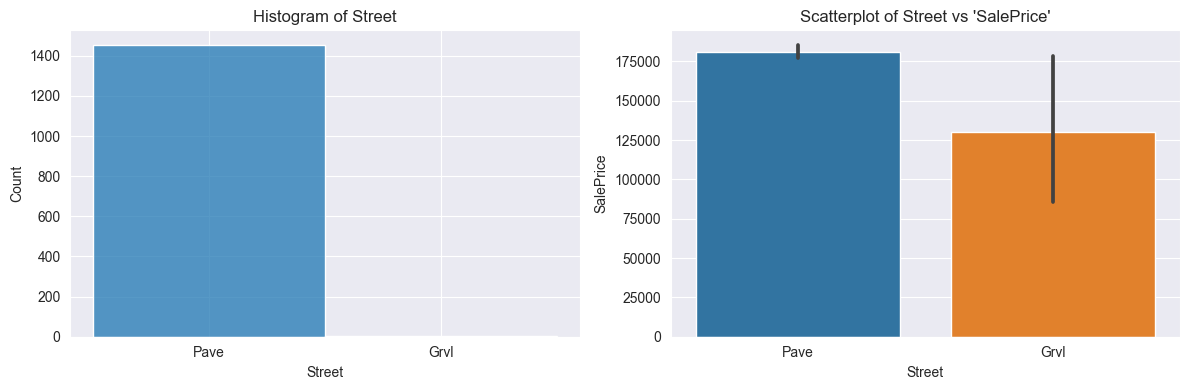

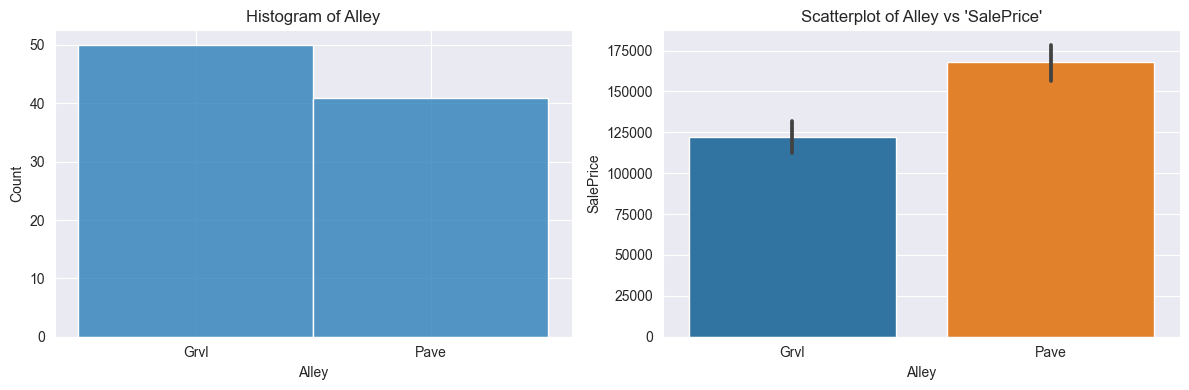

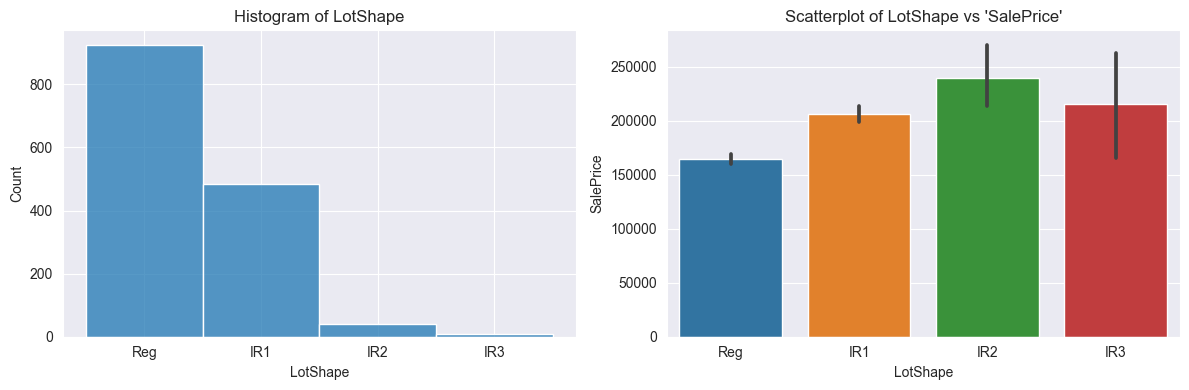

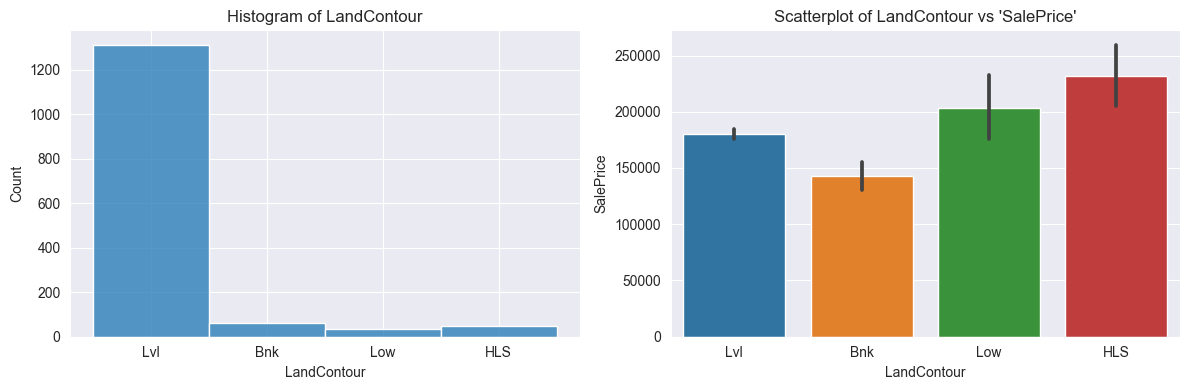

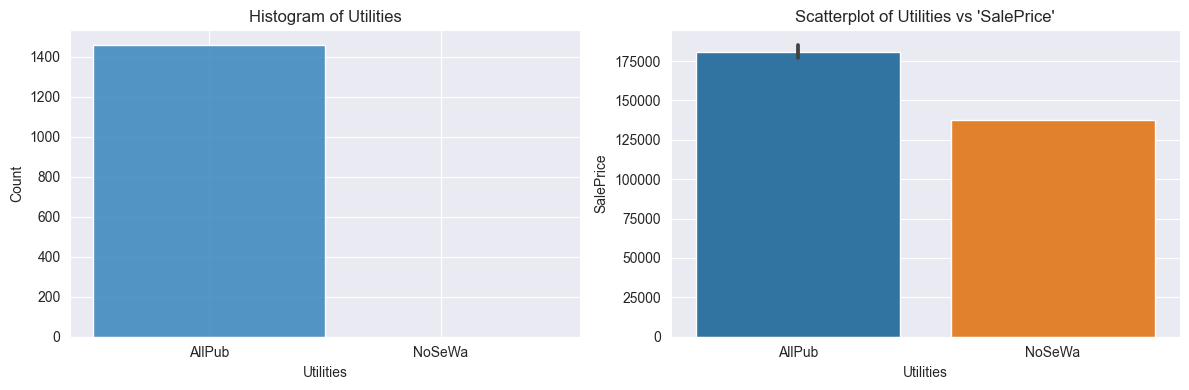

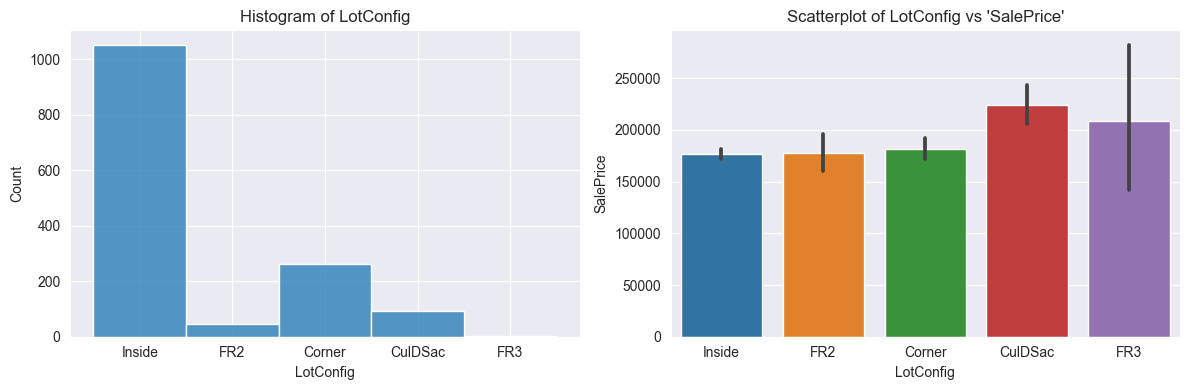

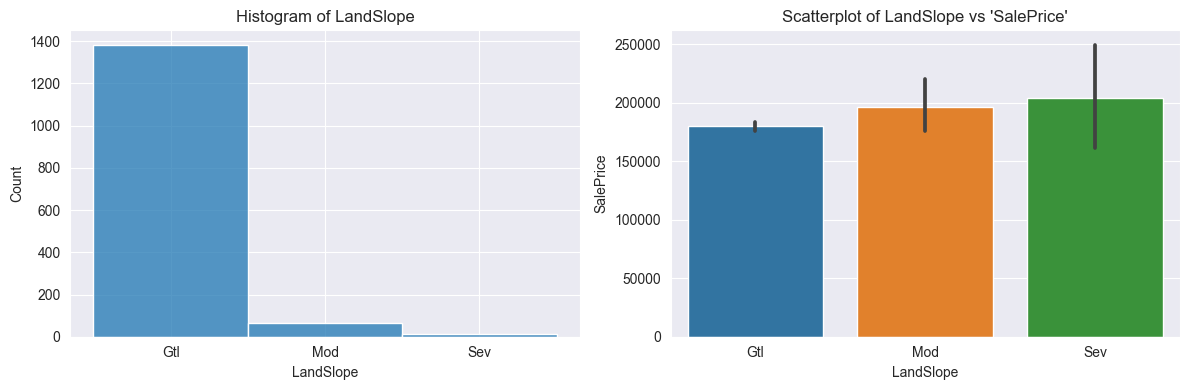

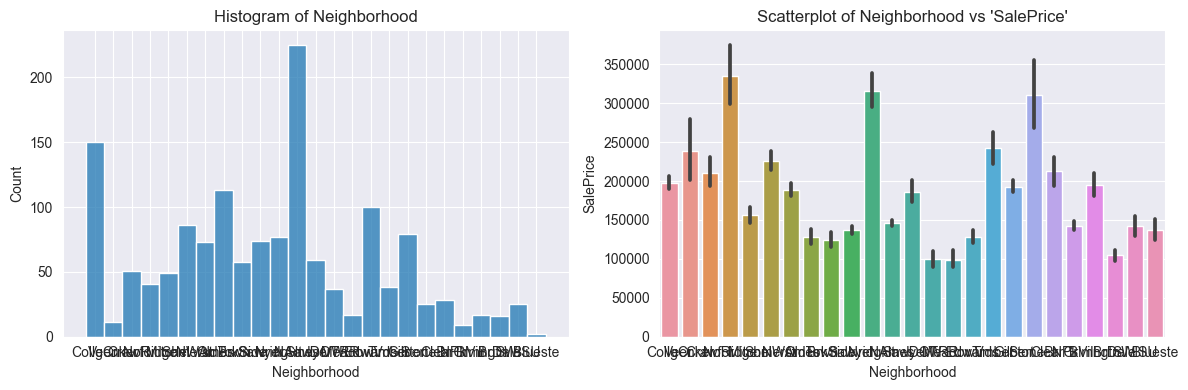

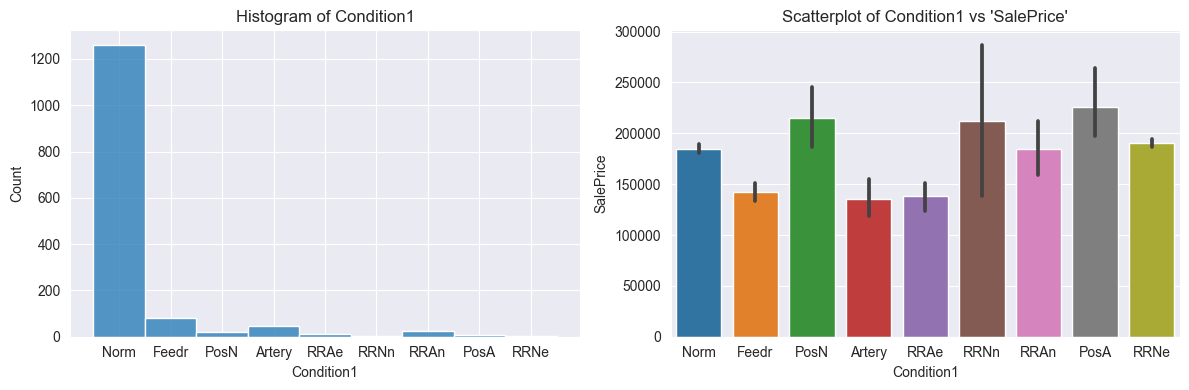

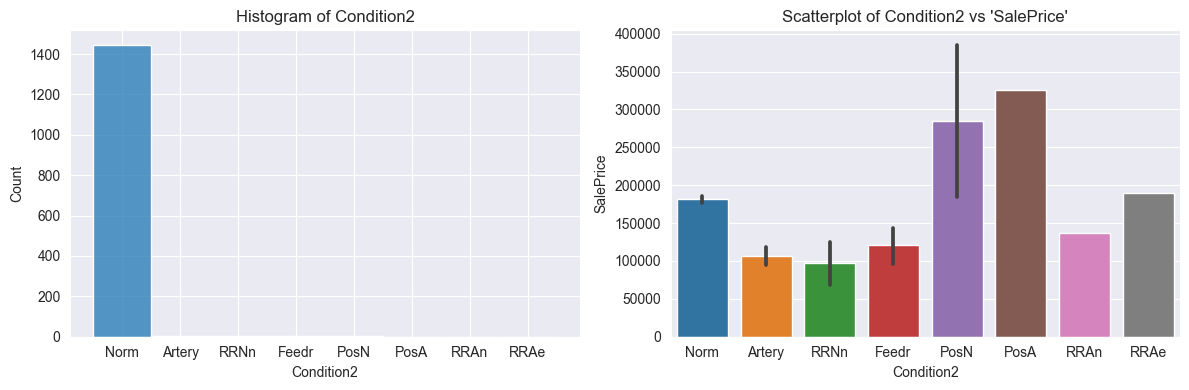

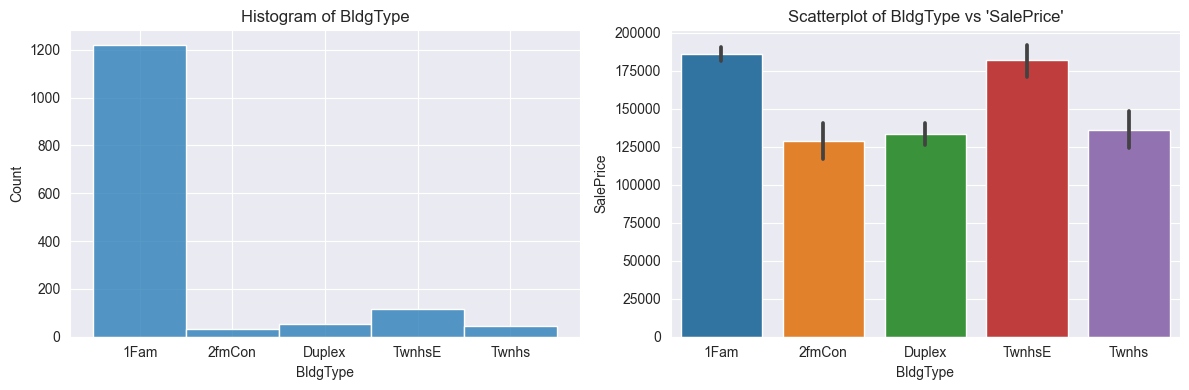

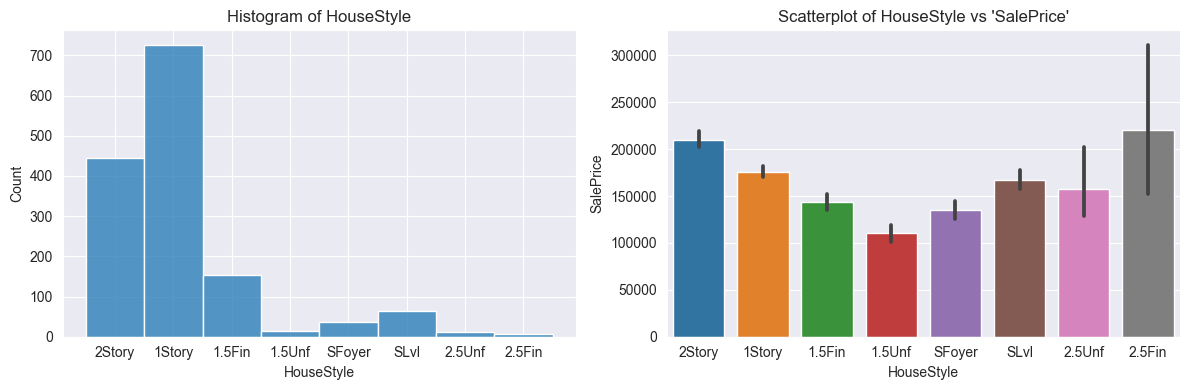

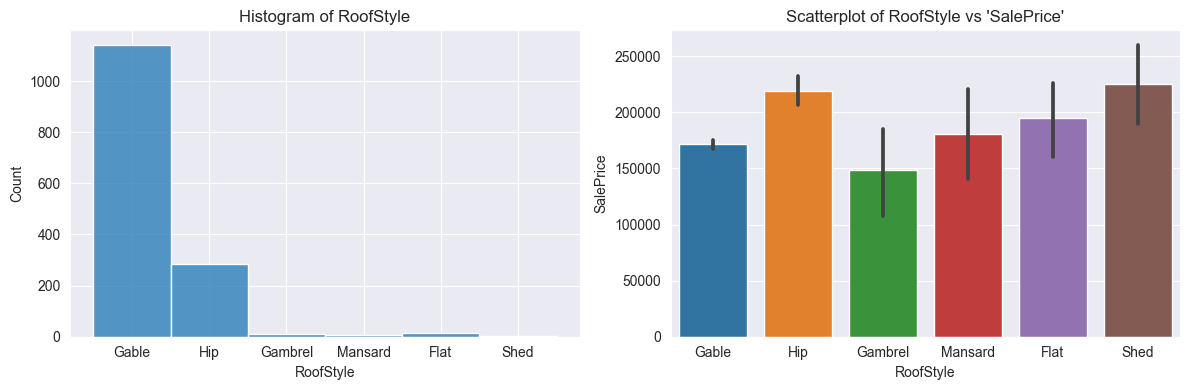

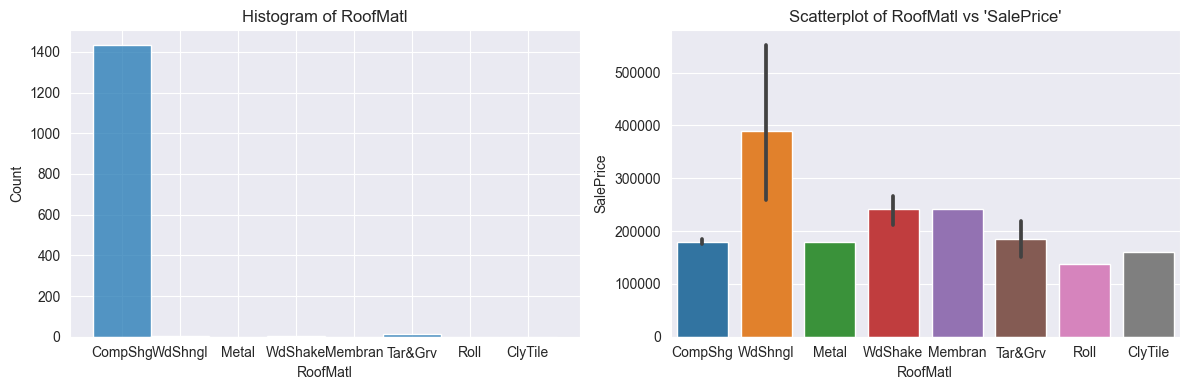

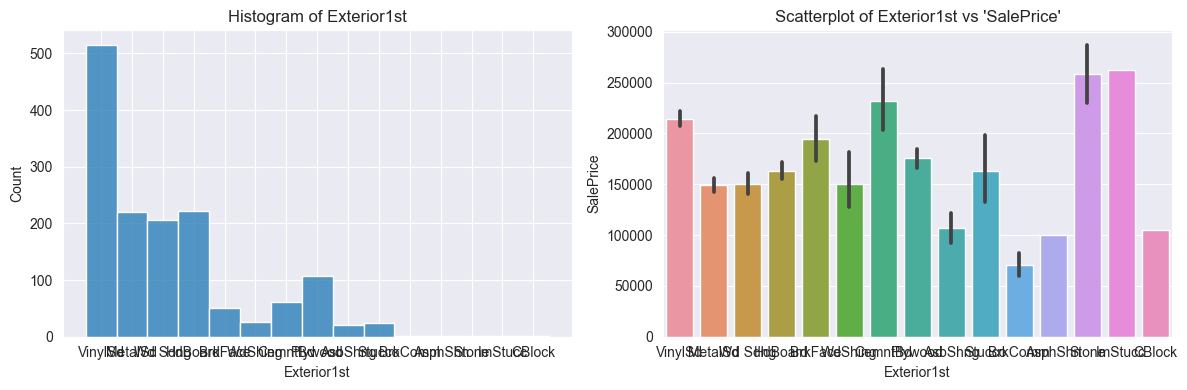

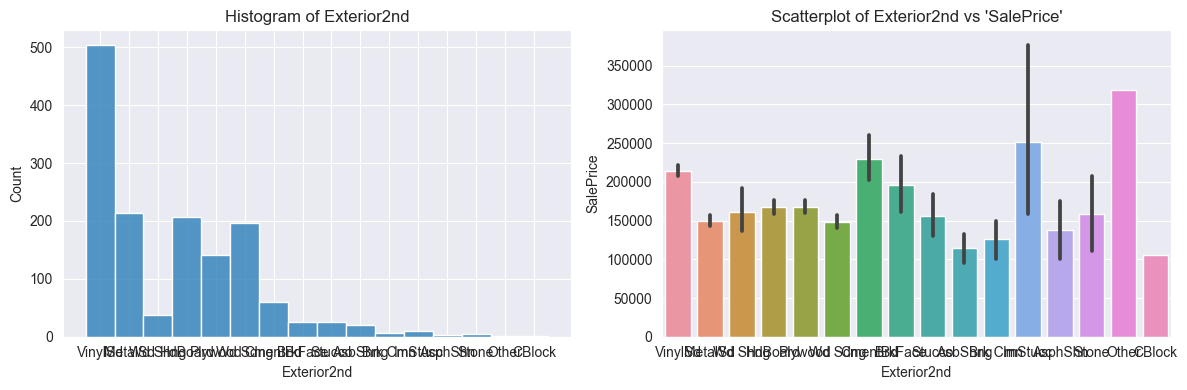

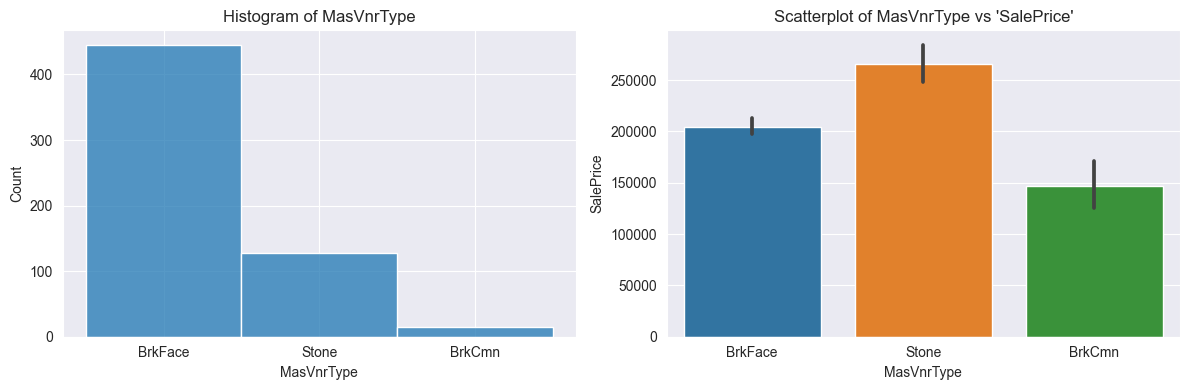

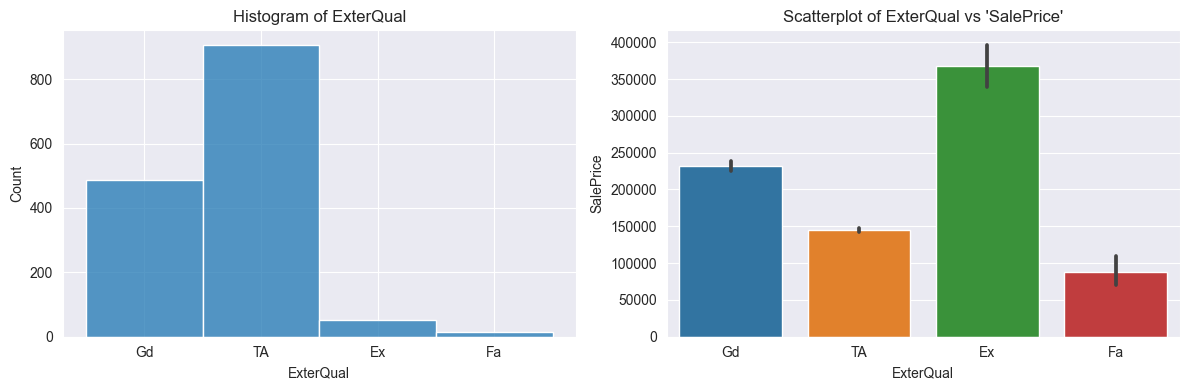

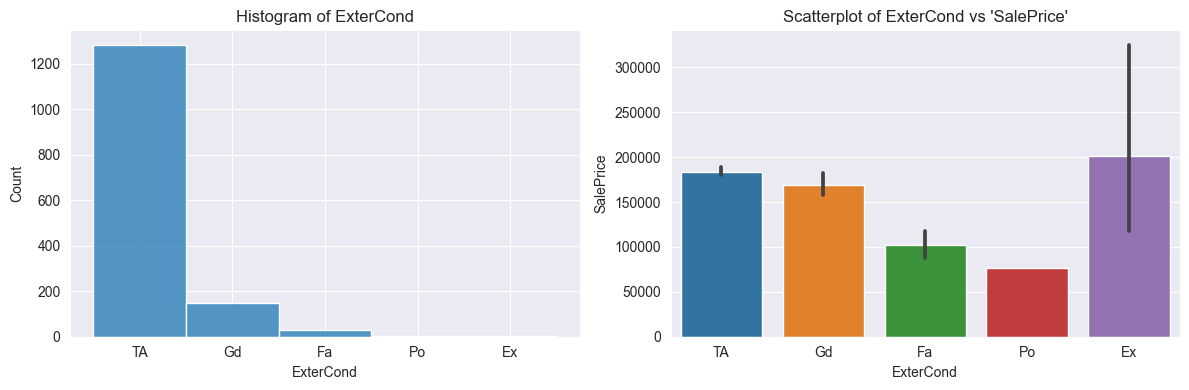

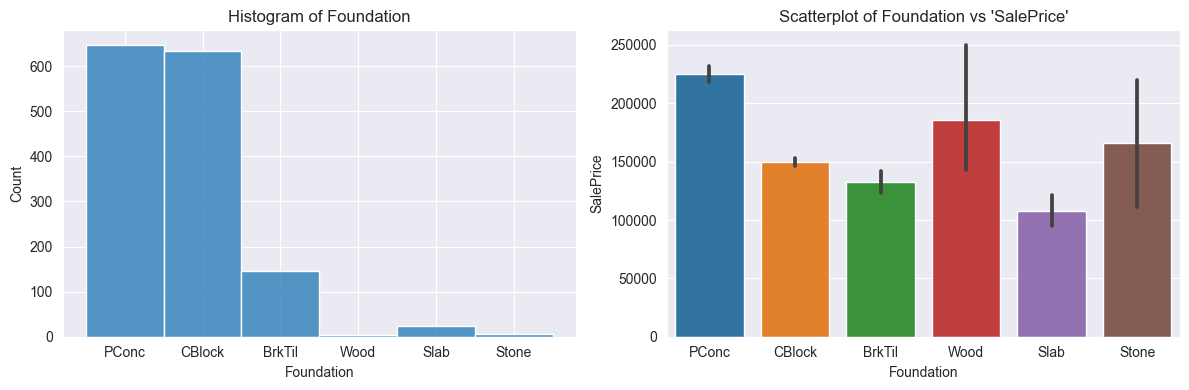

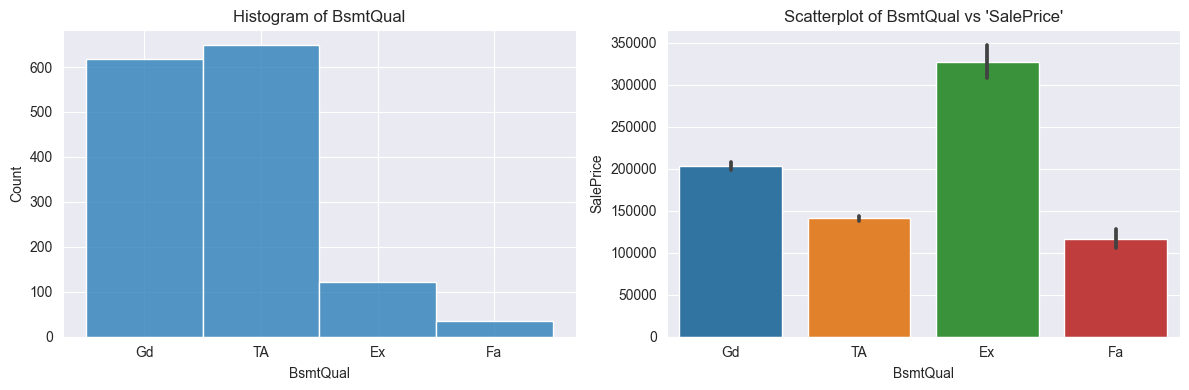

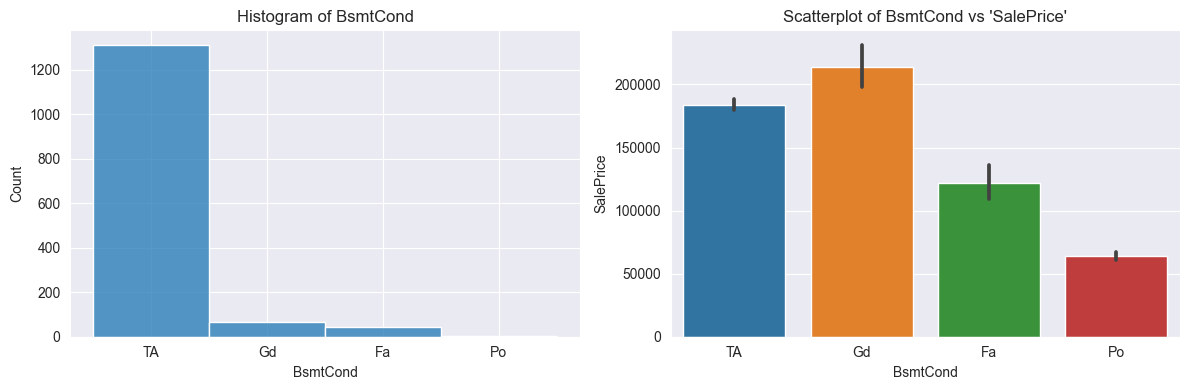

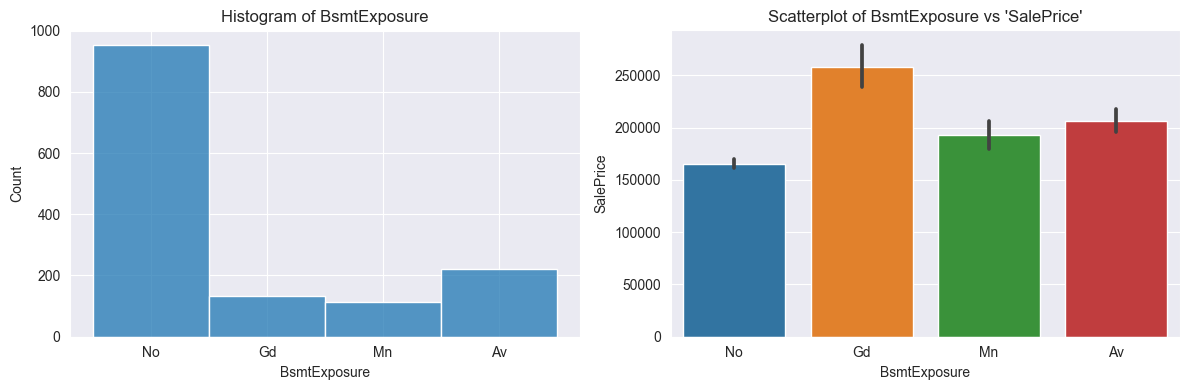

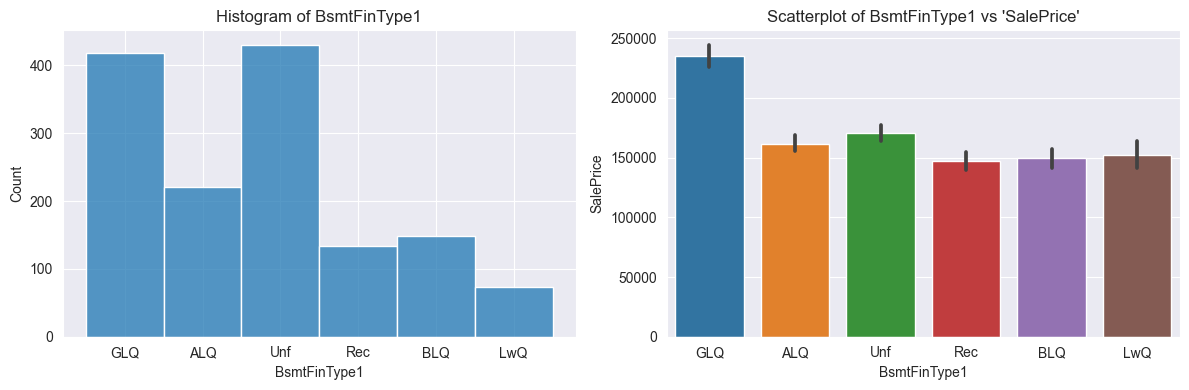

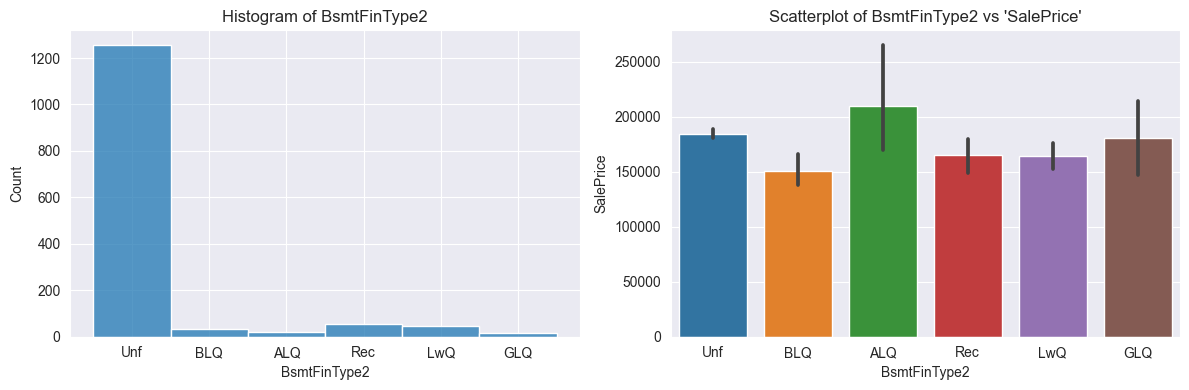

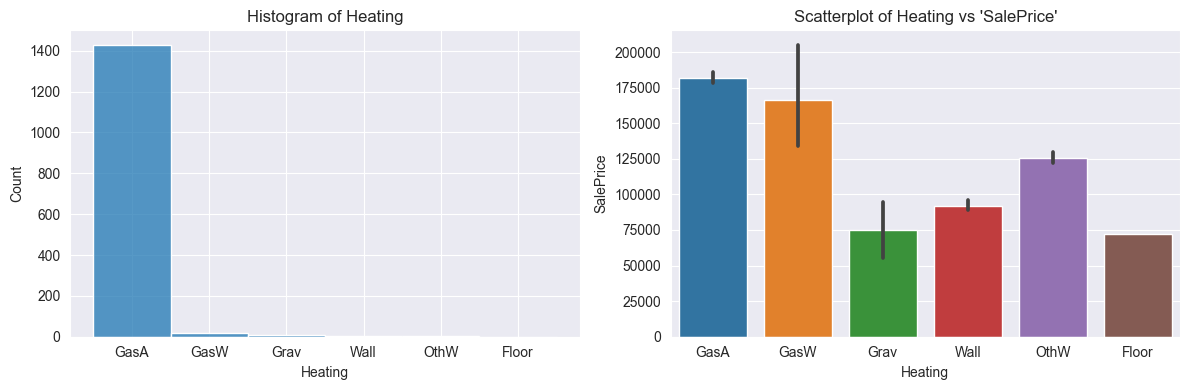

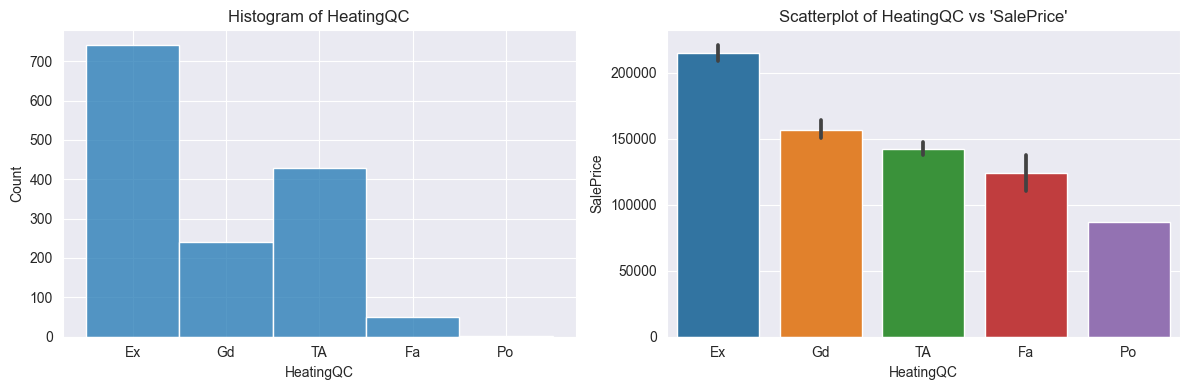

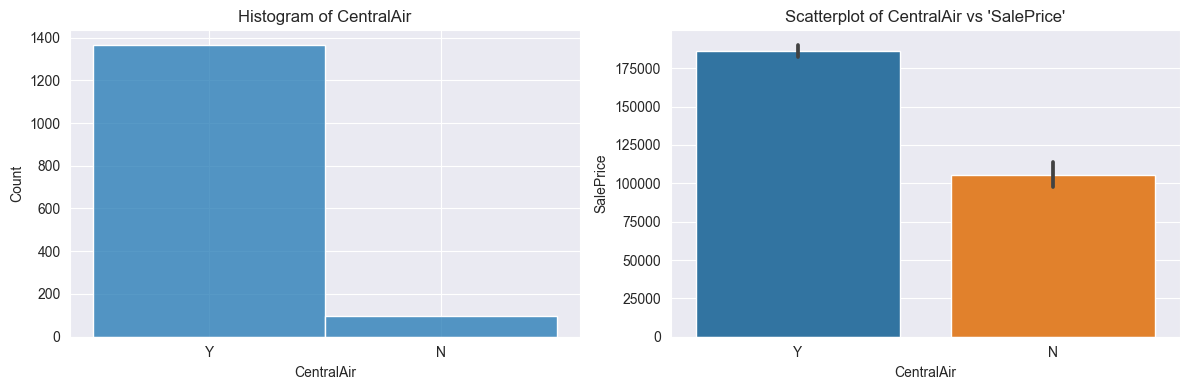

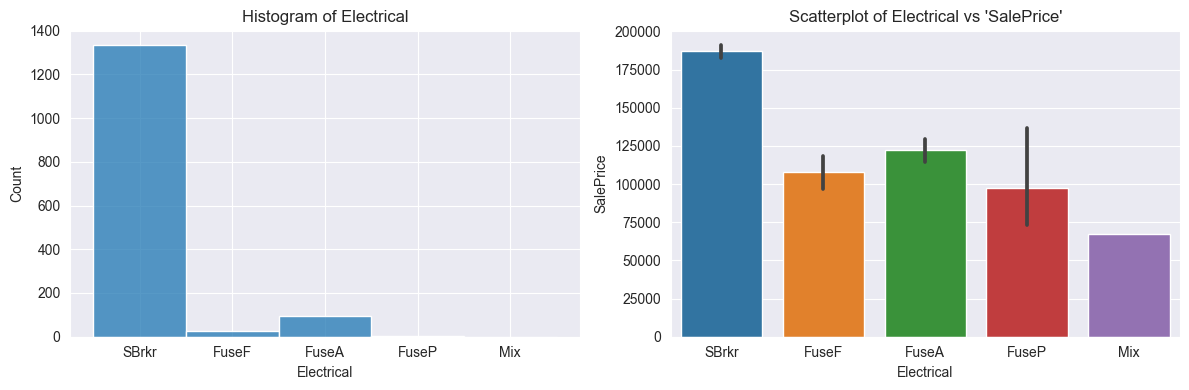

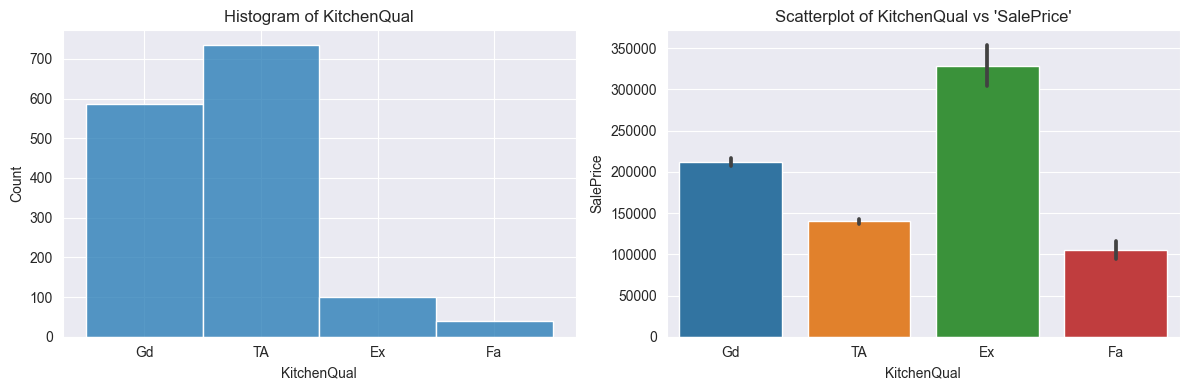

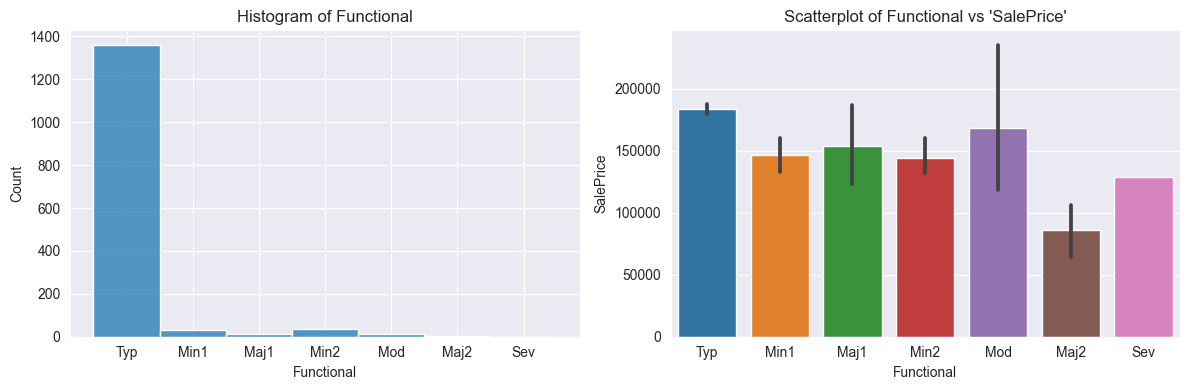

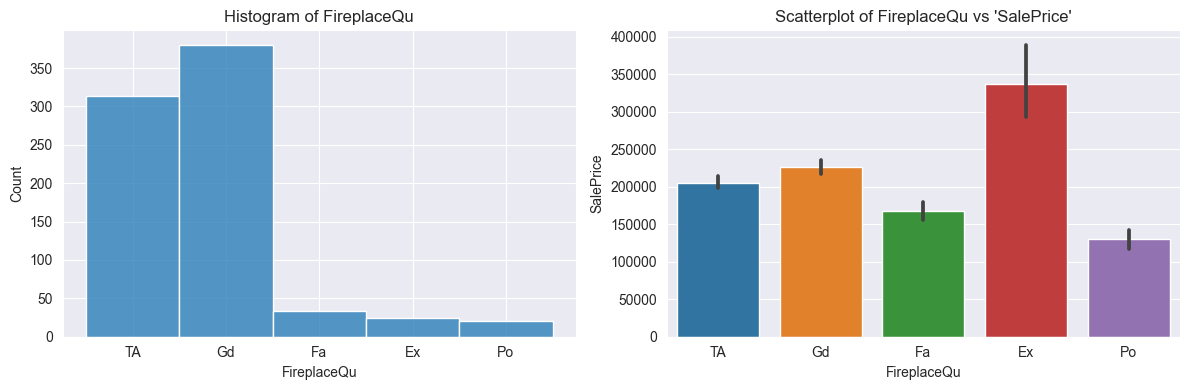

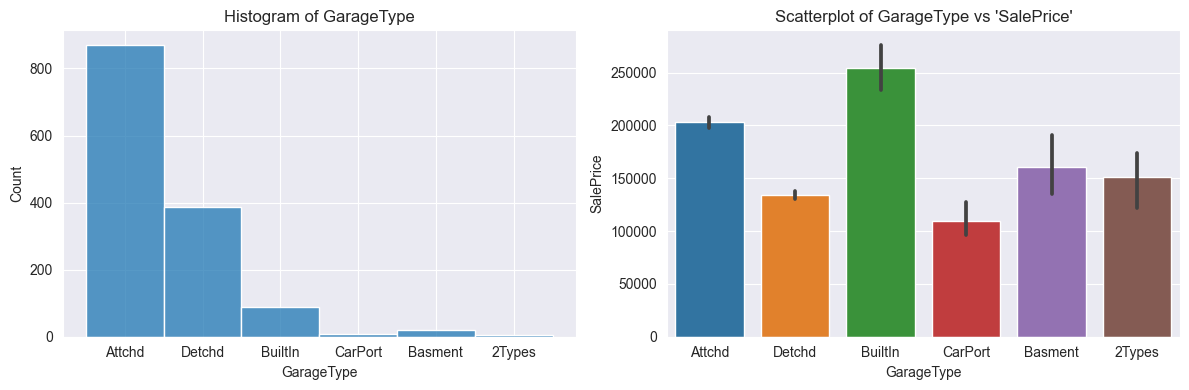

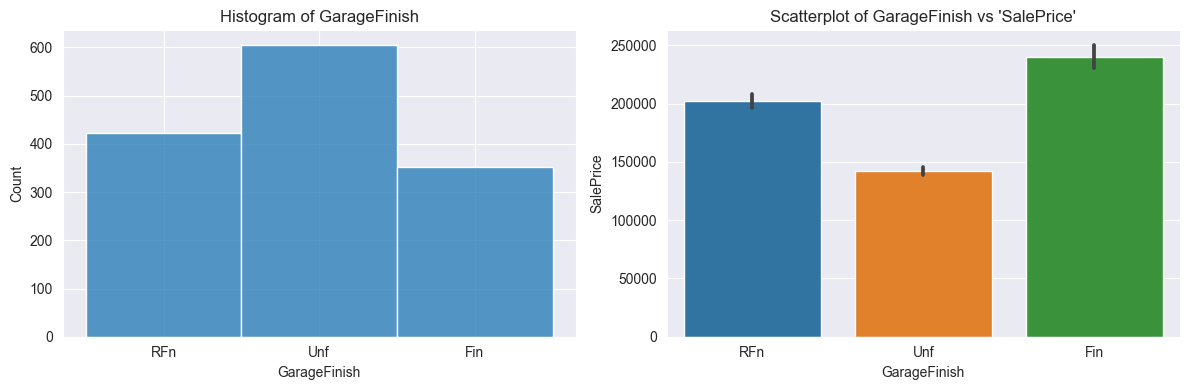

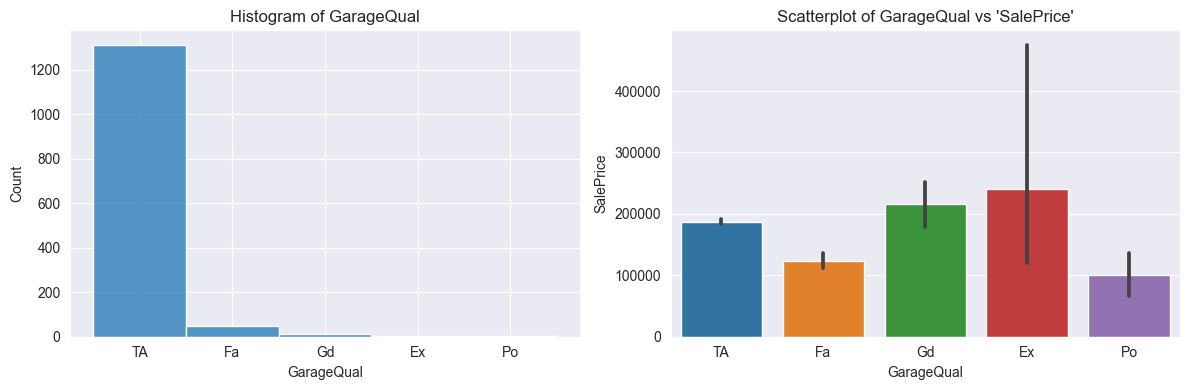

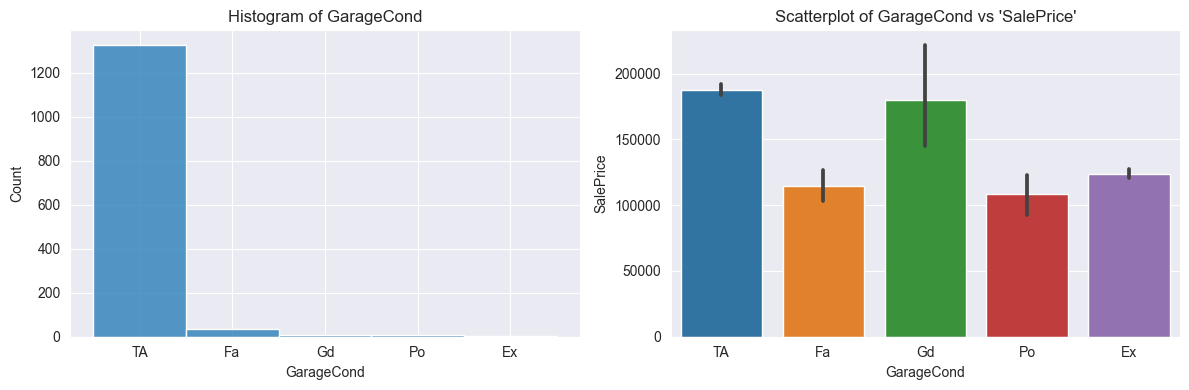

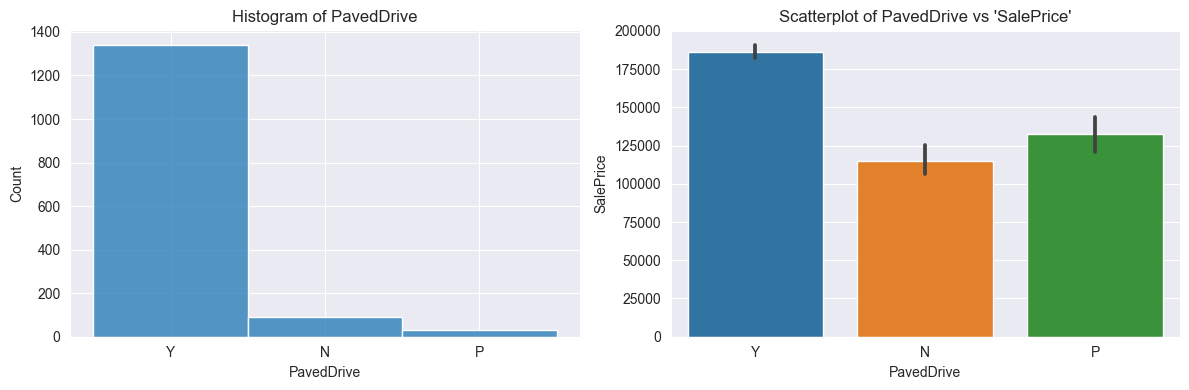

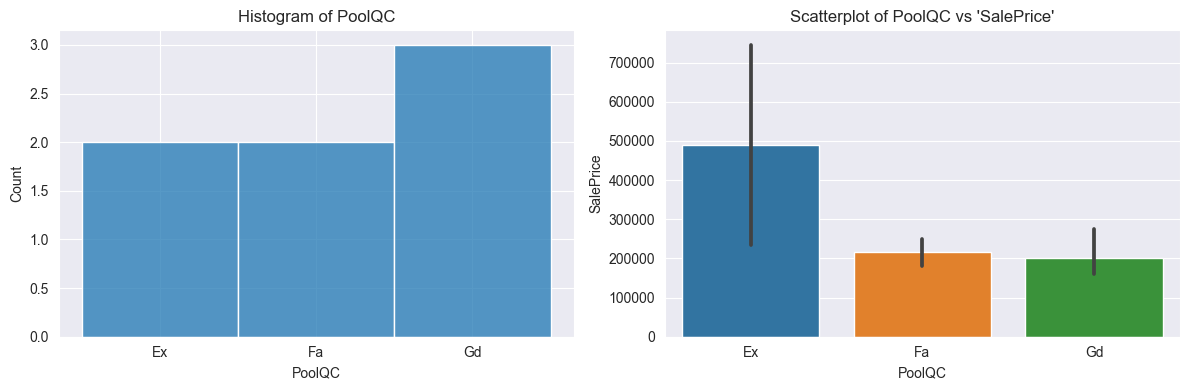

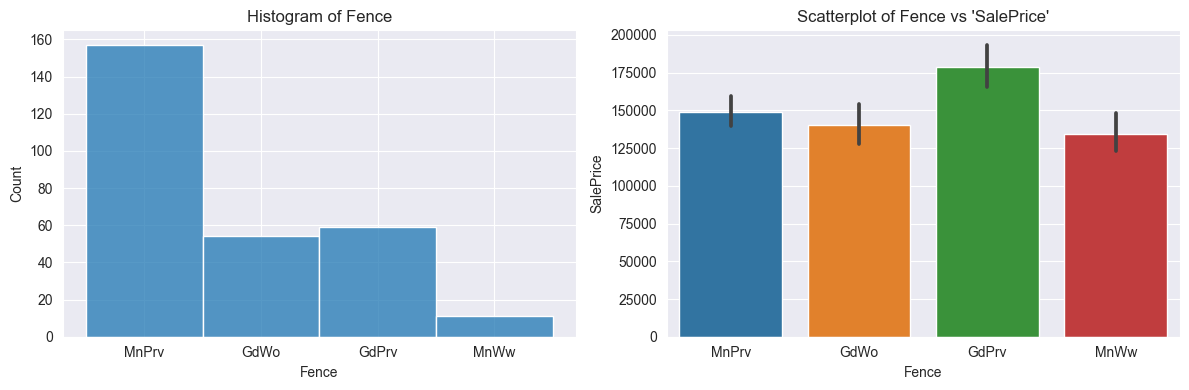

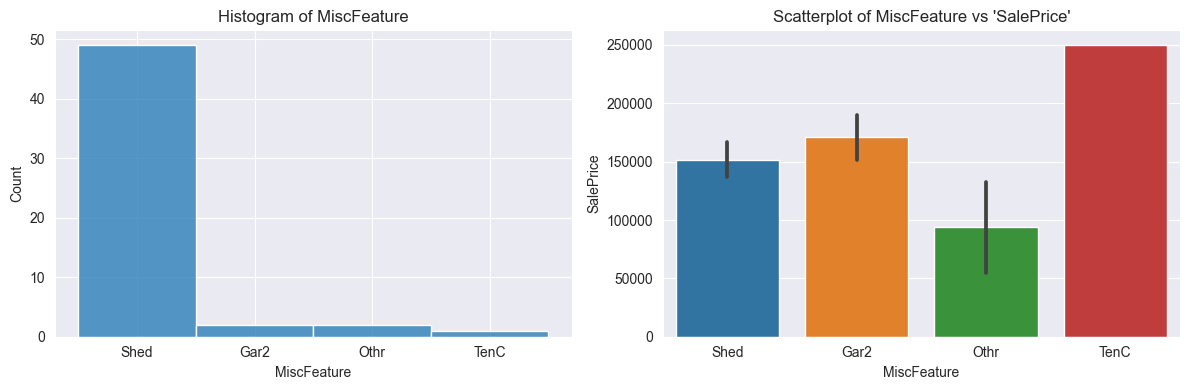

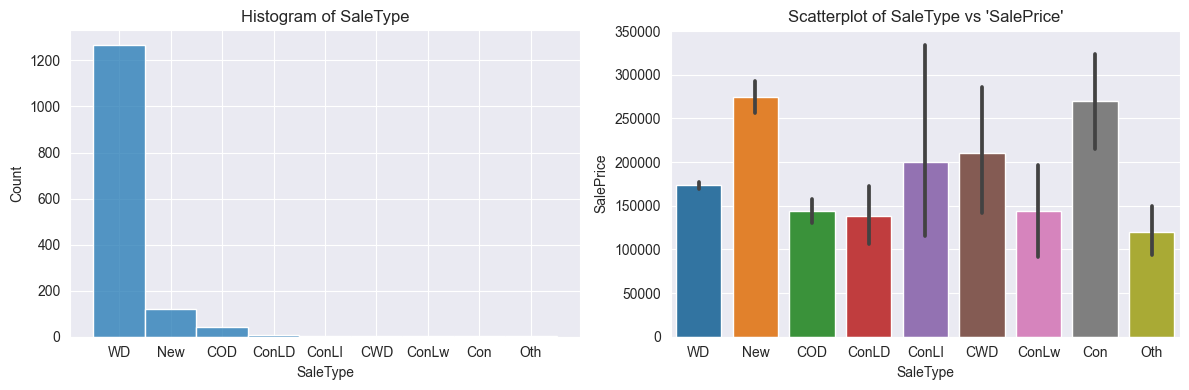

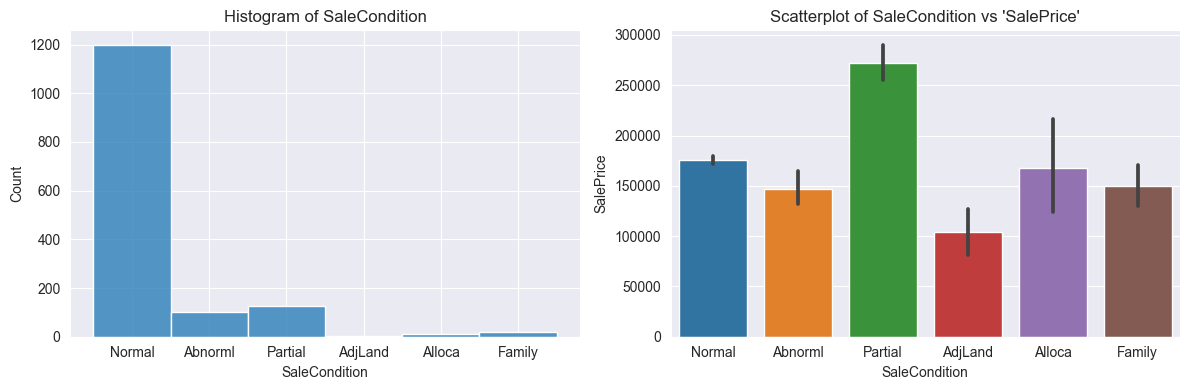

In [7]:
categorical_cols = [col for col in train_data.columns if train_data[col].dtype not in ['int64', 'float64']]
numerical_cols = [col for col in train_data.columns if train_data[col].dtype in ['int64', 'float64']]

for col in numerical_cols:
    # Set up the matplotlib figure
    f, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    sns.histplot(train_data[col], ax=axes[0], bins=100)
    axes[0].set_title(f'Histogram of {col}')

    # Scatterplot
    sns.scatterplot(x=train_data[col], y=train_data['SalePrice'], ax=axes[1])
    axes[1].set_title(f"Scatterplot of {col} vs 'SalePrice'")

    plt.tight_layout()
    plt.show()
    
for col in categorical_cols:
    # Set up the matplotlib figure
    f, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    sns.histplot(train_data[col], ax=axes[0], bins=100)
    axes[0].set_title(f'Histogram of {col}')

    # Scatterplot
    sns.barplot(x=train_data[col], y=train_data['SalePrice'], ax=axes[1])
    axes[1].set_title(f"Scatterplot of {col} vs 'SalePrice'")

    plt.tight_layout()
    plt.show()

### 2. Omitting Features

In [8]:
# Categorical and numerical
numerical_cols

suspected_categorical = [
    'MSSubClass', 
    'OverallQual', 
    'OverallCond', 
    'Fireplaces', 
    'MoSold', 
    'YrSold', 
    'FullBath', 
    'HalfBath', 
    'BsmtFullBath',
    'BsmtHalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    ]

not_important_numerical_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'LowQualFinSF', 'GarageCars', 'PoolArea', 'Id', 'Exterior2nd']

train_data = train_data.drop(not_important_numerical_cols, axis=1)

#### Intuitions:
- Several features don't seem to be main factors in a house sale: LotFrontage, BsmtFinSF1, BsmtFinSF2, MasVnrArea, Exterior2nd, etc.
- Some features are not relevant to most houses, and the data shows how unreliable it is to take them into account: PoolArea, MasVnrArea, etc.
- GarageCars - is identical with GarageArea (I decide to try to not include it, since it influenced previous output models too much).

In [9]:
categorical_cols = [col for col in train_data.columns if train_data[col].dtype not in ['int64', 'float64']]

numerical_cols = [col for col in train_data.columns if train_data[col].dtype in ['int64', 'float64']]

numerical_cols = [col for col in numerical_cols if col not in suspected_categorical]

In [10]:
categorical_cols.extend(suspected_categorical)

not_important_categorical_cols = [
    'LandSlope', 
    'HouseStyle', 
    'RoofMatl', 
    'MasVnrType', 
    'ExterQual', 
    'ExterCond', 
    'Foundation', 
    'BsmtExposure', 
    'BsmtFinType1',
    'BsmtFinType2',
    'GarageFinish',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageYrBlt',
    'BsmtCond',
    'OverallCond',
    'GarageCond',
    'Alley',
    'PoolQC',
    'MiscFeature',
    'BsmtQual'
    ]

for col in not_important_categorical_cols:
    if col in categorical_cols:
        categorical_cols.remove(col)

train_data = train_data.drop(not_important_categorical_cols, axis=1)

In [11]:
all_cols = categorical_cols + numerical_cols

len(train_data.columns) == len(all_cols)

False

### 3. Dealing with Nulls

In [12]:
train_data.isnull().sum().sort_index()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
BldgType            0
BsmtFullBath        0
BsmtHalfBath        0
BsmtUnfSF           0
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
Exterior1st         0
Fence            1179
Fireplaces          0
FullBath            0
GarageArea          0
GarageQual         81
GrLivArea           0
HalfBath            0
Heating             0
HeatingQC           0
KitchenAbvGr        0
KitchenQual         0
LandContour         0
LotArea             0
LotConfig           0
LotShape            0
MSSubClass          0
MSZoning            0
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallQual         0
PavedDrive          0
RoofStyle           0
SaleCondition       0
SalePrice           0
SaleType            0
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
TotalBsmtSF         0
Utilities 

- Only two columns with nulls: 'Fence' and 'GarageQual' - in both cases the null values should just be none (the lack of this feature).

In [13]:
train_data = train_data.fillna('None')

In [14]:
# Reset categorical and numerical

categorical_cols = [col for col in categorical_cols if col in train_data.columns]

numerical_cols = [col for col in numerical_cols if col in train_data.columns]

all_cols = categorical_cols + numerical_cols

len(all_cols) == len(train_data.columns)

True

In [15]:
# Delete the target
all_cols.remove('SalePrice')

In [16]:
test_data = test_data[all_cols]

test_data.isnull().sum().sort_index()

1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
BedroomAbvGr        0
BldgType            0
BsmtFullBath        2
BsmtHalfBath        2
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          0
EnclosedPorch       0
Exterior1st         1
Fence            1169
Fireplaces          0
FullBath            0
GarageArea          1
GarageQual         78
GrLivArea           0
HalfBath            0
Heating             0
HeatingQC           0
KitchenAbvGr        0
KitchenQual         1
LandContour         0
LotArea             0
LotConfig           0
LotShape            0
MSSubClass          0
MSZoning            4
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallQual         0
PavedDrive          0
RoofStyle           0
SaleCondition       0
SaleType            1
ScreenPorch         0
Street              0
TotRmsAbvGrd        0
TotalBsmtSF         1
Utilities           2
WoodDeckSF

- the same two columns are again prominent. I apply the same methods to them.
- The rest of the null values are few and will be dealt with by the imputer.

In [17]:
test_data[['Fence', 'GarageQual']] = test_data[['Fence', 'GarageQual']].fillna('None')

## Building Enhanced Model

In [18]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot)
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)

# Full data pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

In [19]:
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']

In [20]:
numerical_cols.remove('SalePrice')

In [21]:
# Base RF model
rf_pipeline.fit(X, y)

# Access model from pipeline
model = rf_pipeline.named_steps['model']

# Access preprocessor from pipeline
preprocessor = rf_pipeline.named_steps['preprocessor']

# Extract transformed categorical columns from preprocessor
categorical_cols_transformed = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine transformed categorical columns and numerical columns
new_cols = list(numerical_cols) + list(categorical_cols_transformed)

# Extract transformed data from preprocessor
X_transformed_data = preprocessor.transform(X)

# Reconstitute DataFrame after preprocessing
X_transformed = pd.DataFrame(X_transformed_data, columns=new_cols)

# Cross-Validation
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(model, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.86064646 0.82308854 0.87143815 0.88752395 0.7936351 ], scores average: (0.8472664416448416, 'std: ', 0.03419021704039961)


Cross-validation scores: [7.70991536e+08 1.16242678e+09 9.74215749e+08 5.69787336e+08
 1.38375288e+09], scores average: (972234856.0111401, 'std: ', 285652535.5950352)


In [22]:
# predictions = rf_pipeline.predict(test_data)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

In [23]:
len(X_transformed.columns)

230

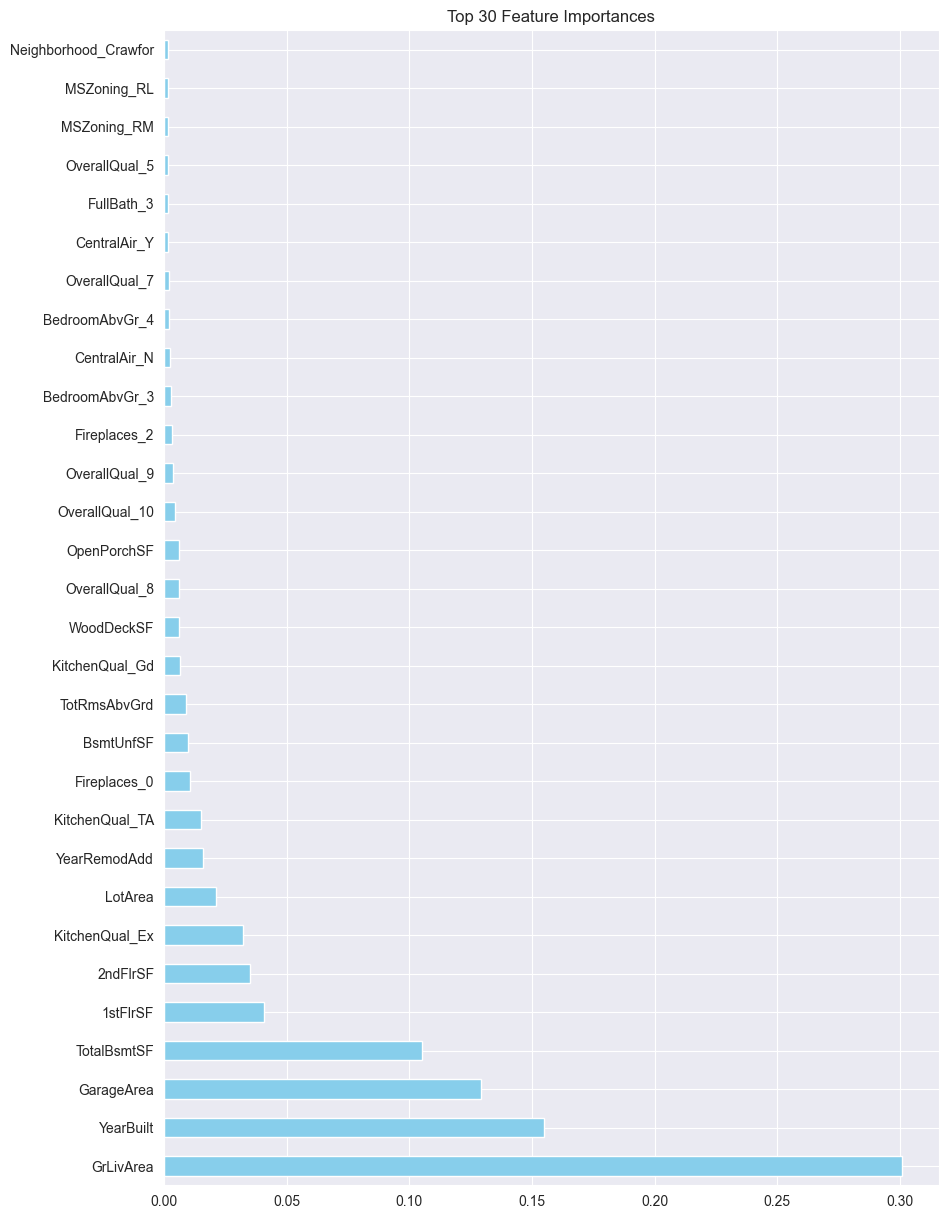

In [24]:
from feature_importance import plot_top_n_importance

plot_top_n_importance(DataFrame=X_transformed, model=model, top_n=30)

- Seems like the major players that were expected to positively influence prediction of sale prices indeed behave as expected.

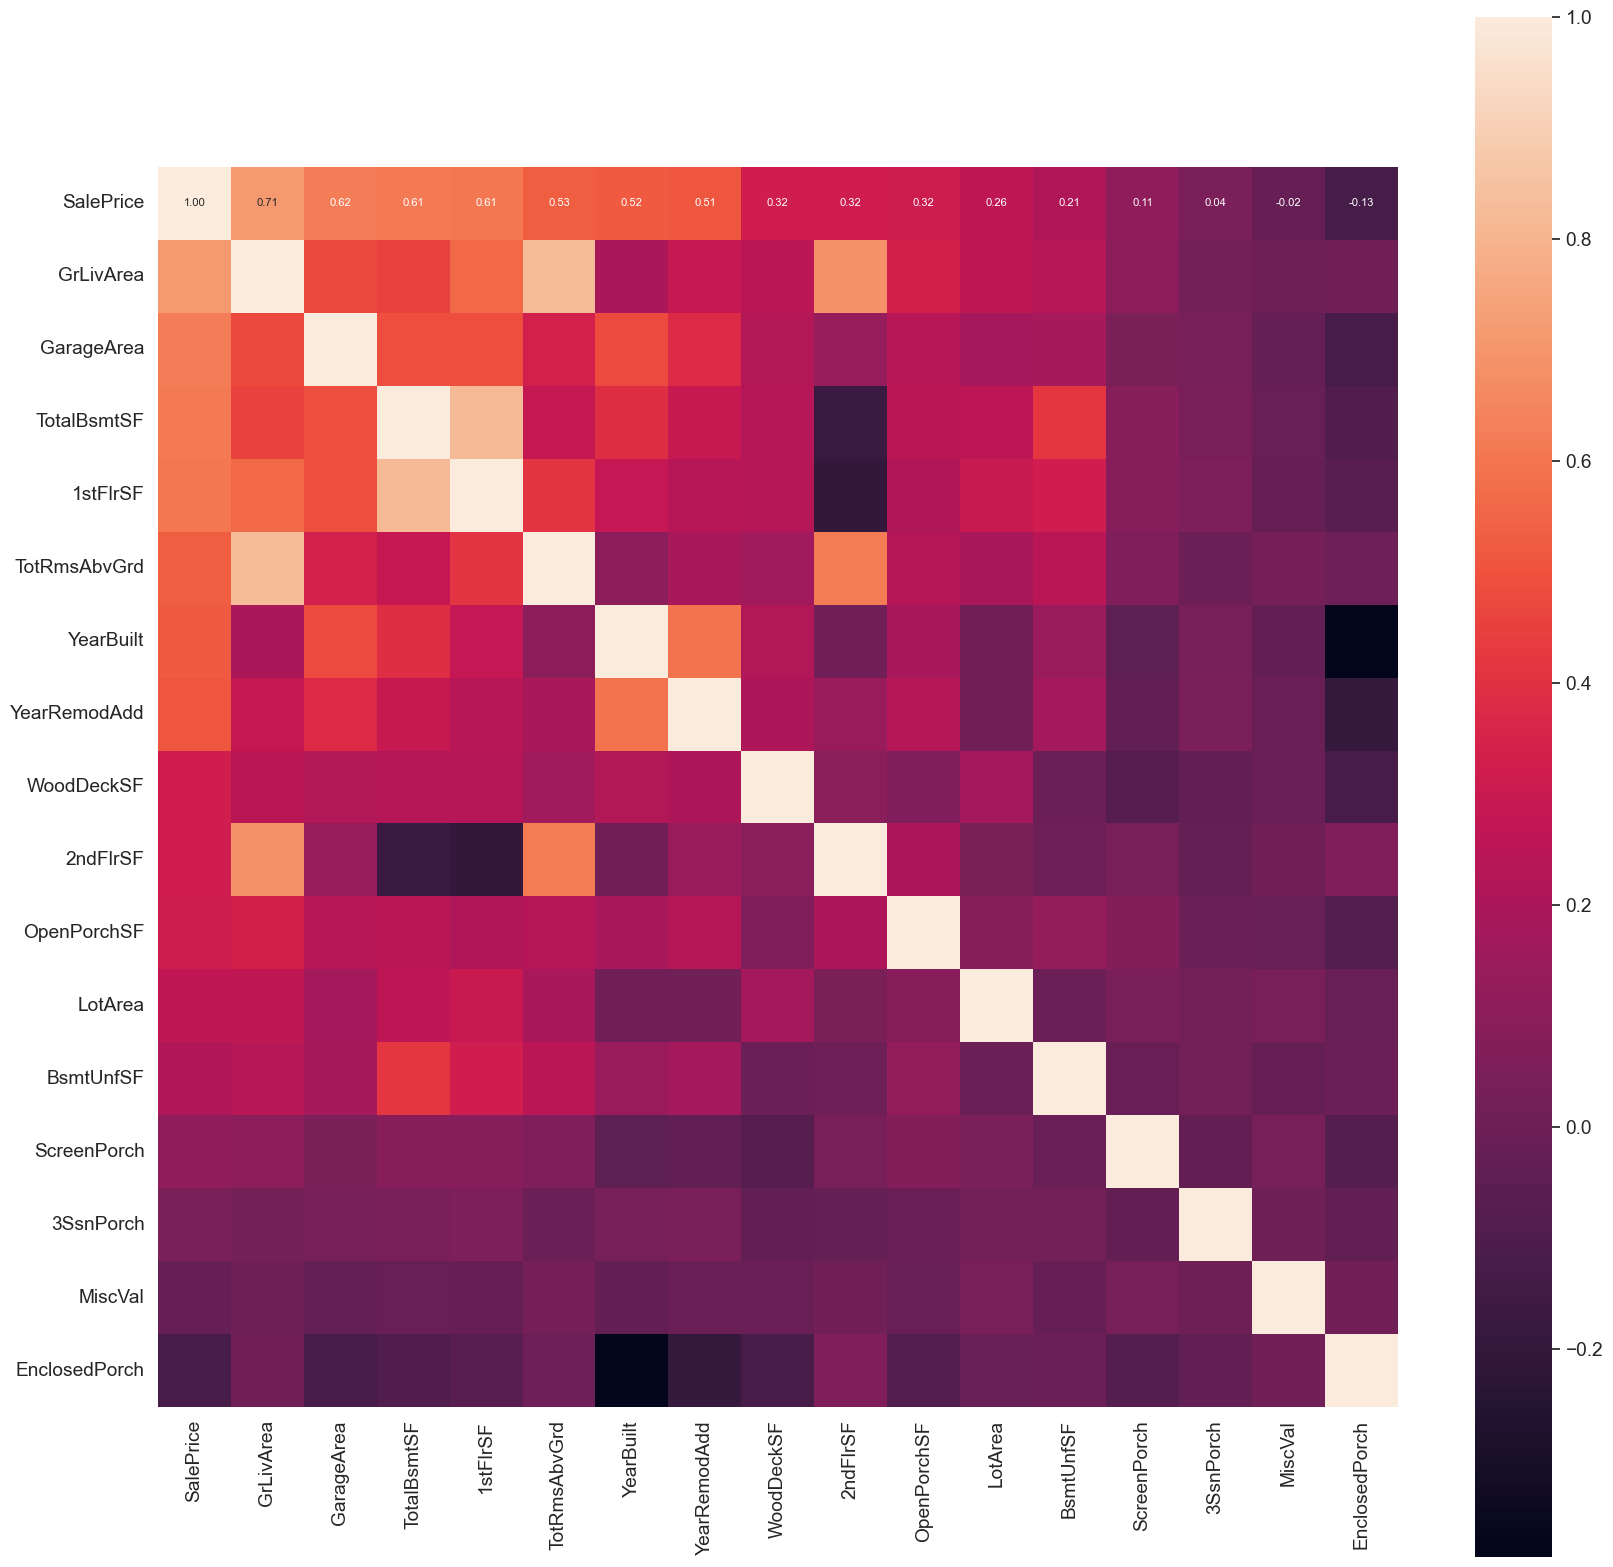

In [25]:
#saleprice correlation matrix
transformed_data = pd.concat([X_transformed, y], axis=1)
numerical_cols.append('SalePrice')

corrmat = transformed_data[numerical_cols].corr()
X_trans_target = pd.concat([X_transformed, y], axis=1)

plt.figure(figsize=(20, 20))
k = 23 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X_trans_target[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

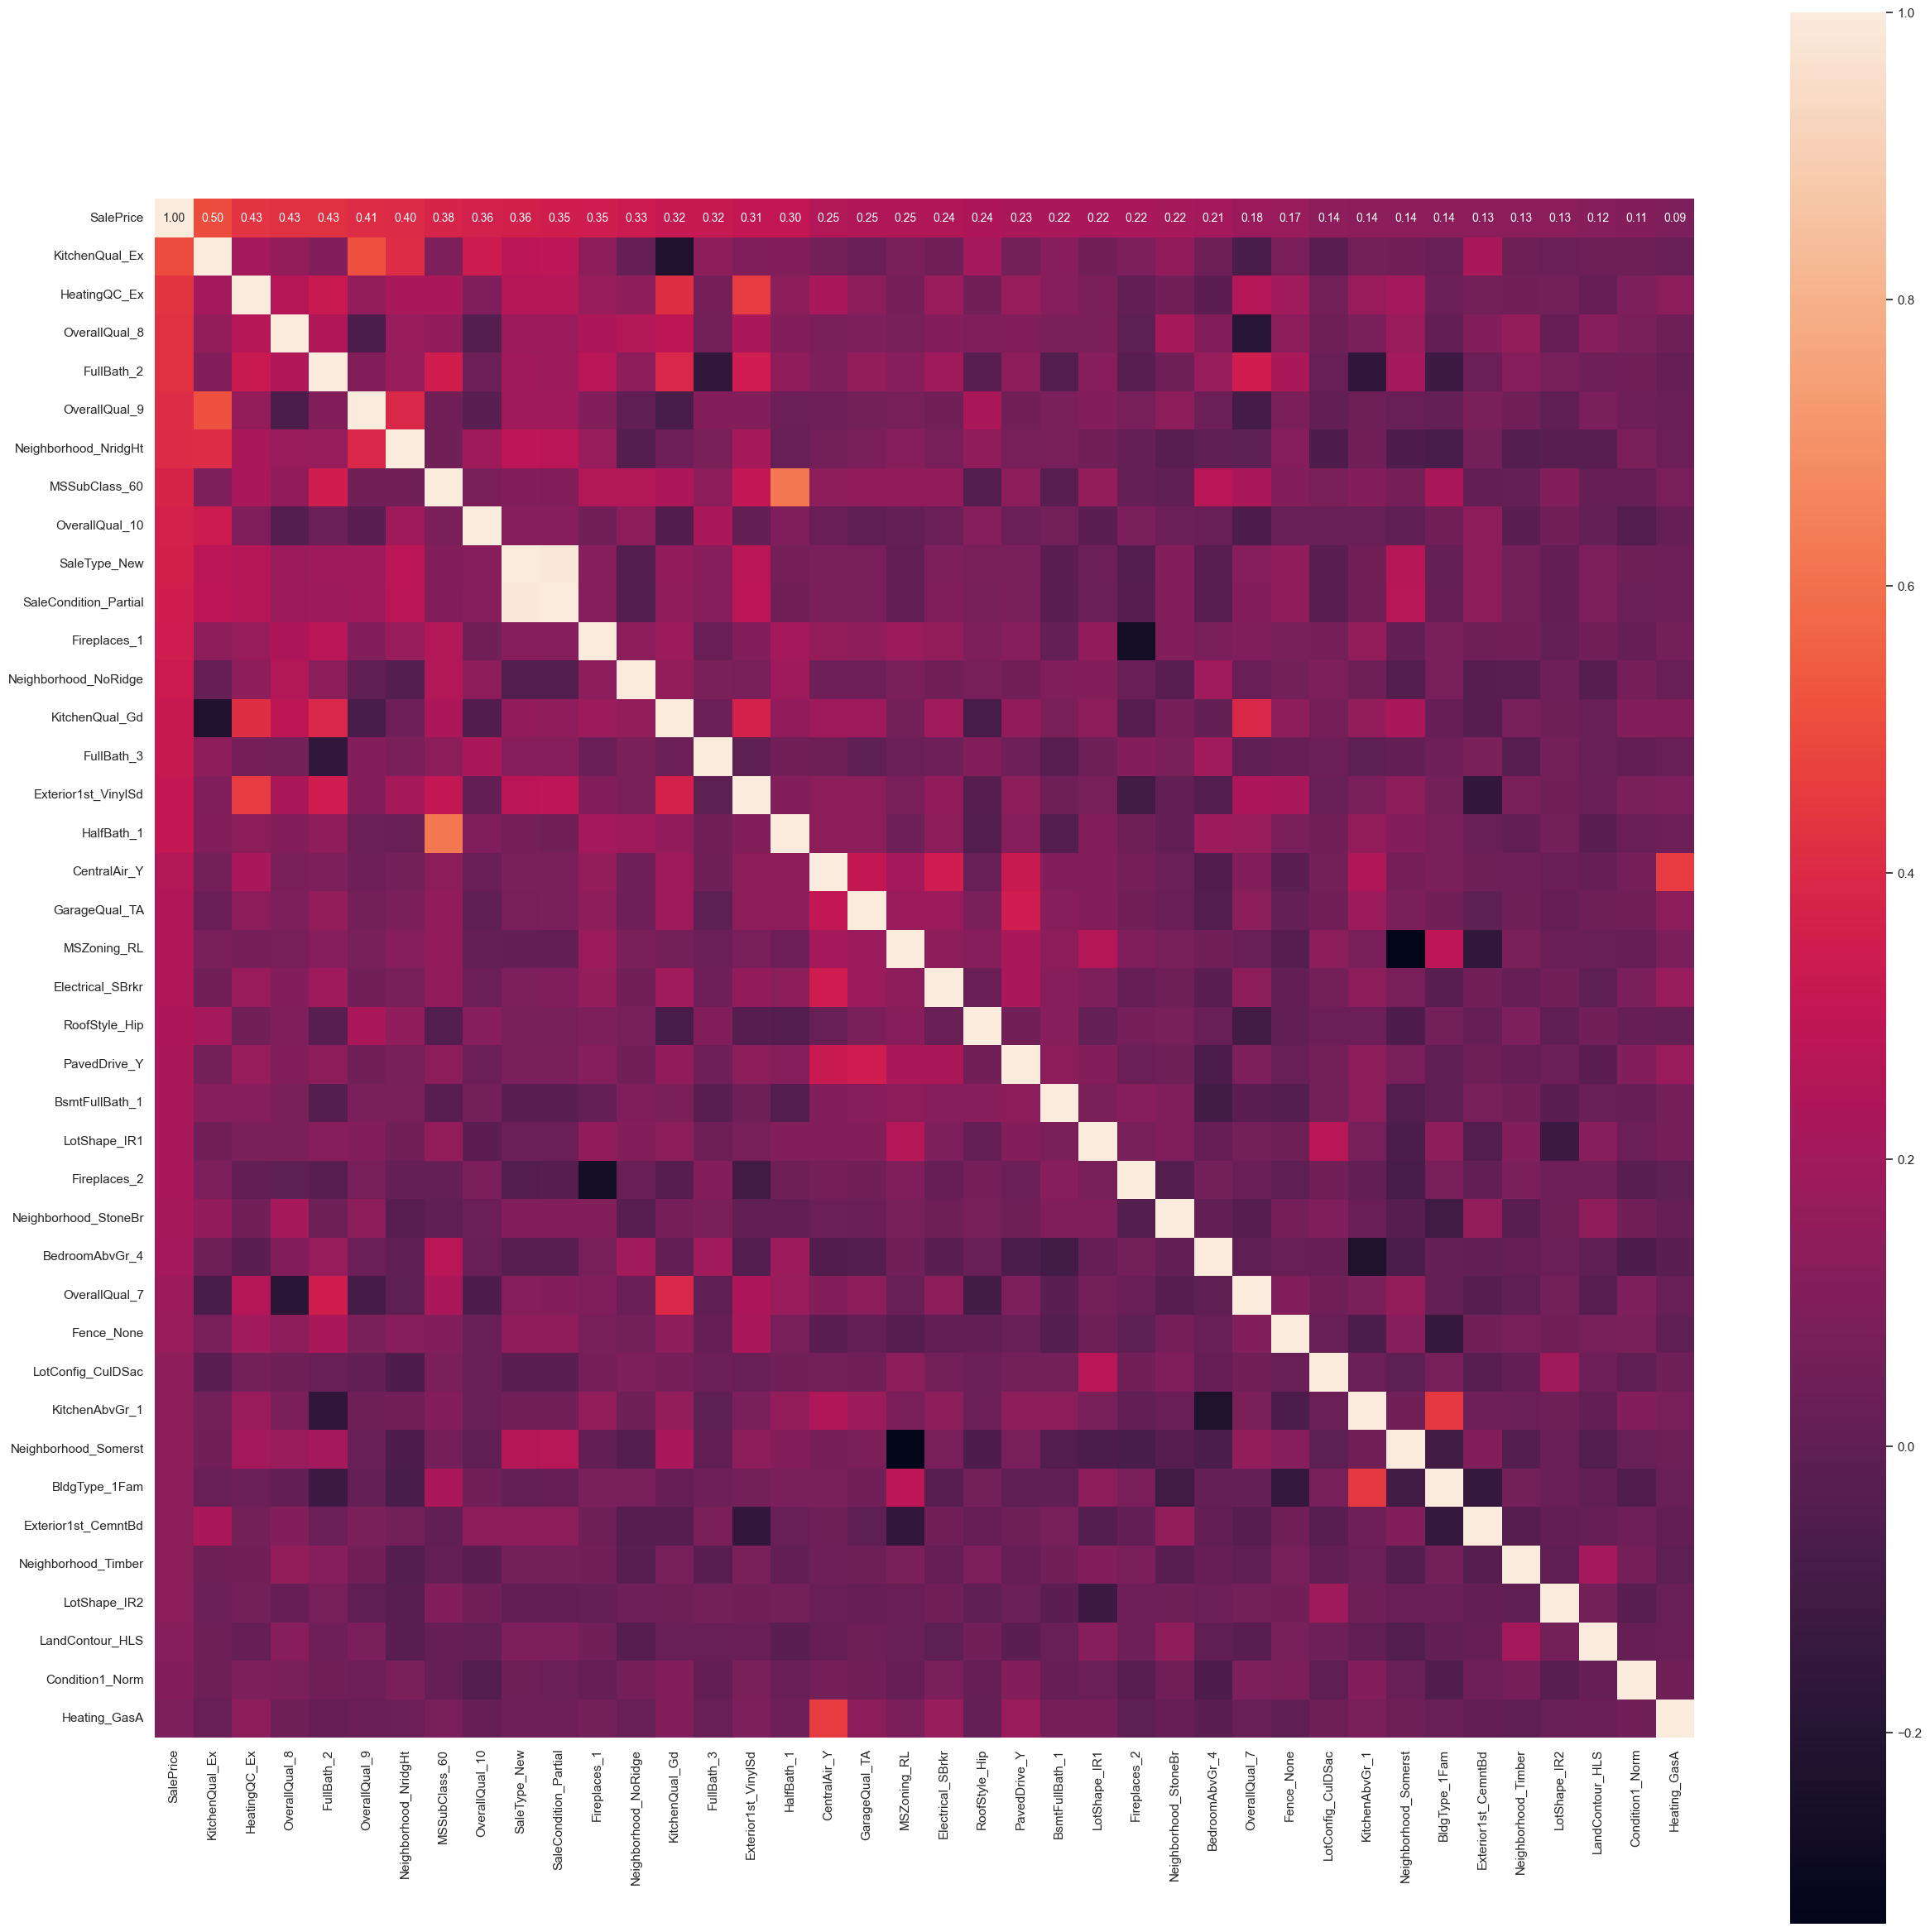

In [26]:
numerical_cols.remove('SalePrice')
transformed_data_categorical = X_transformed.drop(numerical_cols, axis=1)
transformed_data_categorical = pd.concat([transformed_data_categorical, y], axis=1)

#saleprice correlation matrix - categorical
corrmat_categorical = transformed_data_categorical.corr()
corrmat_categorical = corrmat_categorical[corrmat_categorical.columns.sort_values()].sort_index()

plt.figure(figsize=(30, 30))
k = 40 #number of variables for heatmap
cols = corrmat_categorical.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(transformed_data_categorical[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [27]:
print(numerical_cols)
print(categorical_cols)

['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'Exterior1st', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'GarageQual', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition', 'MSSubClass', 'OverallQual', 'Fireplaces', 'MoSold', 'YrSold', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr']


## Enhancing Even More

In [28]:
categorical_cols = [col for col in X.columns if X[col].dtype not in ['int64', 'float64']]
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numerical_cols = [col for col in numerical_cols if col not in suspected_categorical]
categorical_cols.extend(suspected_categorical)

for col in not_important_categorical_cols:
    if col in categorical_cols:
        categorical_cols.remove(col)

### 1. Creating New Features

- Creating 'estimated_price' via 'average_price_per_sqft'

In [29]:
# Average price per square feet + Estimated price

X['average_price_per_sqft'] = y / X['GrLivArea']

average_price_per_sqft = X['average_price_per_sqft'].mean()

X['estimated_price'] = X['GrLivArea'] * average_price_per_sqft

test_data['estimated_price'] = test_data['GrLivArea'] * average_price_per_sqft

X = X.drop(['average_price_per_sqft'], axis=1)

numerical_cols.append('estimated_price')

- Creating the flipside of 'BsmtUnfSF' - the finished part rather than the unfinished (the former has major coliniarity issues with important features, so I am trying to keep the information while deleting the feature)

In [30]:
# BsmtFinSF

X['BsmtFinSF'] = X['TotalBsmtSF'] - X['BsmtUnfSF']

test_data['BsmtFinSF'] = test_data['TotalBsmtSF'] - test_data['BsmtUnfSF']

numerical_cols.append('BsmtFinSF')

- '2ndFlrSF' is an important feature, but when it is 0, it means the house doesn't have a 2nd floor. To capture is information, I am creating an extra categorical feature.

In [31]:
X['2ndFlr'] = X['2ndFlrSF'].apply(lambda x: 'NO' if x == 0 else 'Yes')

test_data['2ndFlr'] = test_data['2ndFlrSF'].apply(lambda x: 'NO' if x == 0 else 'Yes')

categorical_cols.append('2ndFlr')

- This set of house features are either there or not, so it makes sense to convert them to categorical (they also don't have a lot of data).

In [32]:
extra_house_features = ['3SsnPorch', 'EnclosedPorch', 'MiscVal', 'OpenPorchSF', 'ScreenPorch', 'WoodDeckSF']

for feat in extra_house_features:
    X[feat] = X[feat].apply(lambda x: 'NO' if x == 0 else 'Yes')
    test_data[feat] = test_data[feat].apply(lambda x: 'NO' if x == 0 else 'Yes')
    
categorical_cols.extend(extra_house_features)
numerical_cols = [col for col in numerical_cols if col not in extra_house_features]

#### Rechecking the model

In [33]:
# Preprocessing for numerical data
numerical_transformer_2 = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot_2 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer_2 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot_2)
])

# Full column transformer
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer_2, numerical_cols),
        ('categorical', categorical_transformer_2, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model_2 = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)

# Full data pipeline
rf_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('model', rf_model_2)
])

In [34]:
rf_pipeline_2.fit(X, y)

# Access model from pipeline
model_2 = rf_pipeline_2.named_steps['model']

# Access preprocessor from pipeline
preprocessor_2 = rf_pipeline_2.named_steps['preprocessor']

# Extract transformed categorical columns from preprocessor
categorical_cols_transformed = preprocessor_2.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine transformed categorical columns and numerical columns
new_cols = list(numerical_cols) + list(categorical_cols_transformed)

# Extract transformed data from preprocessor
X_transformed_data = preprocessor_2.transform(X)

# Reconstitute DataFrame after preprocessing
X_transformed = pd.DataFrame(X_transformed_data, columns=new_cols)

# Cross-Validation
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(model_2, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.85775462 0.82686194 0.87180841 0.88720922 0.80734853], scores average: (0.8501965428740565, 'std: ', 0.02923898724370154)


Cross-validation scores: [7.86991056e+08 1.13763305e+09 9.71409939e+08 5.71381729e+08
 1.29179930e+09], scores average: (951843014.5012373, 'std: ', 253928350.71320498)


In [35]:
# predictions = rf_pipeline_2.predict(test_data)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

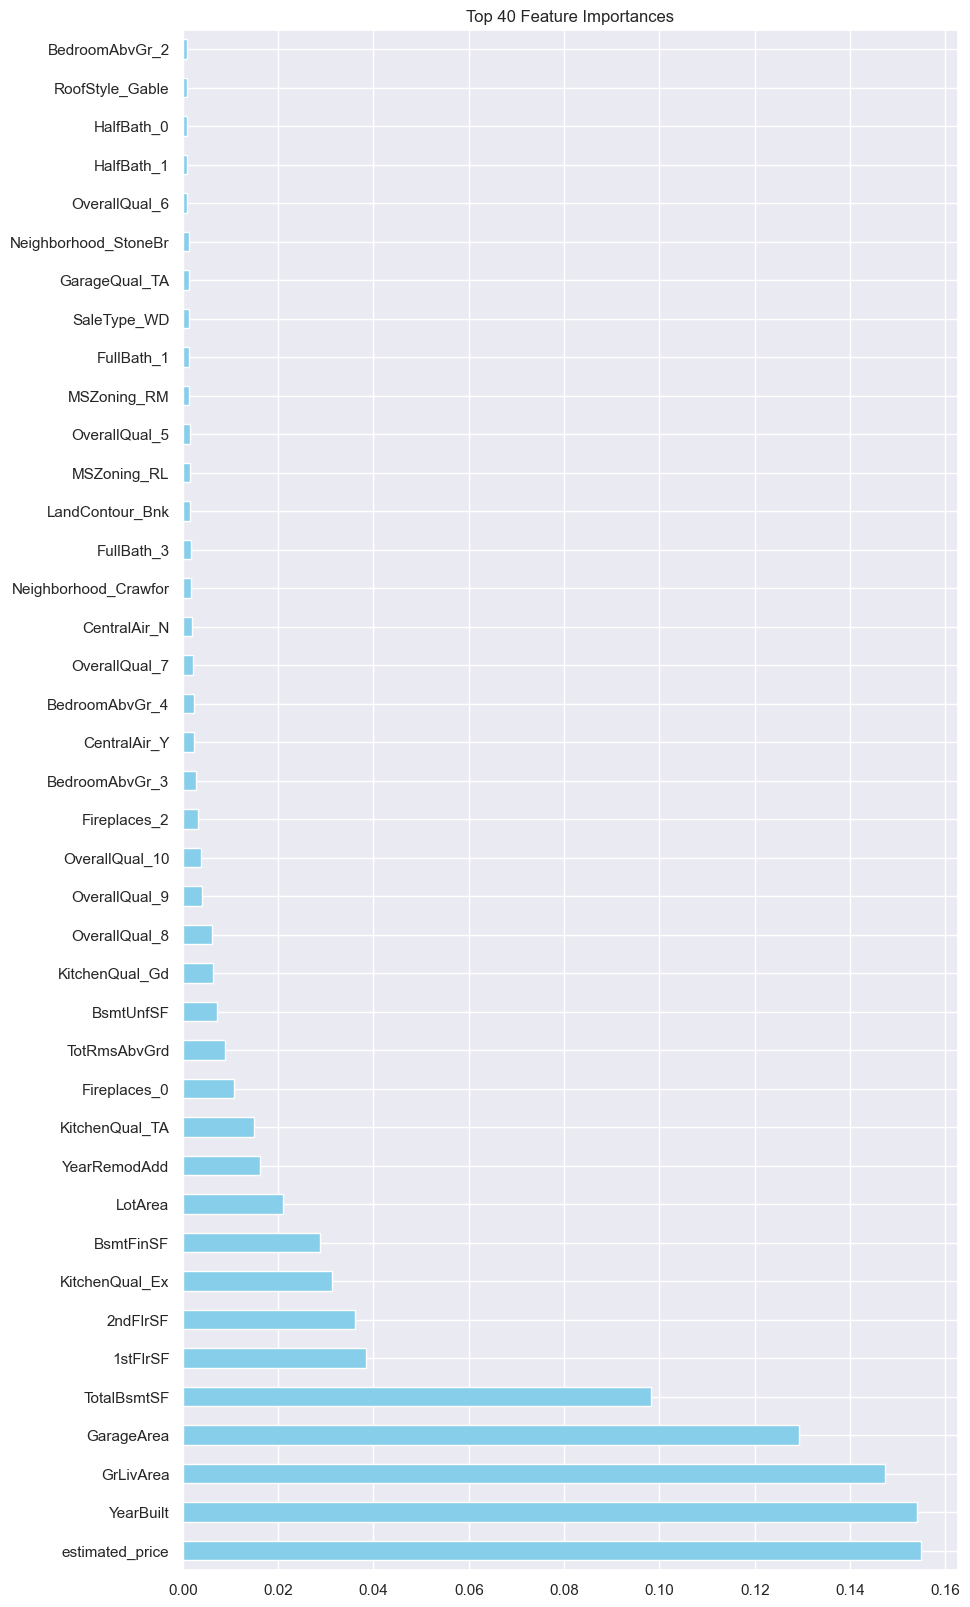

In [36]:
plot_top_n_importance(DataFrame=X_transformed, model=model_2, top_n=40)

In [37]:
data_transf = pd.concat([X_transformed, y], axis=1)
data_transf.columns

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea',
       ...
       'EnclosedPorch_Yes', 'MiscVal_NO', 'MiscVal_Yes', 'OpenPorchSF_NO',
       'OpenPorchSF_Yes', 'ScreenPorch_NO', 'ScreenPorch_Yes', 'WoodDeckSF_NO',
       'WoodDeckSF_Yes', 'SalePrice'],
      dtype='object', length=241)

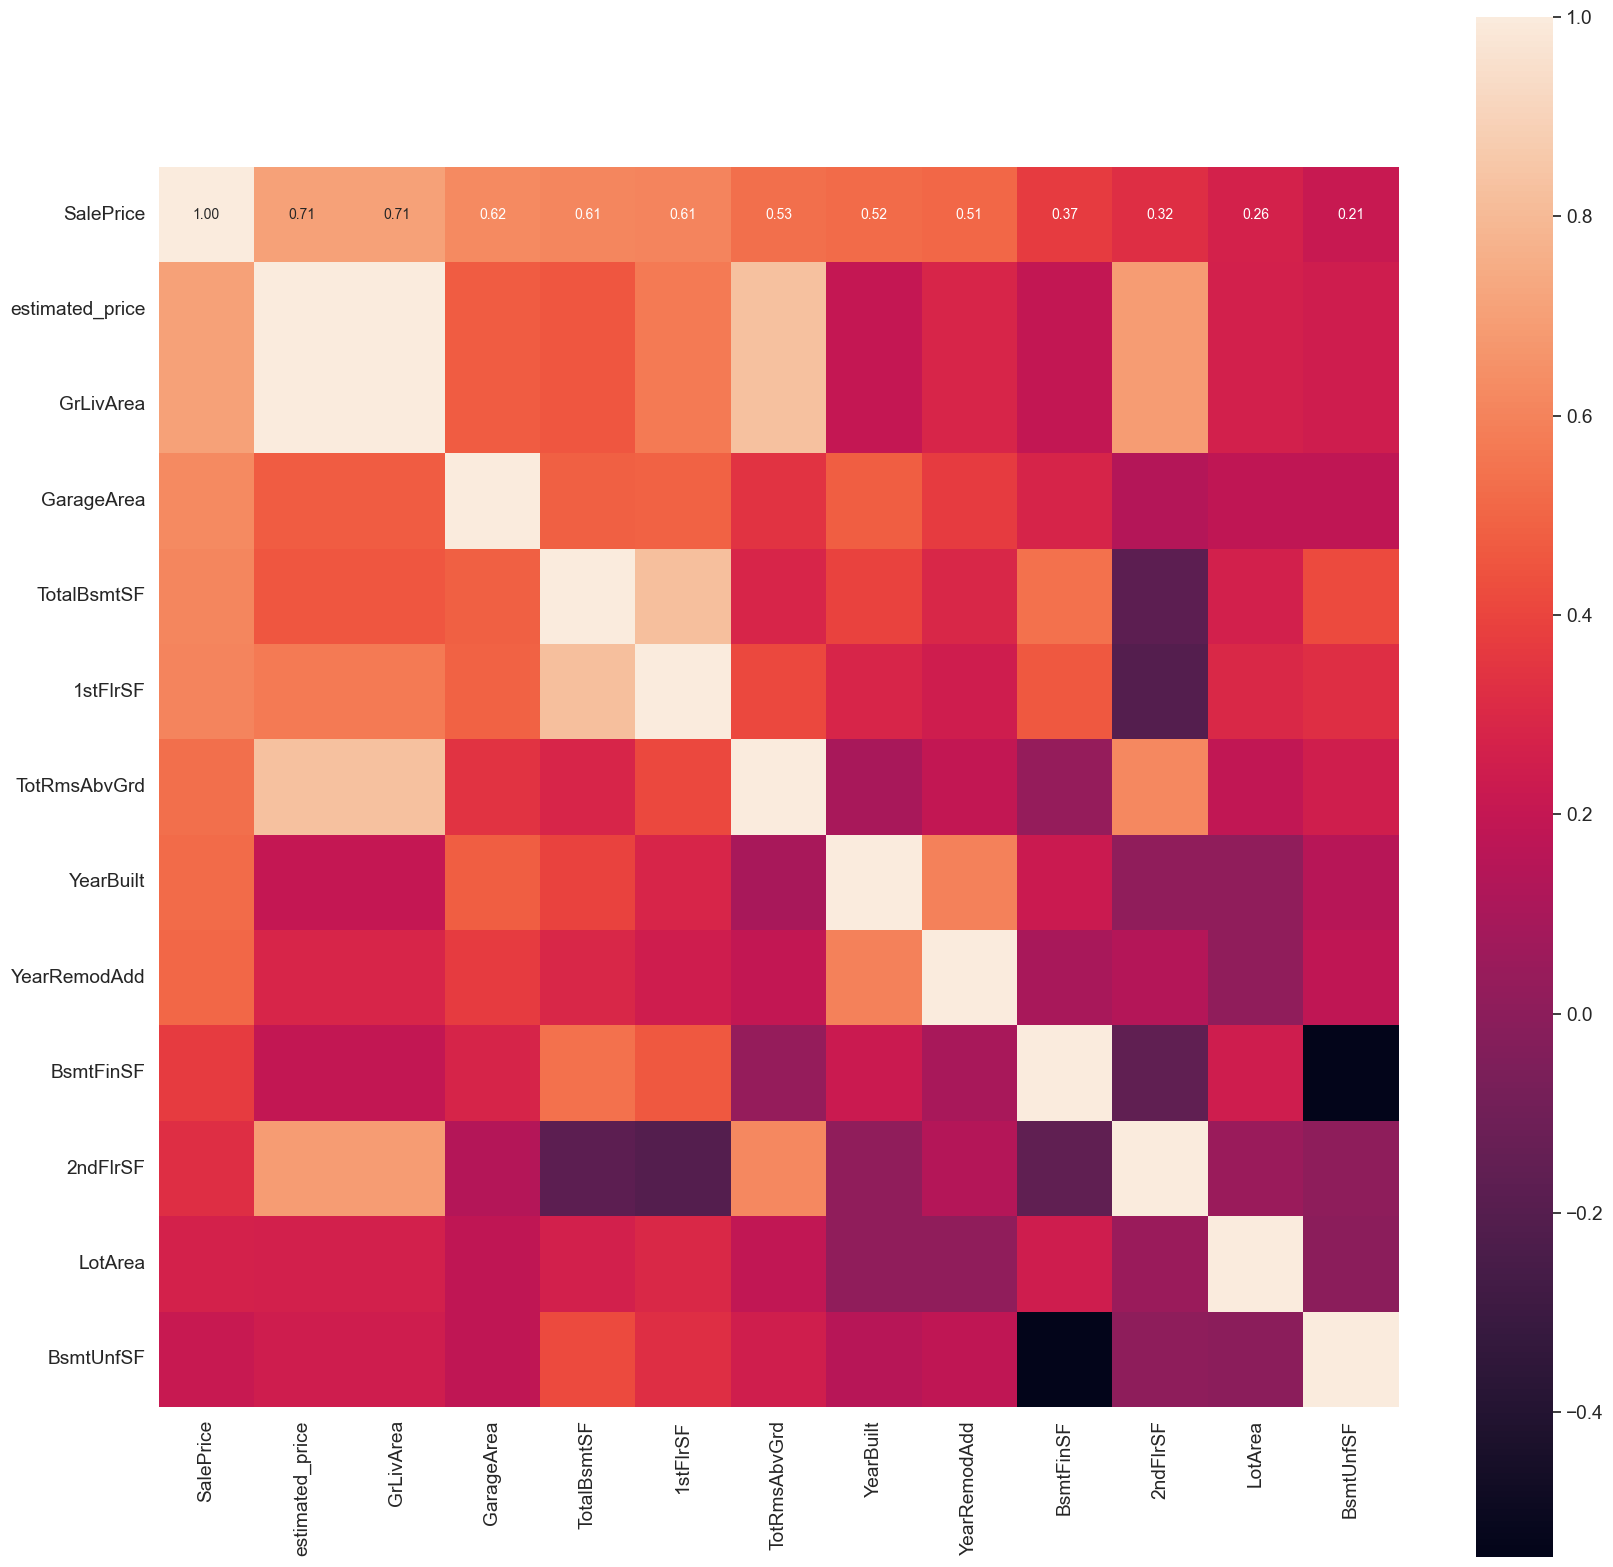

In [38]:
#saleprice correlation matrix
numerical_cols.extend(['SalePrice'])
corrmat = data_transf[numerical_cols].corr()

plt.figure(figsize=(20, 20))
k = 23 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_transf[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- 'TotRmsAbvGrd', 'BsmtUnfSF'

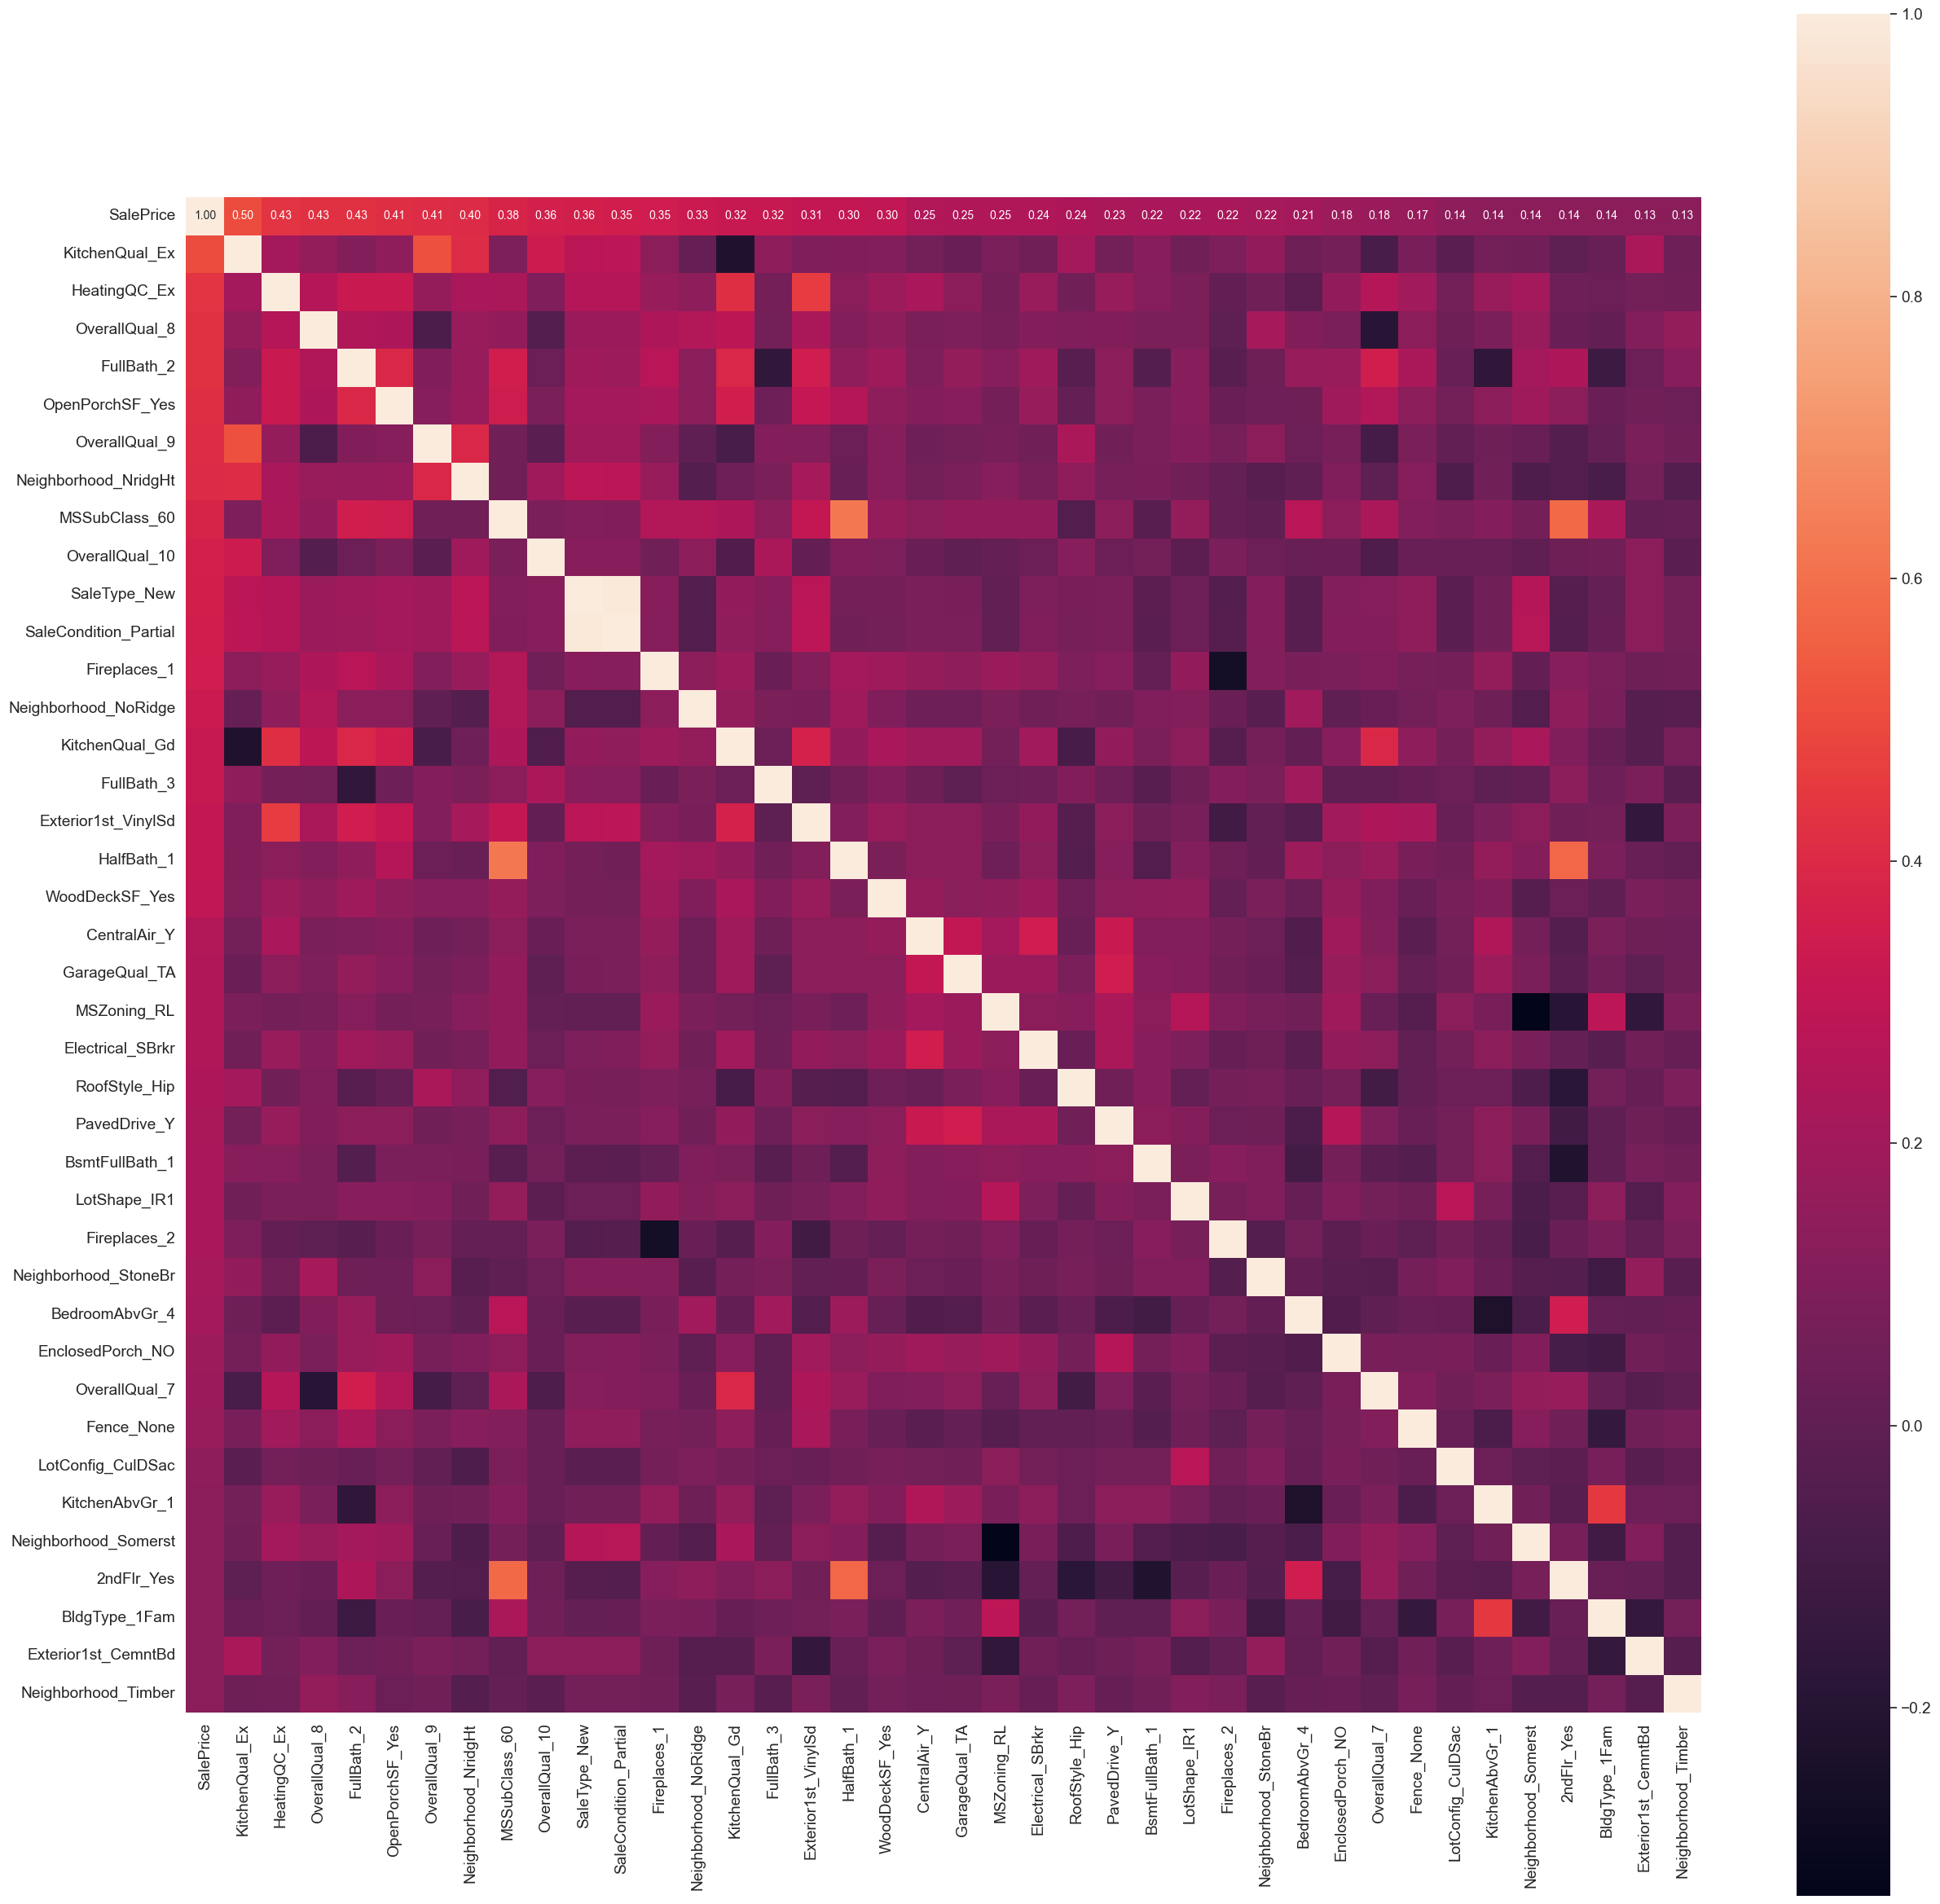

In [39]:
#saleprice correlation matrix - categorical
numerical_cols = numerical_cols[:-1]
data_transf_cat = data_transf.drop(numerical_cols, axis=1)
corrmat_categorical = data_transf_cat.corr()
corrmat_categorical = corrmat_categorical[corrmat_categorical.columns.sort_values()].sort_index()

plt.figure(figsize=(30, 30))
k = 40 #number of variables for heatmap
cols = corrmat_categorical.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_transf_cat[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- 'SaleType', ''SaleCondition'

In [40]:
X = X.drop(['TotRmsAbvGrd', 'BsmtUnfSF', 'SaleType', 'SaleCondition'], axis=1)
test_data = test_data.drop(['TotRmsAbvGrd', 'BsmtUnfSF', 'SaleType', 'SaleCondition'], axis=1)

categorical_cols = [col for col in X.columns if X[col].dtype not in ['int64', 'float64']]
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numerical_cols = [col for col in numerical_cols if col not in suspected_categorical]
categorical_cols.extend(suspected_categorical)

for col in not_important_categorical_cols:
    if col in categorical_cols:
        categorical_cols.remove(col)

## Random Forest #3

In [41]:
# Preprocessing for numerical data
numerical_transformer_3 = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot_3 = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer_3 = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot_3)
])

# Full column transformer
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer_3, numerical_cols),
        ('categorical', categorical_transformer_3, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model_3 = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)

# Full data pipeline
rf_pipeline_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('model', rf_model_3)
])

In [42]:
rf_pipeline_3.fit(X, y)

# Access model from pipeline
model_3 = rf_pipeline_3.named_steps['model']

# Access preprocessor from pipeline
preprocessor_3 = rf_pipeline_3.named_steps['preprocessor']

# Extract transformed categorical columns from preprocessor
categorical_cols_transformed = preprocessor_3.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_cols)

# Combine transformed categorical columns and numerical columns
new_cols = list(numerical_cols) + list(categorical_cols_transformed)

# Extract transformed data from preprocessor
X_transformed_data = preprocessor_3.transform(X)

# Reconstitute DataFrame after preprocessing
X_transformed = pd.DataFrame(X_transformed_data, columns=new_cols)

# Cross-Validation
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(model_3, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.86149314 0.82479541 0.87197335 0.88793759 0.81654057], scores average: (0.8525480131033618, 'std: ', 0.02748281307678693)


Cross-validation scores: [7.66307156e+08 1.15121153e+09 9.70160062e+08 5.67691890e+08
 1.23016329e+09], scores average: (937106786.4479622, 'std: ', 244317562.46561158)


In [43]:
# predictions_3 = rf_pipeline_3.predict(test_data)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

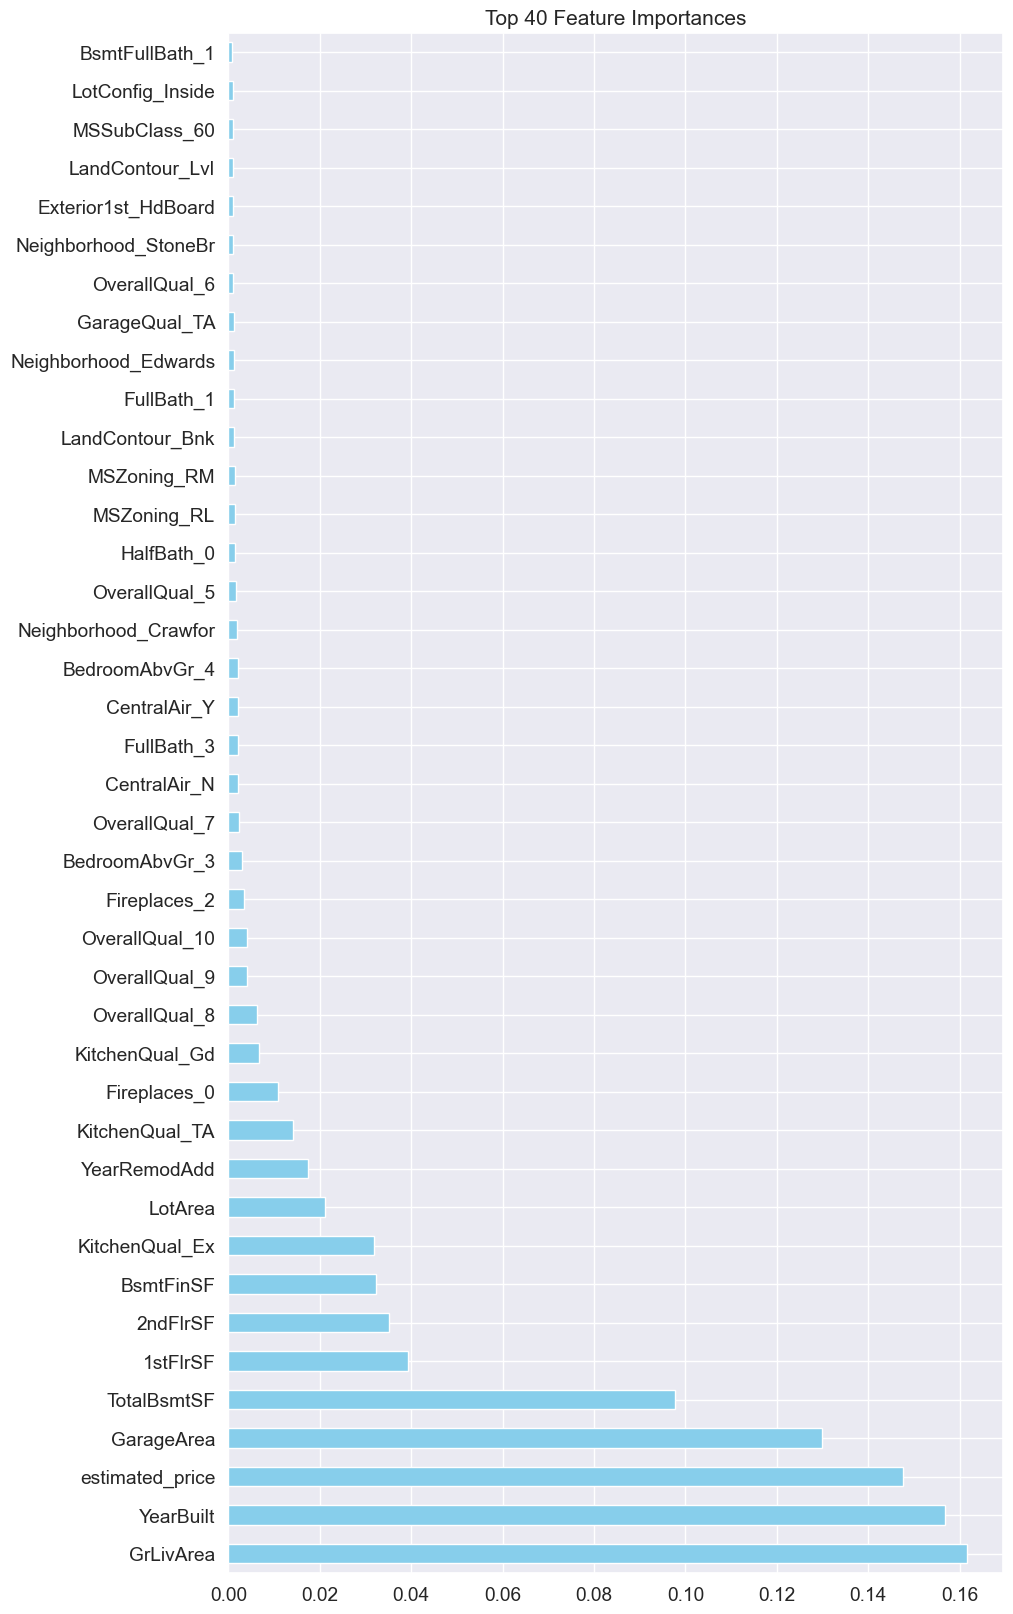

In [44]:
plot_top_n_importance(DataFrame=X_transformed, model=model_3, top_n=40)

In [45]:
len(X_transformed.columns)

223

In [46]:
test_transformed = preprocessor_3.transform(test_data)
test_transformed = pd.DataFrame(test_transformed, columns=new_cols)

# XGboost

In [47]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

XG_model = xgb.XGBRegressor(random_state=42)

XG_model.fit(X_transformed, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [48]:
cv_scores = cross_val_score(XG_model, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(XG_model, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.84735948 0.84463507 0.86266043 0.87289622 0.8750273 ], scores average: (0.8605156982510511, 'std: ', 0.01259955773936199)


Cross-validation scores: [8.44503505e+08 1.02085167e+09 1.04073153e+09 6.43889320e+08
 8.37988131e+08], scores average: (877592831.2638212, 'std: ', 144511658.3220781)


In [49]:
test_transformed.columns

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'GarageArea', 'estimated_price', 'BsmtFinSF',
       ...
       'BedroomAbvGr_2', 'BedroomAbvGr_3', 'BedroomAbvGr_4', 'BedroomAbvGr_5',
       'BedroomAbvGr_6', 'BedroomAbvGr_8', 'KitchenAbvGr_0', 'KitchenAbvGr_1',
       'KitchenAbvGr_2', 'KitchenAbvGr_3'],
      dtype='object', length=223)

In [50]:
# predictions = XG_model.predict(test_transformed)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(2, 8),
    'learning_rate': [0.01, 0.05, 0.1, 1.5],
    'subsample': [0.1, 0.5, 0.8, 1],
    'colsample_bytree': [0.1, 0.5, 0.8, 1]
}

# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_transformed, y)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1}


In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

In [57]:
XG_model = xgb.XGBRegressor(random_state=42, learning_rate=0.1, colsample_bytree=0.1, max_depth=5, subsample=1)

XG_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=False)

cv_scores = cross_val_score(XG_model, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(XG_model, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.89409245 0.85148798 0.89109634 0.91136096 0.8929826 ], scores average: (0.8882040657739576, 'std: ', 0.019749355777965046)


Cross-validation scores: [5.85947279e+08 9.75823435e+08 8.25249917e+08 4.49032519e+08
 7.17591228e+08], scores average: (710728875.6717181, 'std: ', 183026072.6495728)


In [58]:
# After fitting the model
optimal_n_estimators = XG_model.best_iteration + 1
print("Optimal number of trees (n_estimators):", optimal_n_estimators)

Optimal number of trees (n_estimators): 100


In [59]:
XG_model_2 = xgb.XGBRegressor(
    random_state=42, 
    learning_rate=0.1, 
    colsample_bytree=0.1, 
    max_depth=5, 
    subsample=1, 
    n_estimators=optimal_n_estimators, 
    n_jobs=-1
    )


XG_model_2.fit(X_transformed, y, verbose=False)

cv_scores = cross_val_score(XG_model_2, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(XG_model_2, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.89409245 0.85148798 0.89109634 0.91136096 0.8929826 ], scores average: (0.8882040657739576, 'std: ', 0.019749355777965046)


Cross-validation scores: [5.85947279e+08 9.75823435e+08 8.25249917e+08 4.49032519e+08
 7.17591228e+08], scores average: (710728875.6717181, 'std: ', 183026072.6495728)


In [70]:
# predictions = XG_model_2.predict(test_transformed)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

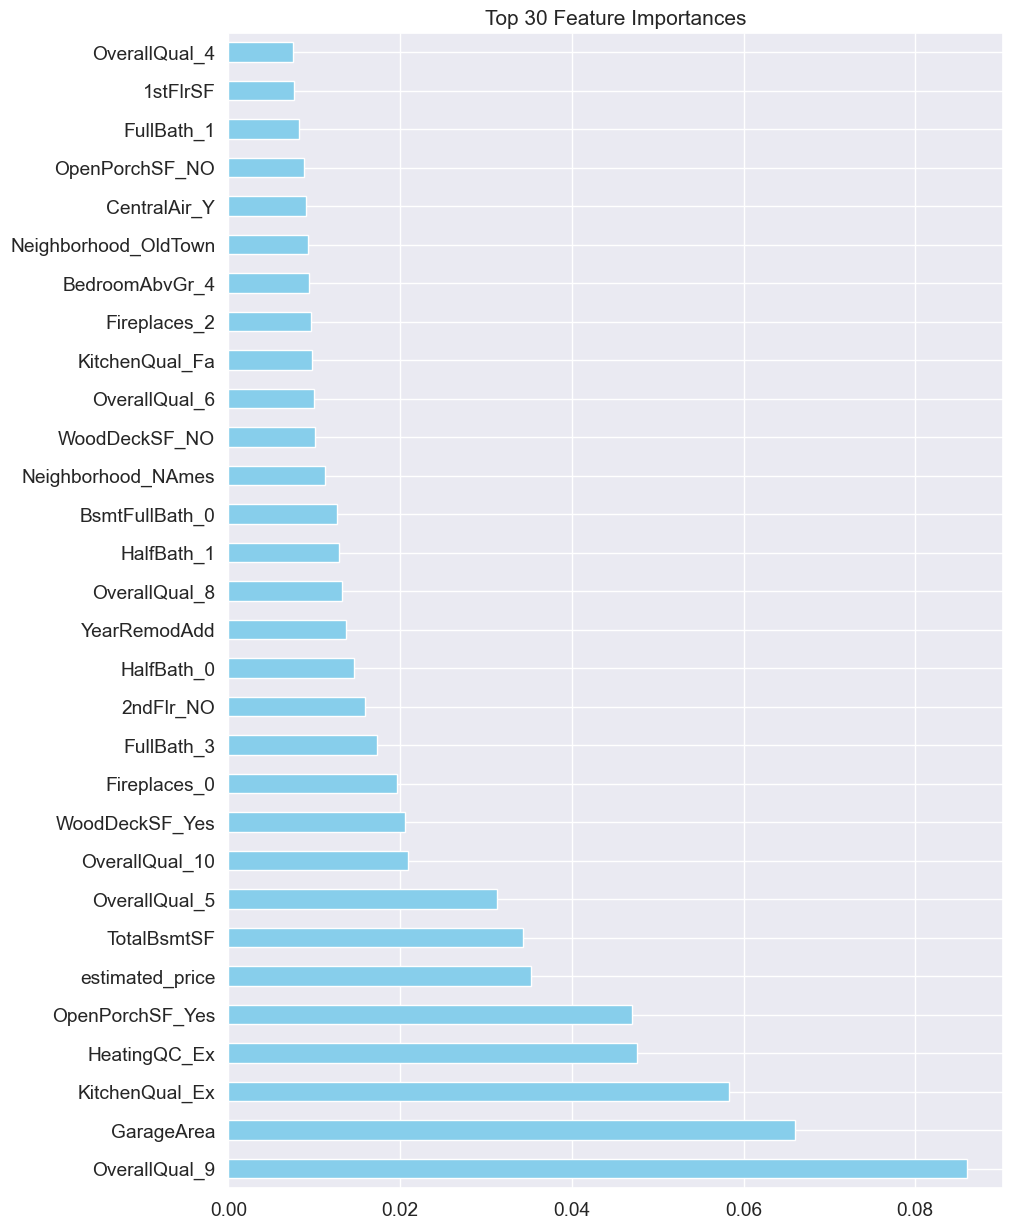

In [60]:
plot_top_n_importance(X_transformed, model=XG_model_2, top_n=30)

In [61]:
X = X_transformed

In [62]:
from sklearn.feature_selection import RFE

def feature_selection_optimizer(estimator, X, y, n_range, scoring, cv):
    """
    A method to find the optimal number of features for XGBoost regression with Sklearn's RFE selector.

    Args:
    - estimator: An XGBoost regressor instance.
    - X, y: Input features and target.
    - scoring (str): A scoring method [e.g., 'neg_mean_squared_error']
    - cv (int): Number of folds for cross-validation.

    Returns:
    - DataFrame with n as index and the results of feature selection for each n in n_range
    """
    results = []
    for n in n_range:
        
        # Initialize RFE with the XGBoost regressor and n features
        selector = RFE(estimator=estimator, n_features_to_select=n, verbose=0)

        # Fit RFE
        selector.fit(X, y)

        # Get selected features
        selected_features = np.array(X.columns)[selector.support_]

        # Calculate cross-validation scores
        cv_scores = cross_val_score(estimator, X[selected_features], y, cv=cv, scoring=scoring)
        if scoring == 'neg_mean_squared_error':
            cv_scores = -1 * cv_scores

        # Append results for this iteration
        results.append({'n_features': n, 'selected_features': selected_features, 'Cross-validation scores': cv_scores, 'score_average': cv_scores.mean(), 'std_dev': cv_scores.std()})

    return (selector, pd.DataFrame(results).set_index('n_features'))
 

In [64]:
from sklearn.feature_selection import RFECV

# Initialize XGBoost Regressor
XG_model_3 = xgb.XGBRegressor(
    random_state=42, 
    learning_rate=0.1, 
    colsample_bytree=0.1, 
    max_depth=5, 
    subsample=1, 
    n_estimators=optimal_n_estimators, 
    n_jobs=-1
    )

n_range = range(30, 201, 5)

selector, n_selection = feature_selection_optimizer(
    X=X, 
    y=y, 
    n_range=n_range, 
    scoring='neg_mean_squared_error', 
    cv=5, estimator=XG_model_3
    )

In [65]:
import pickle
import os

# Specify the directory path
directory = r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\Pickle'  # Replace with your desired path

# Ensure the directory exists, create if it doesn't
if not os.path.exists(directory):
    os.makedirs(directory)

# Specify the file path
file_path_1 = os.path.join(directory, 'n_selection_xgboost')
file_path_2 = os.path.join(directory, 'rfe_selector_xgboost')

# Save the object to the specified directory
with open(file_path_1, 'wb') as file:
    pickle.dump(n_selection, file)

with open(file_path_2, 'wb') as file:
    pickle.dump(selector, file)

In [66]:
# Sort optimizer output to find best average score and std
n_selection_sorted = n_selection.sort_values(by=['score_average', 'std_dev'])
n_selection_sorted.head()

selected_features  \
n_features                                                      
95          [LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF...   
100         [LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF...   
90          [LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF...   
70          [LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF...   
80          [LotArea, YearBuilt, YearRemodAdd, TotalBsmtSF...   

                                      Cross-validation scores  score_average  \
n_features                                                                     
95          [555566432.8857679, 869283851.8202485, 8146987...  664662623.188   
100         [563249554.590663, 814579448.26197, 830131189....  678431214.299   
90          [560994200.6092176, 896763112.0906836, 7205797...  680576810.723   
70          [542336960.2327254, 931125290.0919553, 7566909...  699846573.764   
80          [595377518.5445831, 916892055.7502075, 7797409...  703411775.782   

                 std_dev  
n_features                
95         149499363.367  
100        132350716.193  
90         122940074.237  
70         154096762.473  
80         158058702.145

In [67]:
# Select best n_features based on scores and extract from DataFrame
best_selection = n_selection_sorted.iloc[0].to_frame().reset_index()
best_selection.columns = ['Key', 'Value']
best_selected_features = best_selection[best_selection['Key'] == 'selected_features']['Value'][0]
# best_selected_features = best_selected_features.iloc[0]

In [68]:
# Reform train and test
X_optimized = selector.transform(X)
X_optimized = pd.DataFrame(X_optimized, columns=selector.get_feature_names_out())

test_optimized = selector.transform(test_transformed)
test_optimized = pd.DataFrame(test_optimized, columns=selector.get_feature_names_out())

In [69]:
# Initialize XGBoost Regressor
XG_model_4 = xgb.XGBRegressor(
    random_state=42, 
    learning_rate=0.1, 
    colsample_bytree=0.8, 
    max_depth=3, 
    subsample=0.8, 
    n_estimators=optimal_n_estimators, 
    n_jobs=-1
    )
# Train model
XG_model_4.fit(X_optimized, y)

# Evaluate via score
cv_scores = cross_val_score(XG_model_4, X_optimized, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(XG_model_4, X_optimized, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.85960699 0.80403677 0.88774928 0.90169579 0.89155929], scores average: (0.8689296249190146, 'std: ', 0.03532108886055657)


Cross-validation scores: [7.76742571e+08 1.28760965e+09 8.50613255e+08 4.97994845e+08
 7.27135057e+08], scores average: (828019074.8254473, 'std: ', 258246722.10033724)


In [ ]:
# predictions = XG_model_4.predict(test_optimized)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

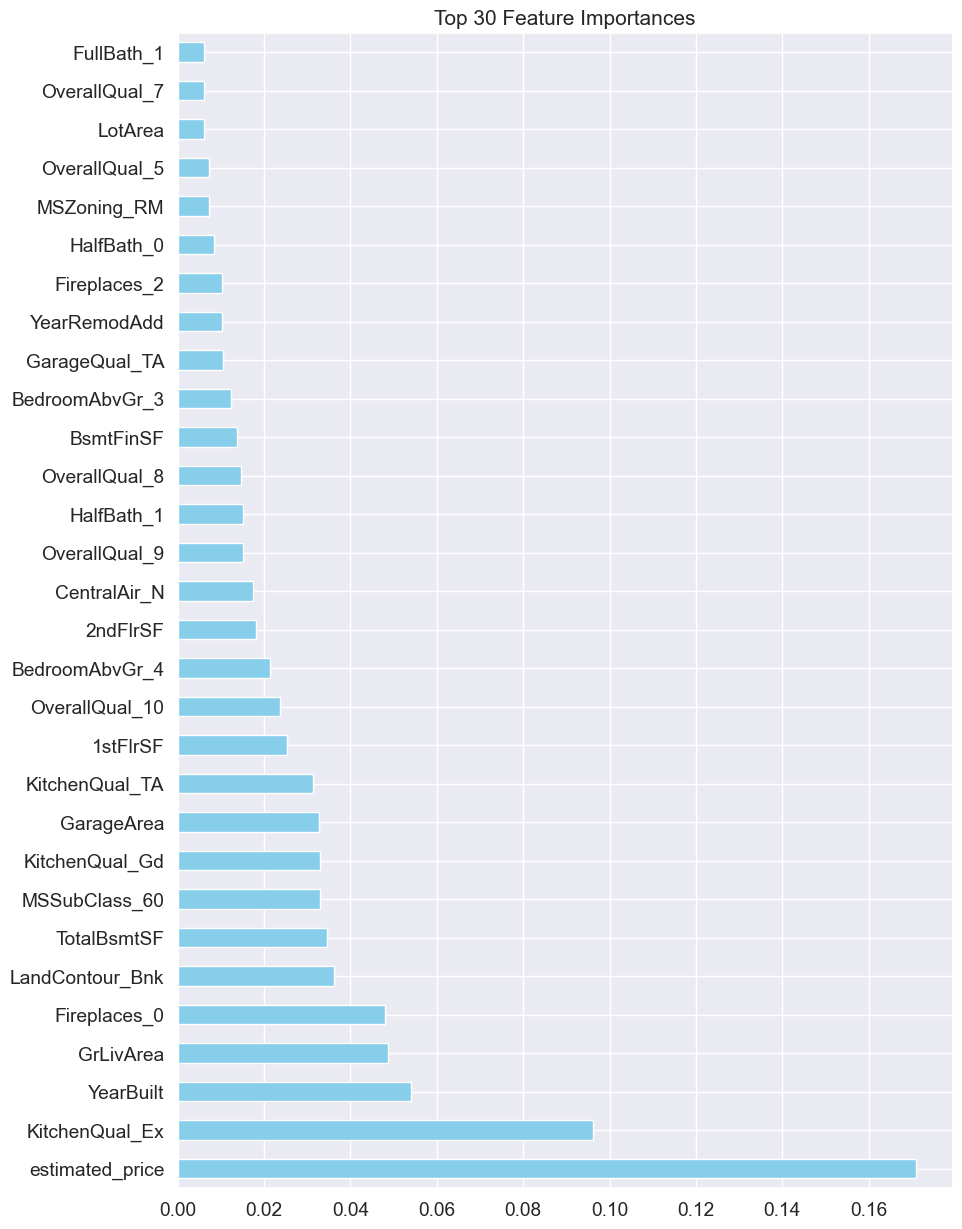

In [71]:
plot_top_n_importance(X_optimized, model=XG_model_4, top_n=30)

In [72]:
# Initialize XGBoost Regressor
XG_model_5 = xgb.XGBRegressor(
    random_state=42, 
    learning_rate=0.1, 
    colsample_bytree=0.8, 
    max_depth=3, 
    subsample=0.8, 
    n_estimators=optimal_n_estimators, 
    n_jobs=-1
    )

XG_model_5.fit(X_optimized, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [73]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(XG_model_5)
# Calculate SHAP values - this might take some time for larger datasets
shap_values = explainer(X_optimized)

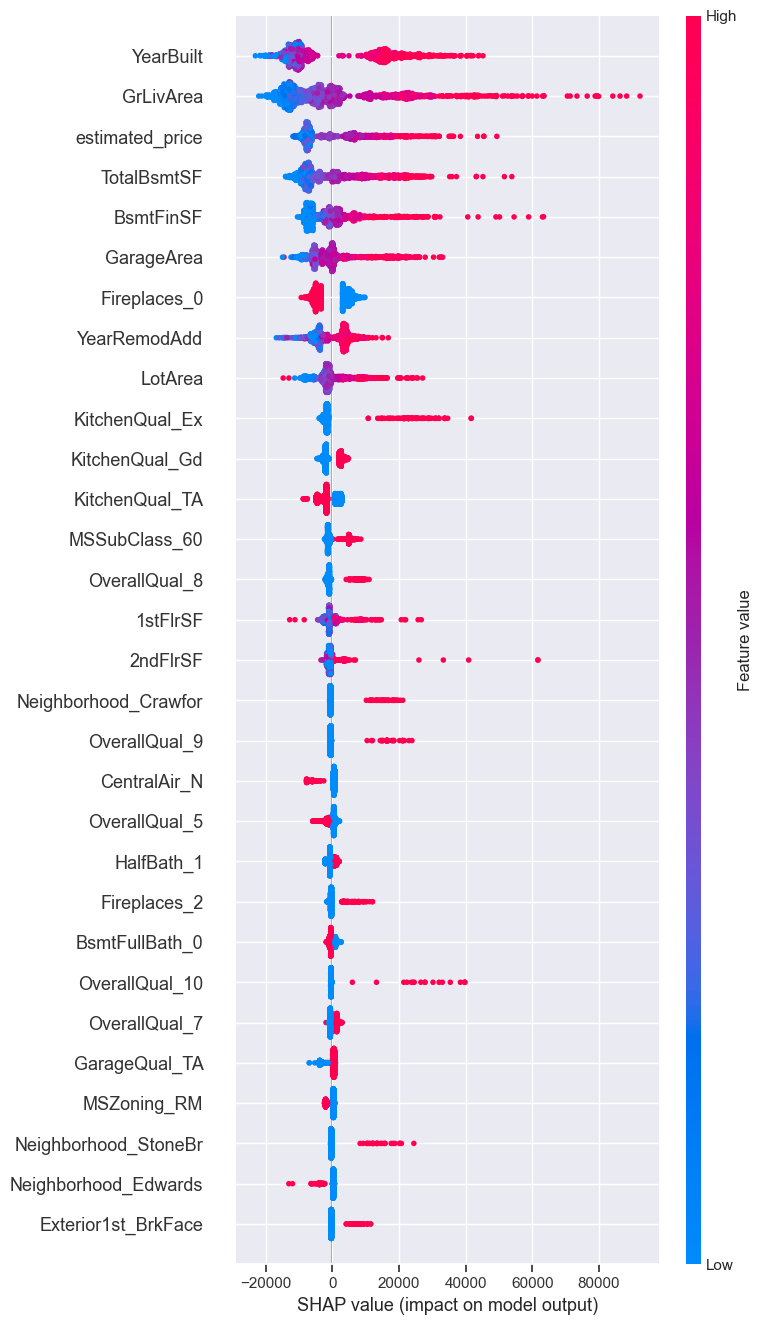

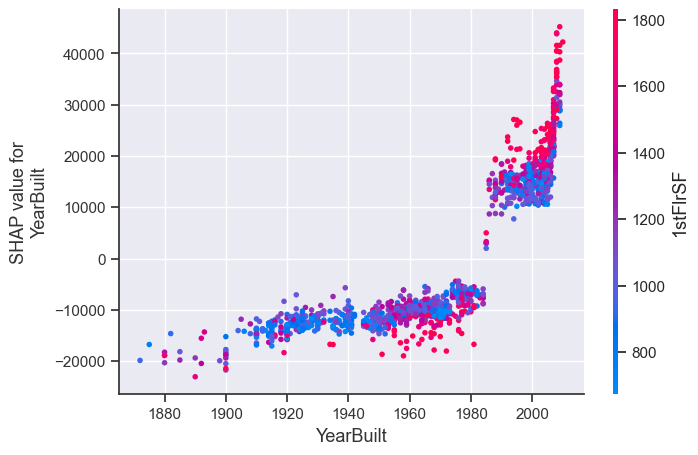

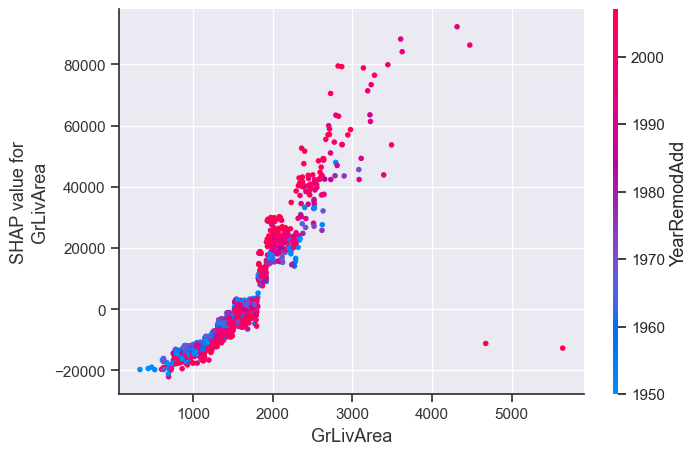

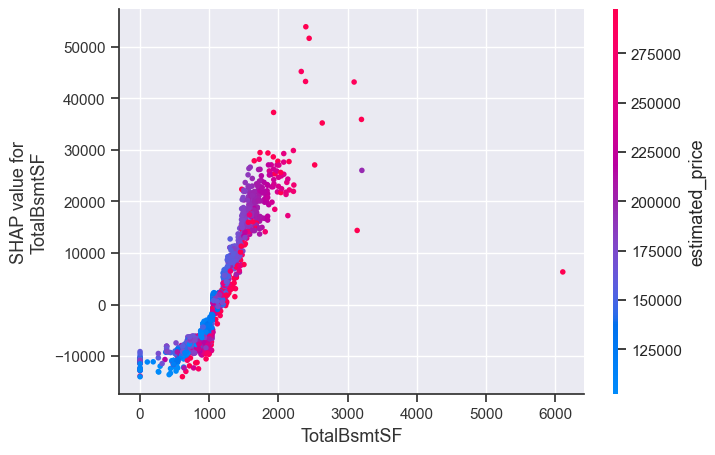

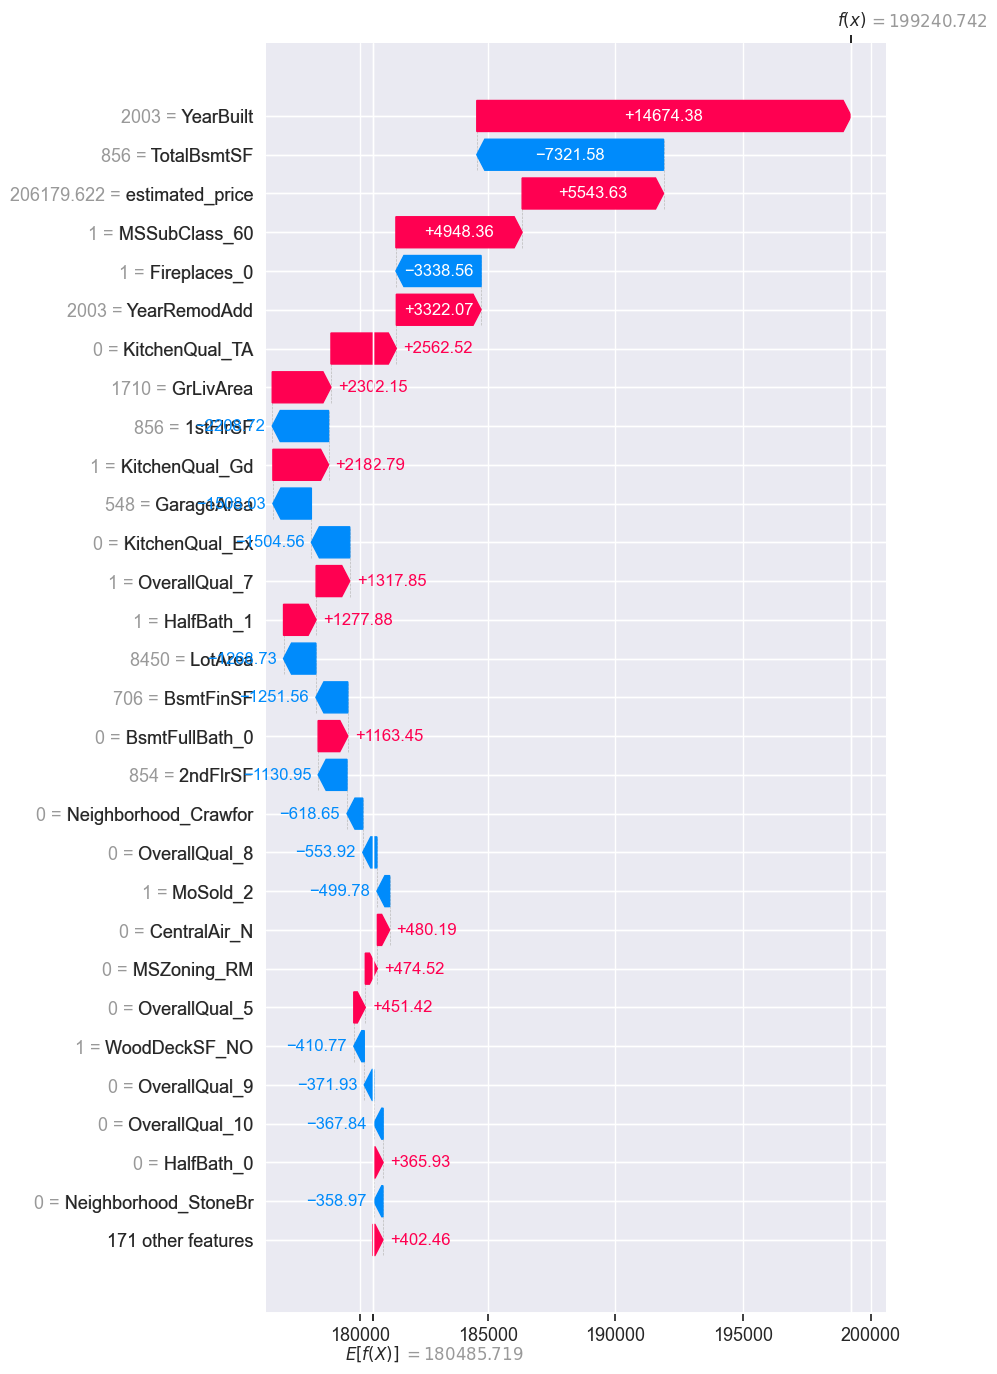

In [74]:
# Summary plot
shap.summary_plot(shap_values, X_optimized, max_display=30)

# Dependence plot for specific features
shap.dependence_plot('YearBuilt', shap_values.values, X_optimized)

shap.dependence_plot('GrLivArea', shap_values.values, X_optimized)

shap.dependence_plot('TotalBsmtSF', shap_values.values, X_optimized)

# For a specific instance (e.g., the first instance in your dataset)
shap.plots.waterfall(shap_values[0], max_display=30)


### 2. Remove Outliers

In [75]:
def outlier_removal(data, column):
    # Stage 3: Deal with Outliers in 'LotArea'
    Q1 = data['LotArea'].quantile(0.25)
    Q3 = data['LotArea'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Removing outliers
    data[column] = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [76]:
selected_numeric_cols = [col for col in numerical_cols if col in best_selected_features]
selected_numeric_cols

['LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'estimated_price',
 'BsmtFinSF']

In [ ]:
for col in 

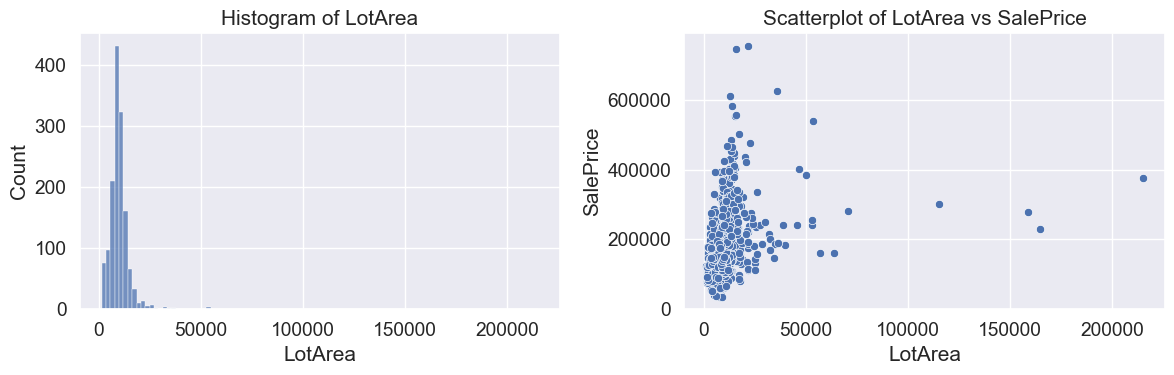

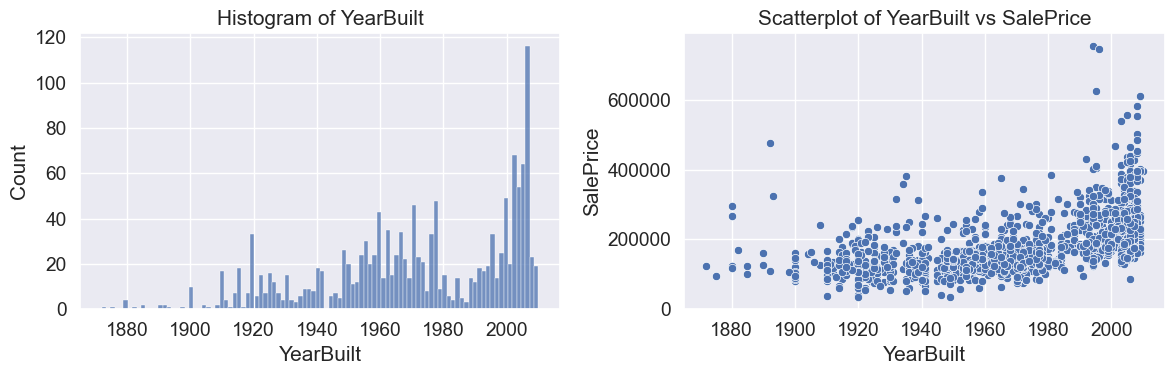

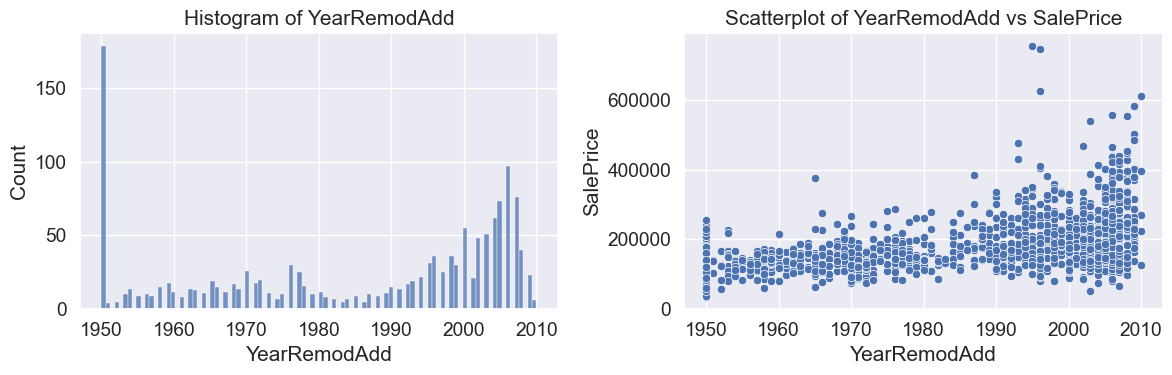

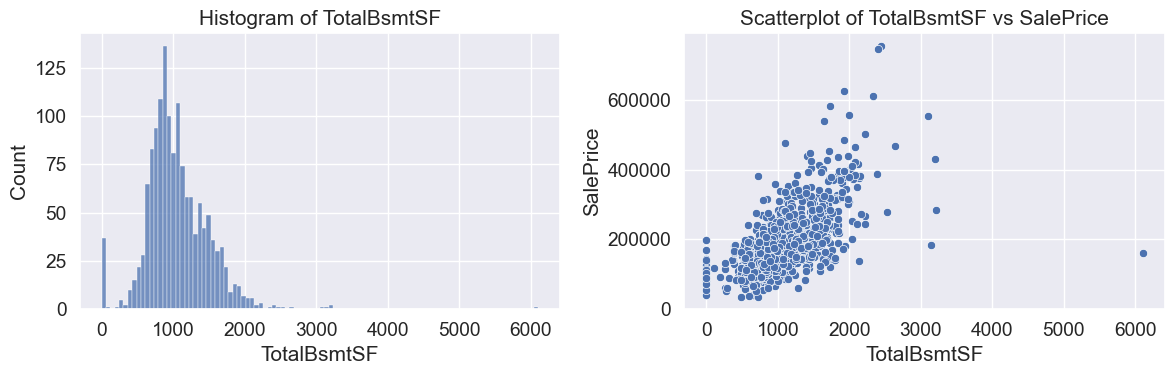

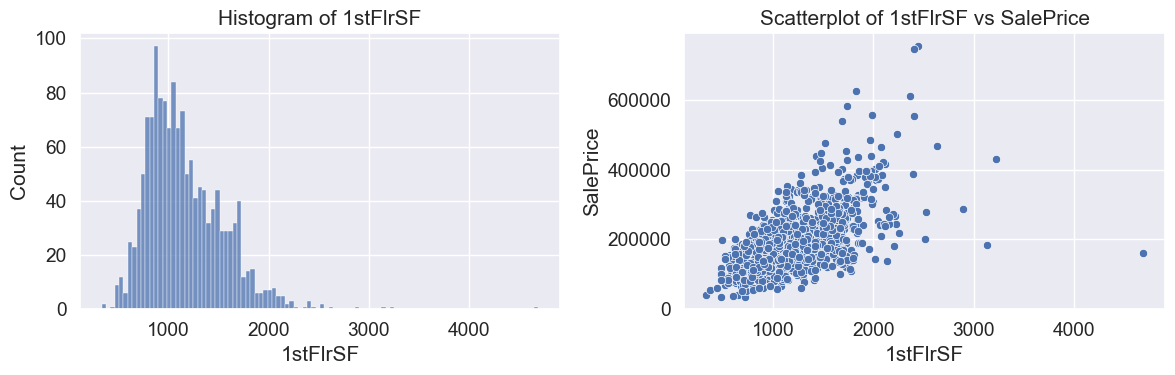

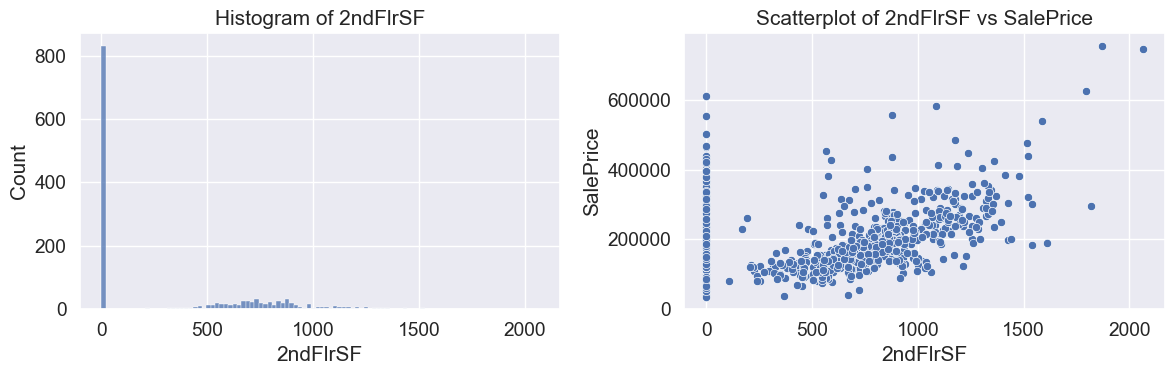

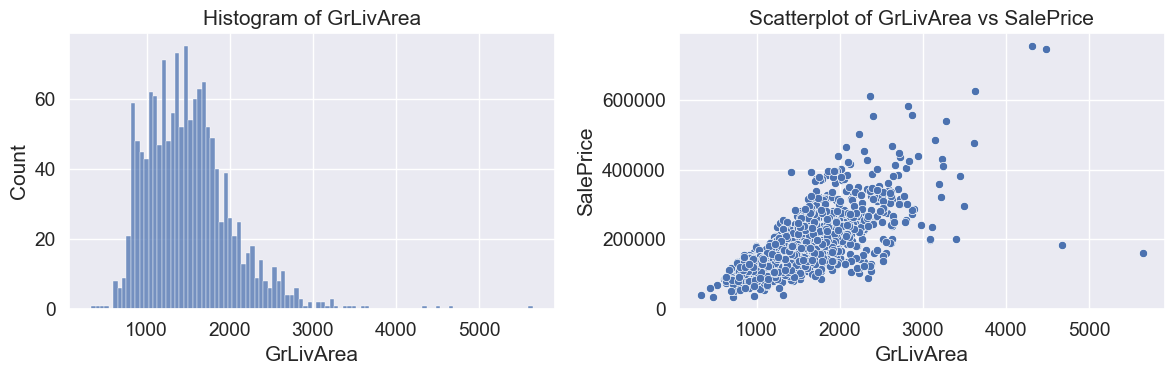

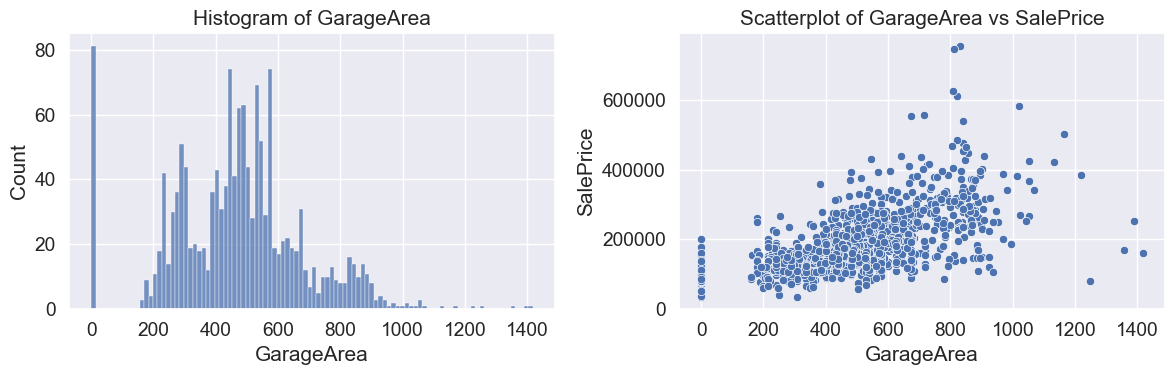

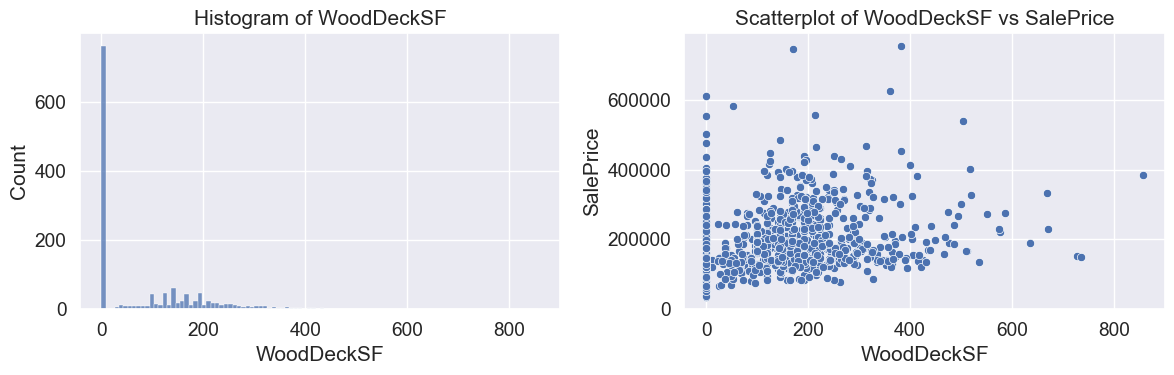

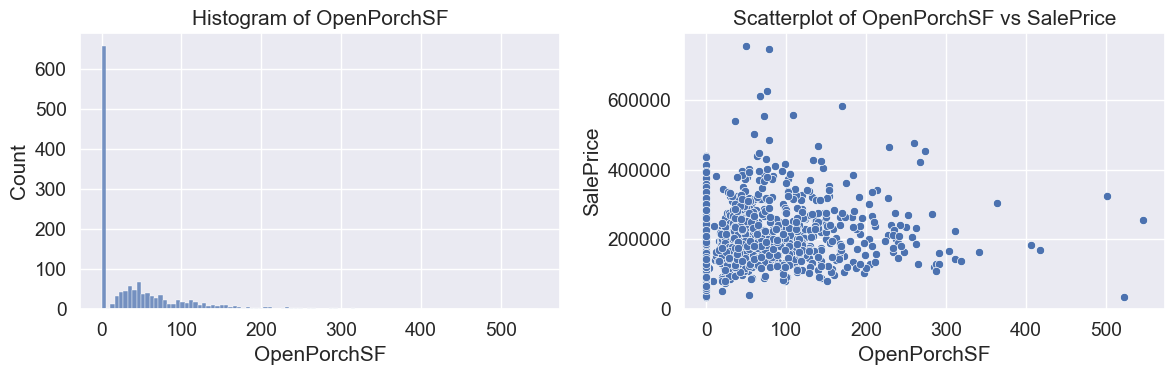

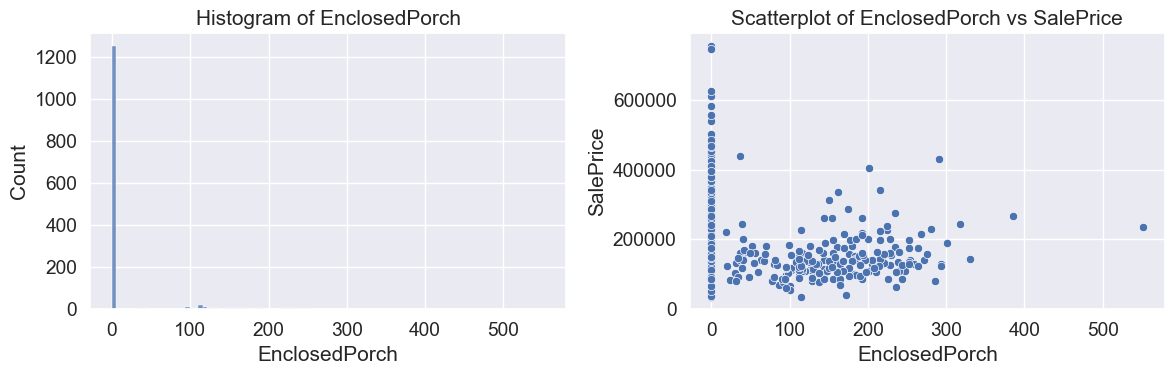

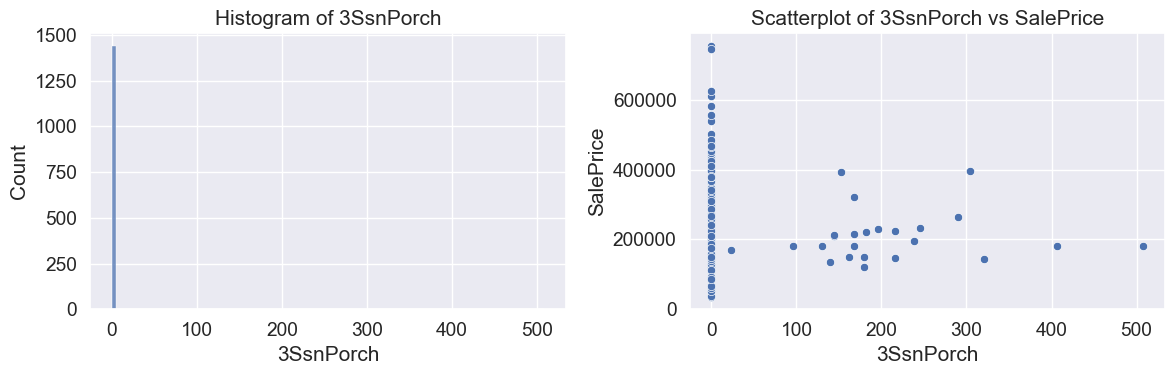

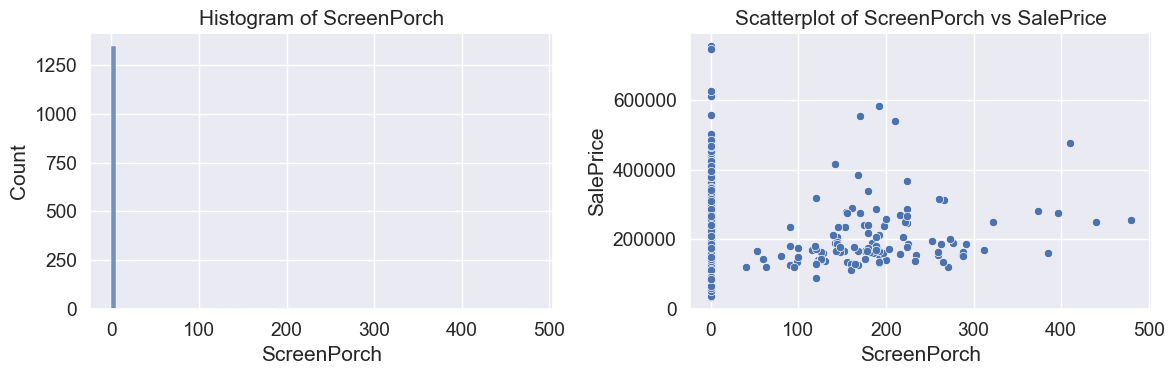

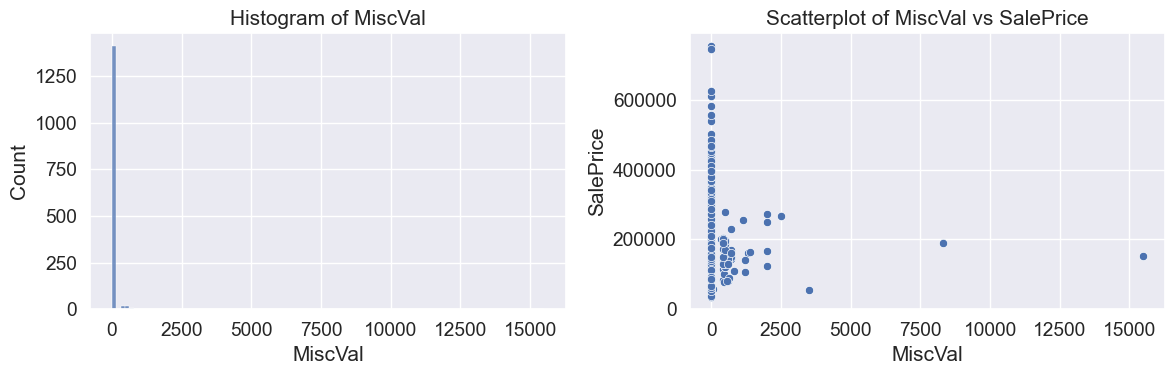

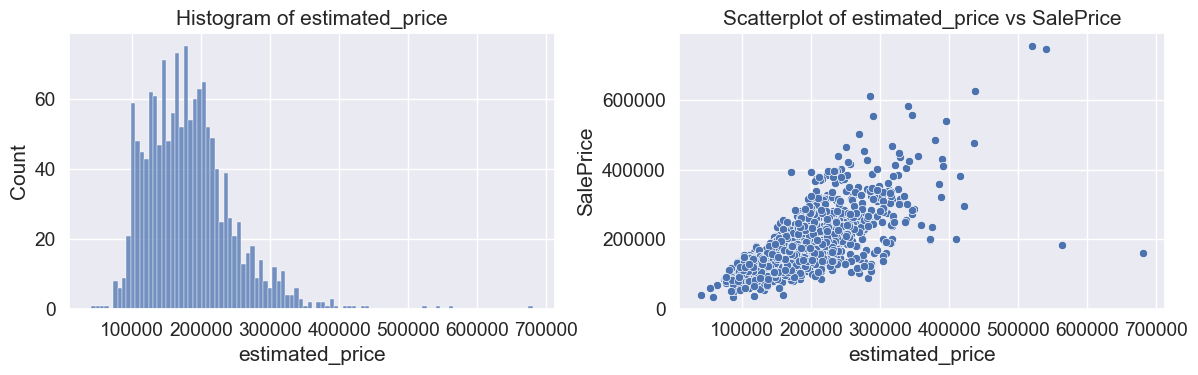

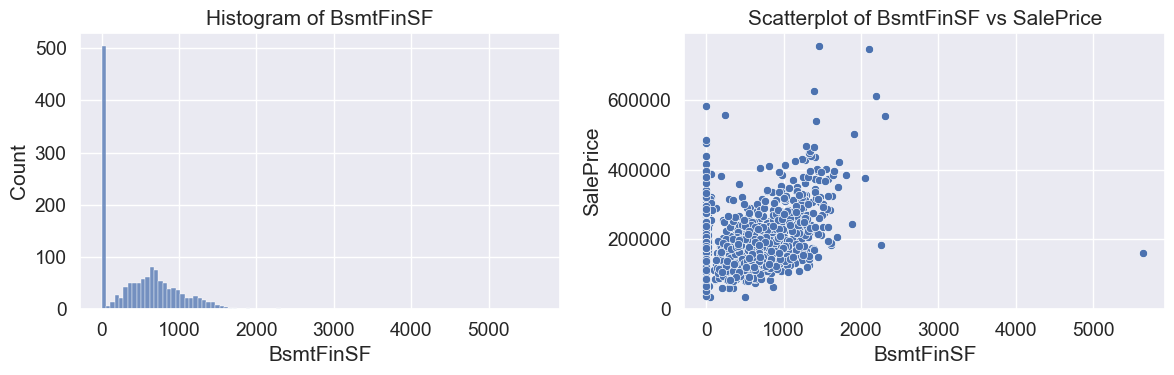

In [ ]:
for col in selected_numeric_cols:
    # Set up the matplotlib figure
    f, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    sns.histplot(X_optimized[col], ax=axes[0], bins=100)
    axes[0].set_title(f'Histogram of {col}')

    # Scatterplot
    sns.scatterplot(x=X_optimized[col], y=y, ax=axes[1])
    axes[1].set_title(f'Scatterplot of {col} vs {y.name}')

    plt.tight_layout()
    plt.show()

### 3. Normalization

#### Train  Data:

In [ ]:
selected_numerical_cols = [col for col in X_selected.columns if col in numerical_cols]

NameError: name 'X_selected' is not defined

In [ ]:
# Check the skew of all numerical features
skewed_feats = X_selected[selected_numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.sort_values(by='Skew', ascending=False)


Skew in numerical features: 



Skew
LotArea         12.195
KitchenAbvGr     4.484
TotalBsmtSF      1.523
BsmtFinSF        1.405
1stFlrSF         1.375
GrLivArea        1.365
estimated_price  1.365
2ndFlrSF         0.812
GarageArea       0.180
YearRemodAdd    -0.503
YearBuilt       -0.613

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print(f"There are potentially {skewness.shape[0]} skewed numerical features to Box Cox transform")



There are potentially 11 skewed numerical features to Box Cox transform


- Years should not be transformed.

In [ ]:
skewness.drop(['YearBuilt', 'YearRemodAdd'], axis=0, inplace=True)

In [ ]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    X_selected[feat] = boxcox1p(X_selected[feat], lam)
    
X_selected[skewed_features] = np.log1p(X_selected[skewed_features])

#### Target  Data:

In [ ]:
y = boxcox1p(y, lam)
y = np.log1p(y)

#### Test  Data:

In [ ]:
selected_test_data= rfe.transform(test_transformed)
selected_test_data = pd.DataFrame(selected_test_data, columns=rfe.get_feature_names_out())
selected_numerical_cols_test = [col for col in selected_test_data.columns if col in numerical_cols]

# Check the skew of all numerical features
skewed_feats_test = selected_test_data[selected_numerical_cols_test].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness_test = pd.DataFrame({'Skew' :skewed_feats_test})
skewness_test.sort_values(by='Skew', ascending=False)


Skew in numerical features: 



Skew
KitchenAbvGr     4.075
LotArea          3.112
1stFlrSF         1.557
estimated_price  1.129
GrLivArea        1.129
BsmtFinSF        0.956
2ndFlrSF         0.912
TotalBsmtSF      0.813
GarageArea       0.300
YearRemodAdd    -0.399
YearBuilt       -0.587

In [ ]:
skewness_test.drop(['YearBuilt', 'YearRemodAdd'], axis=0, inplace=True)

In [ ]:
skewed_features_test = skewness_test.index
lam = 0.15
for feat in skewed_features_test:
    #all_data[feat] += 1
    selected_test_data[feat] = boxcox1p(selected_test_data[feat], lam)
    
selected_test_data[skewed_features_test] = np.log1p(selected_test_data[skewed_features_test])

In [ ]:
XG_model_3 = xgb.XGBRegressor(
    random_state=42, 
    learning_rate=0.1, 
    colsample_bytree=0.8, 
    max_depth=5, 
    subsample=0.8, 
    n_estimators=optimal_n_estimators, 
    n_jobs=-1
    )

XG_model_3.fit(X_selected, y)

cv_scores = cross_val_score(XG_model_3, X_transformed, y, cv=5)
print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

cv_scores_mse = -1 * cross_val_score(XG_model_3, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

Cross-validation scores: [0.85542126 0.83590039 0.84483923 0.86588926 0.8326156 ], scores average: (0.8469331480984774, 'std: ', 0.012348933402725238)


Cross-validation scores: [0.00065689 0.00090374 0.00078984 0.0005924  0.0007771 ], scores average: (0.0007439943716969077, 'std: ', 0.00010889001769946865)


In [ ]:
# predictions = XG_model_3.predict(selected_test_data)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.3, random_state=32)

In [ ]:
# predictions = rf_pipeline_4.predict(test_data)

# # Prepare submission file
# submission = pd.DataFrame({
#     'Id': test_data_origin['Id'],
#     'SalePrice': predictions
# })

# file_name = input('File Name: ')

# # Save submission file
# submission.to_csv(f'{file_name}.csv', index=False)